# Classification d'Images : Photo vs Non-Photos à l'aide de Réseaux de Neurones Convolutifs

### Introduction et Objectif

L'objectif principal de ce notebook est de répondre au besoin de l'entreprise d'automatiser la sélection d'images pour l'annotation. Pour cela, nous développons et évaluons un modèle de classification basé sur les réseaux de neurones convolutifs (CNN) capable de **distinguer automatiquement les photographies des autres types d'images** (peintures, dessins, schémas, textes, etc.), ces dernières étant regroupées sous l'étiquette 'Non-Photo'. L'enjeu est de créer un filtre fiable pour ne conserver que les photographies pertinentes issues d'un dataset initial hétérogène.

Les données sources sont constituées de plusieurs archives distinctes, chacune contenant un type spécifique d'image (peintures, schémas, portraits dessinés, textes scannés, photos). Bien que non étiquetées individuellement, leur provenance permet de les regrouper facilement en deux classes pour notre tâche de classification binaire : 'Photo' et 'Non-Photo'.

### Description du Livrable et Contenu

Ce notebook Jupyter constitue le livrable final. Il détaille l'ensemble du processus, de la préparation des données à l'évaluation du modèle final, en passant par la comparaison de plusieurs architectures :

1.  **Préparation des Données :** Nettoyage initial (validation des formats), regroupement des différentes archives en classes binaires ('Photo', 'Non-Photo'), et division en ensembles d'entraînement, de validation et de test.
2.  **Architectures CNN :** Implémentation et entraînement de plusieurs architectures CNN inspirées de modèles reconnus (EfficientNet-Like, GoogLeNet-Like, ResNet-Like, DenseNet-Like) à l'aide de **TensorFlow/Keras**.
3.  **Sélection et Justification du Modèle Final :** Comparaison des performances des différents modèles sur l'ensemble de test et sélection du modèle le plus performant (ici, ResNet-Like). La justification repose sur les métriques obtenues.
4.  **Détails Techniques du Modèle Sélectionné :**
    *   Schéma conceptuel ou description détaillée de l'**architecture du réseau** retenu (ResNet-Like).
    *   Explication des **paramètres clés** du réseau (dimensions d'entrée, structure des couches).
    *   Description de la **fonction de perte** utilisée (`BinaryCrossentropy`).
    *   Détails sur l'**algorithme d'optimisation** employé (`Adam`) et sa configuration.
5.  **Code TensorFlow :** L'ensemble du code utilisé pour la définition des modèles, l'entraînement et l'évaluation est inclus et commenté.
6.  **Visualisation des Performances :**
    *   **Graphiques d'évolution** de la perte (`loss`) et de la précision (`accuracy`) pour les ensembles d'entraînement et de validation au fil des époques.
    *   Matrice de confusion sur l'ensemble de test pour le meilleur modèle.
7.  **Analyse des Résultats :**
    *   Interprétation des métriques finales sur l'ensemble de test.
    *   Discussion approfondie du **compromis entre biais et variance** (sous-apprentissage vs sur-apprentissage) observée pendant l'entraînement et reflétée dans les résultats finaux.
8.  **Méthodes d'Amélioration et Régularisation :** Description des techniques utilisées ou potentiellement utilisables pour optimiser le compromis biais/variance, telles que l'**augmentation de données, le Dropout, la régularisation L2, l'arrêt anticipé (Early Stopping)**, et la **réduction adaptative du taux d'apprentissage**.


### Environnement de développement et d'entrainement des modèles

**Utilisation de Docker pour standardiser l'environnement :**
Ce Dockerfile est utilisé pour créer une image Docker permettant d'exécuter ce notebook. Voici les étapes principales décrites dans ce fichier :

1. **Image de base :** L'image de base utilisée est une image NVIDIA optimisée pour TensorFlow 2 avec Python 3. Elle inclut les bibliothèques nécessaires pour exploiter les GPU NVIDIA.

2. **Répertoire de travail :** Un répertoire `/workspace` est créé pour contenir les fichiers et les données nécessaires à l'exécution du notebook.

3. **Cache PIP :** Un répertoire de cache est configuré pour accélérer les installations futures de dépendances Python.

4. **Installation des dépendances :** Les bibliothèques Python nécessaires sont installées à partir du fichier `requirements.txt`.

5. **Configuration de Jupyter :** Jupyter Notebook est configuré pour être accessible depuis n'importe quelle adresse IP (`0.0.0.0`), pour permettre l'exécution en tant que root, et pour désactiver l'ouverture automatique du navigateur.

6. **Exposition du port :** Le port 8888, utilisé par Jupyter, est exposé pour permettre l'accès au notebook depuis l'extérieur du conteneur.

7. **Commande par défaut :** Lorsque le conteneur est démarré, Jupyter Lab est lancé automatiquement.

Ce Dockerfile garantit que l'environnement d'exécution est reproductible et optimisé pour les tâches d'apprentissage profond nécessitant des GPU.

```Dockerfile
# Use the NVIDIA TensorFlow base image with Python 3 and TF2
FROM nvcr.io/nvidia/tensorflow:25.02-tf2-py3

# Create a working directory
WORKDIR /workspace

# Use PIP cache directory
ENV PIP_CACHE_DIR=/app/.pip-cache
RUN mkdir -p ${PIP_CACHE_DIR}

# Copy requirements first for caching
COPY requirements.txt .
RUN pip install -r requirements.txt

# Set up Jupyter config
RUN mkdir -p /root/.jupyter && \
    echo "c.NotebookApp.ip = '0.0.0.0'" >> /root/.jupyter/jupyter_notebook_config.py && \
    echo "c.NotebookApp.allow_root = True" >> /root/.jupyter/jupyter_notebook_config.py && \
    echo "c.NotebookApp.open_browser = False" >> /root/.jupyter/jupyter_notebook_config.py

# Expose Jupyter port (default: 8888)
EXPOSE 8888

# Start Jupyter Lab when container runs
CMD ["jupyter", "lab", "--allow-root"]
```


### Explication du fichier `docker-compose.yaml`

Ce fichier `docker-compose.yaml` est utilisé pour orchestrer l'exécution d'un conteneur Docker configuré pour exécuter un environnement Jupyter Notebook optimisé pour l'apprentissage profond avec GPU. Voici une explication détaillée des sections principales :

#### Services
- **`jupyter`** : Définit le service principal pour exécuter Jupyter Lab.
  - **`build: .`** : Indique que l'image Docker doit être construite à partir du `Dockerfile` situé dans le répertoire courant.
  - **`restart: unless-stopped`** : Configure le conteneur pour redémarrer automatiquement sauf si explicitement arrêté.
  - **`runtime: nvidia`** : Spécifie que le conteneur doit utiliser le runtime NVIDIA pour accéder aux GPU.
  - **`ipc: host`** : Configure le mode IPC (Inter-Process Communication) pour partager la mémoire entre les processus.
  - **`shm_size: '4gb'`** : Alloue 4 Go de mémoire partagée pour éviter les erreurs liées à la mémoire insuffisante lors de l'exécution de modèles complexes.
  - **`environment`** : Définit les variables d'environnement nécessaires pour l'exécution :
    - `NVIDIA_VISIBLE_DEVICES=all` : Permet au conteneur d'accéder à tous les GPU disponibles.
    - `NVIDIA_DRIVER_CAPABILITIES=compute,utility` : Active les capacités nécessaires pour les calculs GPU.
    - `TF_GPU_ALLOCATOR=cuda_malloc_async` : Configure TensorFlow pour utiliser un allocateur de mémoire GPU asynchrone.
    - `TF_CPP_MIN_LOG_LEVEL=2` : Réduit la verbosité des logs TensorFlow (affiche uniquement les avertissements et erreurs).
    - `PYTHONUNBUFFERED=1` : Désactive le buffering de sortie Python pour afficher les logs en temps réel.
    - `OMP_NUM_THREADS=8` : Limite le nombre de threads OpenMP à 8 pour optimiser les performances.
  - **`ports`** : Expose le port 8888 du conteneur pour accéder à Jupyter Lab depuis l'hôte.
    - `"8888:8888"` : Mappe le port 8888 du conteneur au port 8888 de l'hôte.
  - **`volumes`** : Monte des répertoires de l'hôte dans le conteneur pour partager les données et conserver les résultats :
    - `../data/dataset:/workspace/data:cached` : Monte le dossier contenant les données brutes.
    - `../data/cleaned_dataset:/workspace/cleaned_data:cached` : Monte le dossier contenant les données nettoyées.
    - `./checkpoints:/workspace/checkpoints` : Monte le dossier pour sauvegarder les checkpoints des modèles.
    - `jupyter-data:/home/jovyan/.local/share/jupyter` : Monte un volume pour conserver les données spécifiques à Jupyter.
  - **`mem_limit: 16g`** : Limite la mémoire du conteneur à 16 Go.
  - **`cpus: 8`** : Limite le conteneur à utiliser 8 cœurs CPU.
  - **`command`** : Spécifie la commande à exécuter au démarrage du conteneur :
    - `jupyter lab --ip=0.0.0.0 --port=8888 --no-browser` : Lance Jupyter Lab accessible depuis n'importe quelle adresse IP.
    - `--ServerApp.token='' --ServerApp.password=''` : Désactive l'authentification par mot de passe ou token.
    - `--ServerApp.allow_origin='*'` : Permet l'accès depuis n'importe quelle origine.

#### Volumes
- **`jupyter-data`** : Définit un volume nommé pour stocker les données persistantes de Jupyter.

```yaml
---

services:
  jupyter:
    build: .
    restart: unless-stopped
    runtime: nvidia
    ipc: host
    shm_size: '4gb'
    environment:
      - NVIDIA_VISIBLE_DEVICES=all
      - NVIDIA_DRIVER_CAPABILITIES=compute,utility
      - TF_GPU_ALLOCATOR=cuda_malloc_async
      - TF_CPP_MIN_LOG_LEVEL=2
      - PYTHONUNBUFFERED=1
      - OMP_NUM_THREADS=8
    ports:
      - "8888:8888"
    volumes:
      - ../data/dataset:/workspace/data:cached
      - ../data/cleaned_dataset:/workspace/cleaned_data:cached
      - ./checkpoints:/workspace/checkpoints
      - jupyter-data:/home/jovyan/.local/share/jupyter
    mem_limit: 16g
    cpus: 8
    command: >
      jupyter lab --ip=0.0.0.0 --port=8888 --no-browser
      --ServerApp.token='' --ServerApp.password=''
      --ServerApp.allow_origin='*'

volumes:
  jupyter-data:
```

### Importation des librairies

**Quoi :** Cette cellule importe toutes les bibliothèques Python requises pour l'exécution du notebook.

**Comment :** Elle utilise l'instruction `import` pour charger des modules essentiels. Ils sont groupés par fonctionnalité :
*   **Manipulation système et fichiers :** `os`, `shutil`, `pathlib`, `time`.
*   **Calcul numérique et DataFrames :** `numpy` (pour les tableaux), `pandas` (pour structurer les résultats).
*   **Visualisation :** `matplotlib.pyplot` (graphiques de base), `seaborn` (graphiques statistiques esthétiques, notamment la matrice de confusion).
*   **Apprentissage Profond (TensorFlow/Keras) :** `tensorflow` et ses composants `keras` (couches, modèles, optimiseurs, etc.).
*   **Traitement d'images :** `PIL` (via `Image`) pour la manipulation d'images, `imghdr` pour la validation de type.
*   **Utilitaires d'entraînement :** `tqdm` (barres de progression), `concurrent.futures` (parallélisation).
*   **Utilitaires Scikit-learn :** `class_weight` (pour gérer le déséquilibre), `confusion_matrix` (pour évaluer la classification).
*   **Gestion des avertissements/logs :** `warnings`, `TF_CPP_MIN_LOG_LEVEL`.

**Pourquoi :** Importer toutes les dépendances au début assure que les fonctions nécessaires sont disponibles globalement. Le regroupement améliore la lisibilité. La configuration des logs TensorFlow et des avertissements réduit le bruit dans les sorties et se concentre sur les informations pertinentes.

In [1]:
# Importations standard pour la manipulation de fichiers, le temps, les graphiques
import shutil
import os
import time
import matplotlib.pyplot as plt
import math
import multiprocessing
import pathlib
import numpy as np
import pandas as pd 
import seaborn as sns

# Importations TensorFlow/Keras pour la construction et l'entraînement de modèles
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential

# Importations pour la validation d'images et le traitement parallèle
import imghdr
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from tqdm import tqdm
from io import BytesIO

# Importations Scikit-learn pour les poids de classe et la matrice de confusion
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix # Ajouté pour la matrice de confusion

# Importations pour la gestion des avertissements et des logs TensorFlow
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Réduire la verbosité des logs TensorFlow (INFO et WARNING masqués)
tf.keras.backend.clear_session() # Nettoyer toute session Keras précédente potentiellement en mémoire

2025-04-06 09:27:27.714993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743931647.769383     145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743931647.785439     145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_145/2006937766.py:20: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Configuration de l'utilisation des GPU pour TensorFlow

**Quoi :** Configure la manière dont TensorFlow interagit avec les Unités de Traitement Graphique (GPUs), si disponibles.

**Comment :**
1.  `tf.config.experimental.list_physical_devices('GPU')` : Recherche les GPUs physiques reconnus par TensorFlow.
2.  Si des GPUs sont trouvés (`if gpus:`), une tentative est faite pour configurer le premier GPU (`gpus[0]`).
3.  `tf.config.set_logical_device_configuration` : Crée un "périphérique logique" GPU. TensorFlow interagit avec ces périphériques logiques. Ici, on crée un seul périphérique logique pour le premier GPU physique, mais on lui impose une limite de mémoire (`memory_limit=7168` Mo). Cela signifie que TensorFlow ne tentera pas d'utiliser plus de ~7Go de la mémoire de ce GPU.
4.  Un `try...except` gère le cas où cette configuration est tentée trop tard (après que TensorFlow ait déjà initialisé le GPU), ce qui lèverait une `RuntimeError`.

**Pourquoi :**
*   **Gestion des Ressources :** Sur des systèmes où le GPU est partagé ou a une mémoire limitée, fixer une limite empêche TensorFlow de monopoliser toute la VRAM, ce qui pourrait planter le système ou d'autres applications. C'est une approche de gestion explicite.
*   **Alternative (non utilisée ici) :** Une autre approche courante est `tf.config.experimental.set_memory_growth(gpu, True)`, qui permet à TensorFlow d'allouer la mémoire de manière plus dynamique, au besoin, plutôt que de tout réserver d'un coup. La limite fixe a été conservée ici pour correspondre à la configuration du notebook initial.
*   **Débogage :** Afficher les GPUs physiques et logiques aide à confirmer que TensorFlow voit bien le matériel et que la configuration est appliquée. (Utiliser `nvidia-smi` dans un terminal externe est aussi un bon moyen de surveiller l'utilisation réelle du GPU).

In [2]:
# Lister les GPUs physiques disponibles que TensorFlow peut utiliser
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Physiques Disponibles:", gpus)

# S'il y a au moins un GPU détecté, essayer de configurer la limite de mémoire sur le premier
if gpus:
    try:
        # Définir une limite de mémoire fixe (en Mo) pour le premier GPU
        # Cela crée un périphérique logique avec cette contrainte.
        # Utile pour éviter que TF n'alloue toute la mémoire et laisse de la place pour d'autres processus.
        tf.config.set_logical_device_configuration(
            gpus[0], # Appliquer la configuration au premier GPU physique
            [tf.config.LogicalDeviceConfiguration(memory_limit=7168)] # Liste des configurations logiques (ici, une seule)
        )
        # Vérifier les GPUs logiques résultants (ceux que TF utilisera réellement)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) Physique(s),", len(logical_gpus), "GPU(s) Logique(s) configuré(s).")
        print("Limite de mémoire fixée à 7168 Mo pour le premier GPU.")
    except RuntimeError as e:
        # Cette erreur se produit si les périphériques logiques sont modifiés après initialisation
        print(f"Erreur lors de la configuration de la mémoire GPU (peut-être déjà initialisée) : {e}")
else:
    print("Aucun GPU compatible n'a été détecté. TensorFlow fonctionnera sur le CPU.")

I0000 00:00:1743931650.628835     145 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743931650.632310     145 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


GPUs Physiques Disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 GPU(s) Physique(s), 1 GPU(s) Logique(s) configuré(s).
Limite de mémoire fixée à 7168 Mo pour le premier GPU.


### Définition des chemins des répertoires

**Quoi :** Spécifie les emplacements (chemins) sur le système de fichiers où se trouvent les données d'entrée et où seront sauvegardés les fichiers générés.

**Comment :**
1.  `data_dir = pathlib.Path('data')` : Définit le chemin (potentiellement relatif) vers le dossier contenant les images brutes. `pathlib` est utilisé pour une manipulation plus robuste et orientée objet des chemins. `.resolve()` donne le chemin absolu.
2.  `clean_output_dir = "/workspace/cleaned_data"` : Définit le chemin (ici, absolu dans un environnement type conteneur/VM) où les images validées et nettoyées *devraient* se trouver. C'est le répertoire source pour le chargement des datasets.
3.  `checkpoints_dir = "/workspace/checkpoints"` : Définit le chemin où les fichiers de sauvegarde des meilleurs modèles (`.keras`) seront enregistrés pendant l'entraînement.
4.  `os.makedirs(checkpoints_dir, exist_ok=True)` : Crée physiquement le répertoire `checkpoints_dir` si celui-ci n'existe pas. L'option `exist_ok=True` évite une erreur si le répertoire existe déjà.

**Pourquoi :**
*   **Organisation :** Sépare clairement les données d'entrée, les données prétraitées et les sorties du modèle.
*   **Configuration :** Centralise ces chemins au début du notebook, facilitant leur adaptation si l'environnement d'exécution ou la structure des dossiers change.
*   **Prérequis :** Assure que le répertoire de destination pour les sauvegardes existe avant de lancer l'entraînement.

In [3]:
# Définition du chemin vers les données brutes
# Supposons qu'un dossier 'data' existe au même niveau que le notebook
data_dir = pathlib.Path('data') 
try:
    print("Chemin absolu du répertoire de données brutes :", data_dir.resolve())
except FileNotFoundError:
    print(f"Avertissement: Le répertoire de données brutes spécifié '{data_dir}' n'a pas été trouvé.")

# Définir le chemin absolu où les données nettoyées sont attendues (source pour l'entraînement)
# Ce répertoire contient les images organisées en sous-dossiers par classe.
clean_output_dir="/workspace/cleaned_data"
print("Chemin (attendu) du répertoire de données nettoyées:", clean_output_dir)
# Vérifier si ce répertoire existe réellement
if not os.path.isdir(clean_output_dir):
    print(f"Avertissement: Le répertoire de données nettoyées '{clean_output_dir}' n'existe pas. Le chargement échouera.")

# Définir le répertoire pour sauvegarder les "checkpoints" (meilleurs poids) des modèles
checkpoints_dir = "/workspace/checkpoints"
# Créer ce répertoire s'il n'existe pas déjà pour éviter les erreurs lors de la sauvegarde
os.makedirs(checkpoints_dir, exist_ok=True) 
print("Chemin du répertoire des checkpoints (créé si non existant):", checkpoints_dir)

Chemin absolu du répertoire de données brutes : /workspace/data
Chemin (attendu) du répertoire de données nettoyées: /workspace/cleaned_data
Chemin du répertoire des checkpoints (créé si non existant): /workspace/checkpoints


### Validation des images (Code commenté)

**Quoi :** Contient le code nécessaire pour effectuer une validation approfondie des fichiers images. Ce bloc est intentionnellement commenté.

**Comment :**
La logique (si décommentée) impliquerait :
1.  Parcourir récursivement le `data_dir` (données brutes).
2.  Pour chaque fichier, effectuer plusieurs vérifications en parallèle (multithreading via `ThreadPoolExecutor`) :
    *   Taille du fichier (non nulle).
    *   Type d'image réel via `imghdr` (doit être une image reconnue).
    *   Cohérence entre l'extension de fichier (`.jpg`, `.png`) et le type réel détecté.
    *   Validité de l'en-tête et chargement complet de l'image via `PIL` (`Image.verify()`, `Image.load()`).
3.  Copier uniquement les fichiers passant toutes les validations dans le `clean_output_dir`, en recréant la même structure de sous-dossiers.
4.  Rapporter des statistiques détaillées sur les fichiers valides et les différents types d'erreurs rencontrées.

**Pourquoi :**
*   **Robustesse de l'entraînement :** Les datasets d'images réels contiennent souvent des fichiers corrompus, vides, ou mal formatés qui peuvent faire planter le processus d'entraînement de TensorFlow/Keras. Cette étape de validation prévient ces erreurs.
*   **Commenté car ponctuel :** La validation est typiquement une étape de prétraitement effectuée une seule fois. Le code est gardé ici pour référence ou réutilisation, mais commenté pour éviter de le relancer à chaque exécution du notebook une fois que les données dans `clean_output_dir` sont considérées comme valides.

In [4]:
# --- Validation des images ---
def validate_images_optimized(directory, clean_output_dir=None):
    """Version optimisée avec filtrage des extensions et validation"""
    cpu_count = multiprocessing.cpu_count()
    max_workers = min(32, cpu_count * 4)
    
    stats_template = {
        'total_files': 0,
        'zero_byte': 0,
        'extension_mismatch': 0,
        'invalid_extension': 0,
        'pil_errors': 0,
        'start_time': time.time(),
        'invalid_extension_files': []
    }

    def _scandir_recursive(path):
        """Parcours de répertoire plus rapide avec os.scandir"""
        with os.scandir(path) as entries:
            for entry in entries:
                if entry.is_dir():
                    yield from _scandir_recursive(entry.path)
                else:
                    yield entry

    def _build_file_args():
        """Générer les arguments des fichiers avec scandir"""
        file_args = []
        total_files = 0
        for entry in _scandir_recursive(directory):
            total_files += 1
            rel_path = os.path.relpath(os.path.dirname(entry.path), directory) if clean_output_dir else None
            file_args.append((entry.path, rel_path, clean_output_dir))
        stats_template['total_files'] = total_files
        return file_args

    file_args = _build_file_args()

    def _validate_image(content, ext):
        """Validation améliorée avec vérifications strictes des extensions"""
        try:
            # Vérification initiale de l'extension
            allowed_extensions = {'jpg', 'jpeg', 'png'}
            if ext not in allowed_extensions:
                return f"Extension invalide : {ext}"

            # Vérification avec imghdr
            img_type = imghdr.what(None, content)
            if not img_type:
                return "Fichier non reconnu comme image"
            
            # Vérification de correspondance entre l'extension et le type de contenu
            # Autoriser les incohérences jpg/jpeg
            if img_type != ext and not ((img_type == 'jpeg' and ext == 'jpg') or (img_type == 'jpg' and ext == 'jpeg')):
                 # si imghdr indique jpeg, autoriser les extensions jpg/jpeg
                if not (img_type == 'jpeg' and ext in allowed_extensions): 
                    return f"Incohérence d'extension (type {img_type}, extension {ext})"
            
            # Validation avec PIL
            try:
                with Image.open(BytesIO(content)) as img:
                    img.verify()
            except Exception as e:
                return f"Erreur de vérification PIL : {str(e)}"
            
            try:
                with Image.open(BytesIO(content)) as img:
                    img.load()
            except Exception as e:
                return f"Erreur de chargement PIL : {str(e)}"

            return None
        except Exception as e:
            return f"Erreur de validation d'image : {str(e)}"

    def process_file(args):
        filepath, rel_path, clean_output_dir = args
        error_type = None

        try:
            with open(filepath, 'rb') as f:
                content = f.read()
                
                if len(content) == 0:
                    return (filepath, 'zero_byte', "Fichier de taille zéro")
                
                ext = os.path.splitext(filepath)[1][1:].lower()
                validation_result = _validate_image(content, ext)

                if validation_result:
                    if "Extension invalide" in validation_result:
                        error_type = 'invalid_extension'
                    elif "Incohérence d'extension" in validation_result:
                        error_type = 'extension_mismatch'
                    elif "PIL" in validation_result:
                        error_type = 'pil_errors'
                    else:
                        error_type = 'other_errors'
                    return (filepath, error_type, validation_result)

            if clean_output_dir:
                dest_path = os.path.join(clean_output_dir, rel_path, os.path.basename(filepath))
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy2(filepath, dest_path)

            return None
        except OSError as e:
            return (filepath, 'other_errors', f"Erreur d'accès au fichier : {str(e)}")

    def _run_parallel_processing():
        """Traitement parallèle sécurisé par threads"""
        stats = stats_template.copy()
        fichiers_problemes = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(tqdm(
                executor.map(process_file, file_args),
                total=stats['total_files'],
                desc="Validation en cours",
                unit="img",
                dynamic_ncols=True
            ))

        # Traiter les résultats en dehors du pool de threads pour plus de sécurité
        invalid_ext_files_temp = []
        for result in results:
            if result:
                filepath, error_type, msg = result
                fichiers_problemes.append((filepath, msg))
                if error_type in stats:
                    stats[error_type] += 1
                if error_type == 'invalid_extension':
                    invalid_ext_files_temp.append(filepath)

        stats['invalid_extension_files'] = invalid_ext_files_temp
        stats['processing_time'] = time.time() - stats['start_time']
        return fichiers_problemes, stats

    fichiers_problemes, final_stats = _run_parallel_processing()
    valid_count = final_stats['total_files'] - len(fichiers_problemes)
    
    return fichiers_problemes, valid_count, final_stats
    
# --- Exécuter la validation ---
print(f"Lancement de la validation des images depuis '{data_dir}' vers '{clean_output_dir}'...")
problems, valid_count, stats = validate_images_optimized(
    data_dir,
    clean_output_dir
)
print(f"""
Validation terminée :
- Nombre total de fichiers analysés: {stats['total_files']}
- Fichiers valides copiés : {valid_count}
- Fichiers de taille zéro : {stats['zero_byte']}
- Incohérences d'extension : {stats['extension_mismatch']}
- Extensions invalides : {stats['invalid_extension']}
- Erreurs PIL : {stats['pil_errors']}
- Temps de traitement : {stats['processing_time']:.2f}s
""")
if stats['invalid_extension'] > 0:
    print(f"\nFichiers avec extensions invalides (les 10 premiers) :")
    for file in stats['invalid_extension_files'][:10]:
        print(f"- {file}")
if problems:
    print(f"\nLes 10 premières autres erreurs (hors extensions invalides) :")
    other_errors = [p for p in problems if p[0] not in stats.get('invalid_extension_files', [])]
    for file, reason in other_errors[:10]:
        print(f"- {file} : {reason}")
# # --- Fin de la validation ---

Lancement de la validation des images depuis 'data' vers '/workspace/cleaned_data'...


Validation en cours: 100%|██████████| 41400/41400 [03:11<00:00, 216.33img/s]



Validation terminée :
- Nombre total de fichiers analysés: 41400
- Fichiers valides copiés : 40653
- Fichiers de taille zéro : 0
- Incohérences d'extension : 23
- Extensions invalides : 1
- Erreurs PIL : 0
- Temps de traitement : 192.72s


Fichiers avec extensions invalides (les 10 premiers) :
- data/Schematics/desktop.ini

Les 10 premières autres erreurs (hors extensions invalides) :
- data/Painting/painting_00472.jpg : Fichier non reconnu comme image
- data/Painting/painting_01167.jpg : Incohérence d'extension (type png, extension jpg)
- data/Painting/painting_01314.jpg : Incohérence d'extension (type png, extension jpg)
- data/Painting/painting_01328.jpg : Incohérence d'extension (type png, extension jpg)
- data/Painting/painting_01542.jpg : Incohérence d'extension (type png, extension jpg)
- data/Painting/painting_01794.jpg : Incohérence d'extension (type gif, extension jpg)
- data/Painting/painting_02157.jpg : Incohérence d'extension (type png, extension jpg)
- data/Painting/pain

### Configuration des paramètres du jeu de données

**Quoi :** Définit les paramètres fondamentaux qui affecteront la manière dont les données sont chargées et traitées, ainsi que l'architecture des modèles. Tente également d'estimer la taille du jeu de données.

**Comment :**
1.  `image_h`, `image_w` : Fixent la résolution (hauteur, largeur) cible pour toutes les images. Les images seront redimensionnées à ces dimensions lors du chargement.
2.  `batch_s` : Définit le nombre d'images traitées simultanément lors de l'entraînement et de l'évaluation. 
3.  `seed` : Fixe la graine pour les générateurs de nombres aléatoires utilisés par TensorFlow (pour la division des données, le brassage, certaines initialisations de poids, etc.), garantissant la reproductibilité des résultats.
4.  Le code tente ensuite de compter le nombre total de fichiers (`valid_count`) dans `clean_output_dir` (le répertoire supposé contenir les images valides) en parcourant ses sous-dossiers avec `os.walk`.
5.  Si des fichiers sont trouvés, une estimation de la taille mémoire (en Go) est calculée, en supposant que chaque pixel de chaque image (H x W x 3 canaux) serait stocké en `float32` (4 octets).

**Pourquoi :**
*   **Dimensions d'Image :** Un choix crucial. Des images plus grandes contiennent plus d'informations mais nécessitent plus de calculs et de mémoire. Des images plus petites sont plus rapides à traiter mais peuvent perdre des détails fins. La taille (192x192) est un compromis raisonnable pour de nombreux problèmes de classification.
*   **Taille de Lot :** Influence la stabilité de l'apprentissage (des lots plus grands donnent une estimation plus stable du gradient mais peuvent moins bien généraliser) et l'utilisation de la mémoire GPU (des lots plus grands nécessitent plus de VRAM).
*   **Reproductibilité (`seed`) :** Essentielle pour pouvoir comparer les modèles équitablement et pour déboguer l'entraînement.
*   **Estimation Taille (`valid_count`) :** Bien que TensorFlow charge les données par lots (streaming), connaître le nombre approximatif d'images est utile pour définir certains paramètres (comme la taille du buffer de brassage) et avoir une idée de l'échelle du problème.

In [5]:
# Définir les dimensions cibles pour le redimensionnement des images
image_h = 192
image_w = 192

# Définir la taille des lots (batch size)
# Un compromis entre utilisation mémoire et stabilité de l'estimation du gradient.
batch_s = 64 

# Définir la graine aléatoire pour la reproductibilité
seed = 42

# --- Estimation du nombre d'images valides et de la taille du dataset ---
valid_count = 0 # Initialiser le compteur
print(f"Tentative de comptage des fichiers dans : {clean_output_dir}")
try:
    if os.path.isdir(clean_output_dir):
        # Parcourir tous les sous-répertoires et compter les fichiers
        num_files = sum(len(files) for _, _, files in os.walk(clean_output_dir))
        print(f"-> {num_files} fichiers trouvés.")
        valid_count = num_files

        # Calculer la taille estimée si des fichiers ont été trouvés
        if valid_count > 0:
            # Taille par image = H * W * Canaux * Octets/Pixel (float32 = 4 octets)
            size_per_image_bytes = image_h * image_w * 3 * 4 
            # Taille totale en Gigaoctets
            total_size_gb = (size_per_image_bytes * valid_count) / (1024 ** 3)
            print(f"-> Taille totale estimée du jeu de données (si chargé en float32) : {total_size_gb:.2f} Go")
        else:
             print("-> Aucun fichier trouvé, impossible d'estimer la taille.")
    else:
        print(f"-> Avertissement : Le répertoire '{clean_output_dir}' n'existe pas. Le comptage et l'estimation de taille sont impossibles.")

except Exception as e:
    print(f"-> Erreur lors du comptage des fichiers ou de l'estimation de la taille : {e}")

# Rappeler les paramètres clés configurés
print(f"\nParamètres Principaux Configurés : Taille Image=({image_h}, {image_w}), Taille Lot={batch_s}, Graine={seed}")

Tentative de comptage des fichiers dans : /workspace/cleaned_data
-> 40653 fichiers trouvés.
-> Taille totale estimée du jeu de données (si chargé en float32) : 16.75 Go

Paramètres Principaux Configurés : Taille Image=(192, 192), Taille Lot=64, Graine=42


### Création des ensembles de données (Entraînement, Validation, Test)

**Quoi :** Charge les images depuis le disque (`clean_output_dir`) et les répartit en trois ensembles distincts et mutuellement exclusifs : entraînement, validation et test.

**Comment :**
1.  **Proportions :** Les fractions désirées pour chaque ensemble sont définies (`train_split`, `validation_split`, `test_split`).
2.  **Division en 2 étapes avec `image_dataset_from_directory` :**
    *   **Étape 1 : Train (70%) / Temporaire (30%)**
        *   Le premier appel charge 70% des données (`subset='training'`) pour `train_set_ori`. La clé est `validation_split=0.30` (qui correspond à `validation_split + test_split`).
        *   Le deuxième appel, avec les *mêmes* `validation_split=0.30` et `seed`, mais `subset='validation'`, charge les 30% restants dans `temp_set_ori`.
        *   `label_mode='int'` est utilisé (conformément à la restauration), TensorFlow assigne donc des étiquettes 0, 1, 2... basées sur l'ordre alphabétique des noms de sous-dossiers trouvés dans `clean_output_dir`. Les noms de classes détectés sont affichés, ce qui est crucial pour vérifier l'index attribué à la classe 'Photo'.
    *   **Étape 2 : Temporaire (30%) -> Validation (15%) / Test (15%)**
        *   La cardinalité (nombre de lots) de `temp_set_ori` est déterminée.
        *   L'ensemble `temp_set_ori` est *d'abord brassé* (`shuffle`). C'est essentiel pour que les ensembles de validation et de test finaux contiennent un mélange représentatif des données, et non pas potentiellement des blocs séquentiels.
        *   `val_set_ori` est créé en prenant (`take`) la première moitié (arrondie au supérieur) des lots brassés.
        *   `test_set_ori` est créé en sautant (`skip`) les lots pris pour la validation et en gardant le reste.
3.  **Cardinalité et Taille :** Le nombre de lots et une estimation du nombre d'images dans chaque ensemble final sont calculés et affichés pour information.
4.  **Gestion d'erreur :** Vérifie si `clean_output_dir` existe et contient des fichiers avant de commencer. Un `try...except` global attrape les erreurs potentielles pendant le chargement.

**Pourquoi :**
*   **Principe Fondamental :** La séparation en ensembles train/validation/test est la base de l'évaluation fiable des modèles d'apprentissage automatique. L'entraînement se fait sur `train_set`, l'ajustement des hyperparamètres et la détection du surapprentissage sur `val_set` (vu pendant l'entraînement mais pas utilisé pour la descente de gradient), et l'évaluation finale et impartiale sur `test_set` (jamais vu avant la toute fin).
*   **Utilisation de l'API Keras :** `image_dataset_from_directory` est un moyen pratique de charger des images depuis des dossiers structurés par classe, en les redimensionnant et en les groupant en lots à la volée.
*   **Brassage (`shuffle`) :** Assure que les lots contiennent un mélange de classes et d'exemples, ce qui est important pour la stabilité de l'entraînement et la représentativité des ensembles de validation/test.

In [6]:
# Définir les proportions pour diviser le jeu de données
train_split = 0.70  # 70% pour l'entraînement
validation_split = 0.15 # 15% pour la validation
test_split = 0.15  # 15% pour le test

# Initialiser les variables de dataset pour éviter les erreurs si le chargement échoue
train_set_ori = None
val_set_ori = None
test_set_ori = None

# Vérifier la disponibilité du répertoire de données nettoyées et des fichiers comptés
if not os.path.isdir(clean_output_dir) or valid_count <= 0:
    print(f"Erreur Critique : Le répertoire '{clean_output_dir}' est manquant ou vide ({valid_count} fichiers comptés). Impossible de créer les datasets.")
else:
    print(f"Chargement des données depuis : {clean_output_dir}")
    print(f"Utilisation de la division : Entraînement={train_split*100}%, Validation={validation_split*100}%, Test={test_split*100}%")
    
    try:
        # --- Étape 1 : Obtenir l'ensemble d'entraînement (70%) et un ensemble temporaire (30%) --- 
        print("\n[Étape 1/2] Chargement de l'ensemble d'entraînement et temporaire...")
        
        # Charger la partie 'entraînement' (70% des données)
        train_set_ori = tf.keras.preprocessing.image_dataset_from_directory(
            clean_output_dir,
            validation_split=(validation_split + test_split),  # Fraction à garder pour validation + test
            subset="training",                               # Spécifier qu'on charge la partie entraînement
            seed=seed,                                       # Graine pour la reproductibilité de la division
            image_size=(image_h, image_w),                   # Redimensionner les images
            batch_size=batch_s,                              # Grouper en lots
            label_mode='int'                                 # Étiquettes complètes (0, 1, 2...) selon dossiers
        )
        print(f" -> Ensemble d'entraînement chargé ({train_set_ori.cardinality()} lots)." )        
        # Afficher les noms de classes tels que détectés par Keras (IMPORTANT pour vérifier l'index de 'Photo')
        class_names_detected = train_set_ori.class_names
        print(f" -> Noms de classes détectés (ordre alphabétique -> labels 0, 1, ...): {class_names_detected}")
        if len(class_names_detected) > 1 and 'Photo' in class_names_detected:
             photo_index_detected = class_names_detected.index('Photo')
             print(f"    -> La classe 'Photo' a été trouvée à l'index: {photo_index_detected}. (Vérifiez si c'est bien l'index 1 comme supposé par le prétraitement original !)")
        elif len(class_names_detected) <= 1:
             print(f"    -> AVERTISSEMENT: Moins de 2 classes détectées. La classification binaire pourrait échouer.")
        else:
             print(f"    -> AVERTISSEMENT: Classe 'Photo' non trouvée exactement. Vérifiez les noms de dossiers et l'hypothèse de l'index 1.")
             
        # Charger la partie 'validation' (qui contient les 30% restants pour l'instant)
        temp_set_ori = tf.keras.preprocessing.image_dataset_from_directory(
            clean_output_dir,
            validation_split=(validation_split + test_split),  # MÊME fraction que pour 'training'
            subset="validation",                               # Spécifier qu'on charge la partie validation
            seed=seed,                                       # MÊME graine pour la cohérence
            image_size=(image_h, image_w),
            batch_size=batch_s,
            label_mode='int'
        )
        print(f" -> Ensemble temporaire (validation+test) chargé ({temp_set_ori.cardinality()} lots).")

        # --- Étape 2 : Diviser l'ensemble temporaire en Validation (15%) et Test (15%) --- 
        print("\n[Étape 2/2] Division de l'ensemble temporaire en Validation et Test...")
        temp_batches = tf.data.experimental.cardinality(temp_set_ori)

        # Gérer le cas où la cardinalité n'est pas connue
        if temp_batches == tf.data.UNKNOWN_CARDINALITY or temp_batches <= 0:
             print(f"   -> Avertissement : Cardinalité de l'ensemble temporaire inconnue ou nulle ({temp_batches}). Impossible de diviser précisément.")
             # Solution de repli : affecter tout à la validation, pas de test.
             val_set_ori = temp_set_ori
             test_set_ori = None
             val_batches = temp_batches if temp_batches > 0 else 0
             test_batches = 0
        else:
            # Calculer le nombre de lots pour la validation (50% du temporaire, arrondi au supérieur)
            val_batches = math.ceil(float(temp_batches) / 2.0)
            test_batches = temp_batches - val_batches
            print(f"   -> L'ensemble temporaire contient {temp_batches} lots.")
            print(f"   -> Division en Validation ({val_batches} lots) et Test ({test_batches} lots)...")

            # Brasser l'ensemble temporaire AVANT de le diviser. Essentiel !
            buffer_size_temp = max(1000, int(valid_count * (validation_split + test_split))) # Buffer de taille raisonnable
            print(f"   -> Brassage de l'ensemble temporaire (buffer={buffer_size_temp})...")
            temp_set_ori = temp_set_ori.shuffle(buffer_size=buffer_size_temp, seed=seed, reshuffle_each_iteration=False)

            # Créer les ensembles finaux de validation et de test
            val_set_ori = temp_set_ori.take(val_batches)  # Prend les premiers lots après brassage
            test_set_ori = temp_set_ori.skip(val_batches) # Saute les lots de validation
            print(f"   -> Ensembles de validation et de test créés.")

        # --- Calcul et Affichage des Tailles Approximatives --- 
        # Note: .cardinality() donne le nombre de lots. Multiplier par batch_s pour estimer le nombre d'images.
        train_card = tf.data.experimental.cardinality(train_set_ori).numpy()
        val_card = tf.data.experimental.cardinality(val_set_ori).numpy()
        test_card = tf.data.experimental.cardinality(test_set_ori).numpy() if test_set_ori else 0
        
        # Gérer le cas où la cardinalité est -2 (UNKNOWN)
        train_size_str = f"~{train_card * batch_s}" if train_card > 0 else "Inconnue"
        val_size_str = f"~{val_card * batch_s}" if val_card > 0 else "Inconnue"
        test_size_str = f"~{test_card * batch_s}" if test_card > 0 else ("Inconnue" if test_set_ori else "0")
        train_batches_str = f"{train_card}" if train_card > 0 else "Inconnu"
        val_batches_str = f"{val_card}" if val_card > 0 else "Inconnu"
        test_batches_str = f"{test_card}" if test_card > 0 else ("Inconnu" if test_set_ori else "0")
        
        # Calculer le total seulement si toutes les tailles sont connues
        total_size_approx = "Inconnu"
        if train_card > 0 and val_card > 0 and test_card >= 0:
            total_size_approx = f"~{(train_card + val_card + test_card) * batch_s}"

        print(f"\nTailles Approximatives Estimées des Ensembles de Données:")
        print(f"  - Entraînement : {train_size_str} images ({train_batches_str} lots)")
        print(f"  - Validation :   {val_size_str} images ({val_batches_str} lots)")
        print(f"  - Test :         {test_size_str} images ({test_batches_str} lots)")
        print(f"  - Total Estimé : {total_size_approx} images")

    except Exception as e:
        print(f"Une ERREUR CRITIQUE est survenue lors du chargement ou de la division des datasets : {e}")
        print("Vérifiez le chemin d'accès, la structure des dossiers et les permissions.")
        # Assurer que les variables sont None pour que les étapes suivantes échouent proprement
        train_set_ori, val_set_ori, test_set_ori = None, None, None

Chargement des données depuis : /workspace/cleaned_data
Utilisation de la division : Entraînement=70.0%, Validation=15.0%, Test=15.0%

[Étape 1/2] Chargement de l'ensemble d'entraînement et temporaire...
Found 40653 files belonging to 5 classes.
Using 28458 files for training.
 -> Ensemble d'entraînement chargé (445 lots).
 -> Noms de classes détectés (ordre alphabétique -> labels 0, 1, ...): ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
    -> La classe 'Photo' a été trouvée à l'index: 1. (Vérifiez si c'est bien l'index 1 comme supposé par le prétraitement original !)
Found 40653 files belonging to 5 classes.
Using 12195 files for validation.
 -> Ensemble temporaire (validation+test) chargé (191 lots).

[Étape 2/2] Division de l'ensemble temporaire en Validation et Test...
   -> L'ensemble temporaire contient 191 lots.
   -> Division en Validation (96 lots) et Test (95 lots)...
   -> Brassage de l'ensemble temporaire (buffer=12195)...
   -> Ensembles de validation et de test c

### Prétraitement des données et visualisation

**Quoi :** Applique la transformation finale aux données chargées (images et étiquettes) pour les préparer à être injectées dans les modèles. Inclut une étape de visualisation pour vérification.

**Comment :**
1.  **Récupération de la fonction originale :** La fonction `preprocess_binary_class`, exactement comme définie dans le notebook initial, est utilisée. 
2.  **Logique de `preprocess_binary_class` :**
    *   Elle reçoit une image et son étiquette entière initiale (ex: 0, 1, 2...).
    *   **Hypothèse Cruciale :** Elle suppose que l'étiquette entière `1` correspond à la classe 'Photo' (basé sur l'ordre alphabétique des dossiers détecté par `image_dataset_from_directory`). Elle utilise `tf.where(label == 1, 1, 0)` pour créer l'étiquette binaire finale : 1 si l'étiquette initiale est 1, sinon 0.
    *   **Mise à l'échelle :** Elle convertit l'image en `float32` et divise les valeurs des pixels par 255.0, les ramenant dans l'intervalle [0, 1].
    *   **Formatage final :** Elle convertit l'étiquette binaire en `float32` et lui ajoute une dimension pour obtenir la forme `(batch, 1)` attendue par la fonction de perte.
3.  **Application via `.map()` :** Cette fonction est appliquée à chaque élément (paire image/étiquette) des trois datasets (`train_set_ori`, `val_set_ori`, `test_set_ori`) à l'aide de la méthode `.map()`. `num_parallel_calls=AUTOTUNE` permet à TensorFlow d'optimiser le nombre de threads pour cette opération.
4.  **Absence de `.cache().prefetch()` :** Pour correspondre exactement au notebook original, ces optimisations (mise en cache en mémoire/disque et préchargement des lots suivants) ne sont pas appliquées ici.
5.  **Visualisation :** Un lot est extrait du `train_set` *prétraité*. Neuf images de ce lot sont affichées avec leur étiquette binaire finale (0 ou 1, traduite en 'Non-Photo' ou 'Photo'). Comme les images ont déjà été mises à l'échelle [0, 1] par `preprocess_binary_class`, elles sont affichées directement.

**Pourquoi :**
*   **Adéquation au Modèle :** Les réseaux de neurones fonctionnent mieux avec des entrées numériques normalisées (pixels entre 0 et 1) et des étiquettes dans un format spécifique (ici, `float32` binaire avec shape `(batch, 1)` pour `BinaryCrossentropy`).
*   **Cohérence :** Le même traitement est appliqué aux trois ensembles pour garantir que l'évaluation de la validation et du test est effectuée sur des données formatées de la même manière que celles vues pendant l'entraînement.
*   **Vérification Cruciale :** La visualisation permet de s'assurer que les images semblent correctes après mise à l'échelle et, surtout, que le mappage des étiquettes a produit les classes binaires attendues (0 pour 'Non-Photo', 1 pour 'Photo'). C'est le moment de vérifier si l'hypothèse `label == 1` correspond bien à la classe 'Photo' dans votre cas.

Noms de classes initiaux (rappel): ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Noms des classes binaires cibles (après prétraitement): ['Non-Photo', 'Photo']

Application du prétraitement ORIGINAL...
   - Mappage : Étiquette initiale 1 -> 1 (Photo), Autres étiquettes -> 0 (Non-Photo)
   - Mise à l'échelle : Pixels divisés par 255.0
Prétraitement original appliqué aux trois ensembles de données.

Visualisation d'un lot de données d'entraînement après prétraitement...
  Formes des lots : Images=(64, 192, 192, 3), Étiquettes=(64, 1)
  Type données Images : <dtype: 'float32'>, Étiquettes : <dtype: 'float32'>
  Exemple d'étiquette (tenseur) : [0.]
  Exemple d'étiquette (valeur) : 0.0


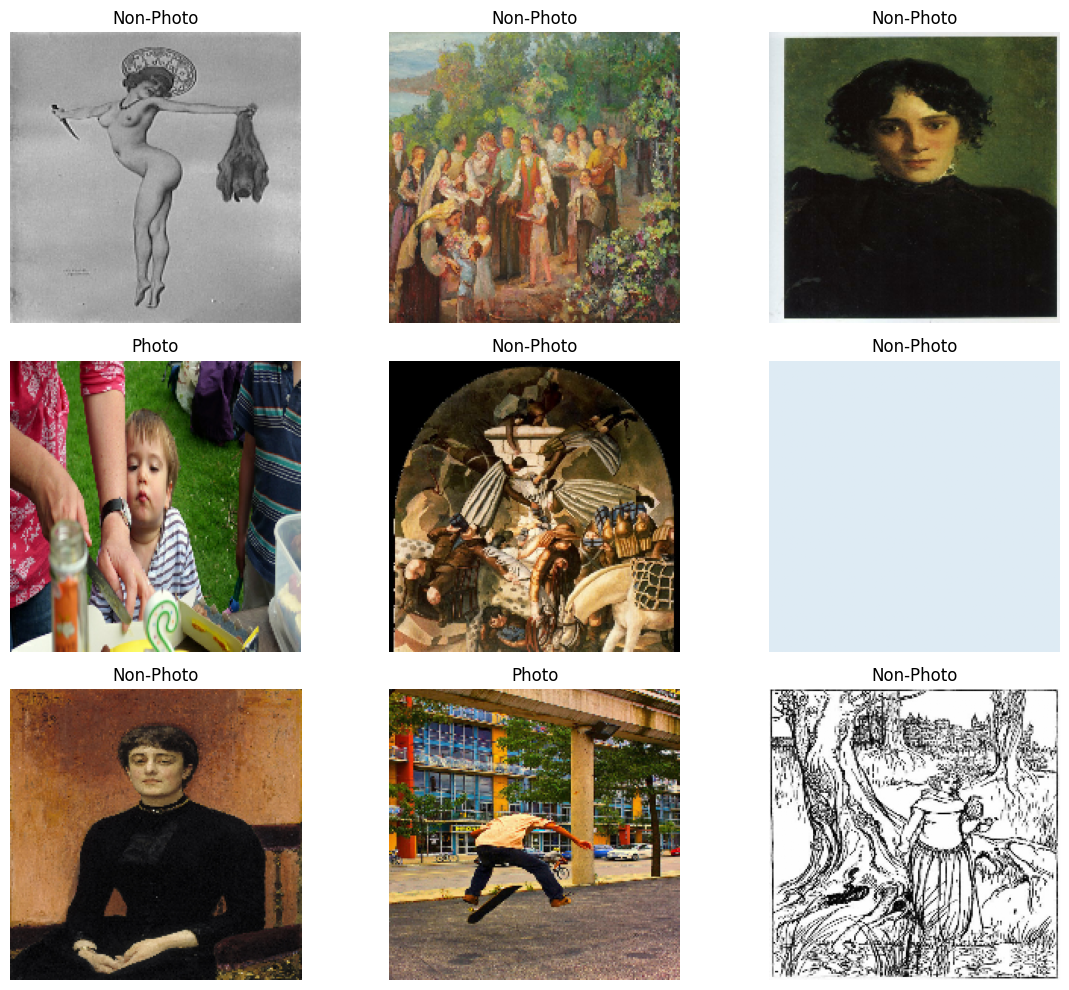

In [7]:
# Vérifier si les datasets originaux ont été chargés avant de tenter le prétraitement
datasets_loaded_successfully = ('train_set_ori' in locals() and train_set_ori) and \
                             ('val_set_ori' in locals() and val_set_ori) and \
                             ('test_set_ori' in locals() and test_set_ori)

if datasets_loaded_successfully:
    # Afficher les noms de classes initiaux pour référence (déjà fait, mais rappel)
    print("Noms de classes initiaux (rappel):", train_set_ori.class_names)

    # Noms des classes cibles APRÈS le mappage binaire 0/1
    target_class_names = ["Non-Photo", "Photo"] # 0 -> Non-Photo, 1 -> Photo
    print("Noms des classes binaires cibles (après prétraitement):", target_class_names)

    # --- Prétraitement ---
    print("\nApplication du prétraitement ORIGINAL...")
    print("   - Mappage : Étiquette initiale 1 -> 1 (Photo), Autres étiquettes -> 0 (Non-Photo)")
    print("   - Mise à l'échelle : Pixels divisés par 255.0")
    AUTOTUNE = tf.data.AUTOTUNE # Pour optimiser l'exécution de .map()

    # --- Utilisation de la fonction EXACTE du notebook original --- 
    def preprocess_binary_class(image, label):
        """
        Fonction originale restaurée.
        Convertit l'étiquette en binaire (1 si étiquette initiale == 1, sinon 0).
        Met à l'échelle les pixels de l'image par 1/255.0.
        """
        # Hypothèse : l'étiquette entière 1 correspond à 'Photo'.
        binary_label = tf.where(label == 1, 1, 0)

        # Mettre l'image à l'échelle [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Cast de l'étiquette binaire finale en float32 et ajout d'une dimension
        binary_label = tf.cast(binary_label, tf.float32)
        binary_label = tf.expand_dims(binary_label, axis=-1)

        return image, binary_label
    # --- Fin de la fonction originale --- 

    # Appliquer la fonction de prétraitement originale aux trois datasets
    # PAS de .cache().prefetch() puisque fait planter le conteneur docker (problème de mémoire)
    train_set = train_set_ori.map(preprocess_binary_class, num_parallel_calls=AUTOTUNE)
    val_set = val_set_ori.map(preprocess_binary_class, num_parallel_calls=AUTOTUNE)
    test_set = test_set_ori.map(preprocess_binary_class, num_parallel_calls=AUTOTUNE)
    print("Prétraitement original appliqué aux trois ensembles de données.")

    # --- Visualisation d'un échantillon après prétraitement --- 
    print("\nVisualisation d'un lot de données d'entraînement après prétraitement...")
    plt.figure(figsize=(12, 10))
    try:
        # Prendre un lot du `train_set` final (prétraité)
        for images, labels in train_set.take(1):
            print(f"  Formes des lots : Images={images.shape}, Étiquettes={labels.shape}")
            print(f"  Type données Images : {images.dtype}, Étiquettes : {labels.dtype}")
            print(f"  Exemple d'étiquette (tenseur) : {labels[0]}")
            print(f"  Exemple d'étiquette (valeur) : {labels[0].numpy()[0]}") # Devrait être 0.0 ou 1.0

            # Afficher jusqu'à 9 images du lot
            for i in range(min(9, images.shape[0])):
                ax = plt.subplot(3, 3, i + 1)
                # Afficher l'image (pixels sont déjà dans [0, 1] grâce au prétraitement)
                plt.imshow(images[i].numpy())

                # Obtenir l'index de l'étiquette binaire (0 ou 1)
                label_index = int(labels[i].numpy()[0])
                # Afficher le nom de classe correspondant
                plt.title(target_class_names[label_index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
    except Exception as viz_error:
        print(f"Erreur lors de la visualisation : {viz_error}")
        print("Cela peut arriver si les datasets sont vides ou si une erreur s'est produite lors du .map().")

else:
    print("Saut du prétraitement et de la visualisation car les datasets initiaux (`..._ori`) n'ont pas été chargés.")

### Définition des Architectures de Modèles

**Quoi :** Définit les plans (architectures) des différents modèles de réseaux de neurones convolutifs (CNN) qui seront entraînés et comparés.

**Comment :**
1.  **Métriques Communes (`COMMON_METRICS`) :** Une liste contenant les métriques standard (`BinaryAccuracy`, `AUC`, `Precision`, `Recall`) est définie. Tous les modèles seront compilés avec ces mêmes métriques pour permettre une comparaison directe et équitable de leurs performances.
2.  **Augmentation de Données (`data_augmentation`) :** Un petit modèle séquentiel Keras est créé pour regrouper les couches d'augmentation de données (`RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomContrast`). Cette séquence sera appliquée comme première étape *à l'intérieur* de chaque modèle défini ci-dessous. L'augmentation est généralement appliquée uniquement pendant la phase d'entraînement pour introduire de la variabilité et améliorer la capacité du modèle à généraliser.
3.  **Fonctions de Construction (`build_...`) :** Quatre fonctions distinctes sont définies, chacune responsable de la construction d'une architecture spécifique :
    *   `build_efficientnet_like` : Inspiré d'EfficientNet, utilisant des convolutions séparables en profondeur (`SeparableConv2D`) pour l'efficacité et des blocs `se_block` (Squeeze-and-Excitation) pour améliorer la sélection des caractéristiques pertinentes.
    *   `build_googlenet_like` : Une version très simplifiée inspirée de GoogLeNet, utilisant des convolutions standards de différentes tailles et du pooling. (Ne contient pas les modules Inception complexes de l'original).
    *   `build_ResNetLite_model` : Construit un modèle inspiré de ResNet, utilisant des blocs `build_resnet_style_block`. La caractéristique clé de ResNet est l'utilisation de connexions résiduelles (`shortcut = layers.Add()`), qui permettent d'entraîner des réseaux plus profonds en facilitant la propagation du gradient.
    *   `build_densenet_like` : Inspiré de DenseNet. Dans chaque `dense_block`, la sortie de chaque couche est concaténée aux entrées des couches suivantes, favorisant une réutilisation intensive des caractéristiques. Des `transition_layer` sont utilisés pour réduire la dimensionnalité entre les blocs.
    *   **Structure Commune :** Chaque fonction `build_...` :
        *   Prend `image_h` et `image_w` en arguments.
        *   Définit une couche d'entrée (`layers.Input`).
        *   Applique la `data_augmentation`.
        *   N'inclut **PAS** de couche `Rescaling` (car la mise à l'échelle est faite dans `preprocess_binary_class`).
        *   Construit le corps principal de l'architecture.
        *   Ajoute une "tête" de classification commune : `GlobalAveragePooling2D` (réduit la carte de caractéristiques spatiales en un vecteur), suivi de couches `Dense` avec `BatchNormalization` et `Dropout` pour la régularisation, et enfin une couche `Dense(1, activation='sigmoid')` pour la sortie de probabilité binaire.
        *   Compile le modèle avec l'optimiseur Adam (taux d'apprentissage `1e-4`), la perte `BinaryCrossentropy` (adaptée à la classification binaire avec sortie sigmoïde), et les `COMMON_METRICS`.
4.  **Vérification :** Un modèle exemple est construit et sa structure est affichée avec `model.summary()` pour une vérification rapide.

**Pourquoi :**
*   **Exploration Architecturale :** Permet de tester et comparer différentes approches de conception de CNNs pour déterminer laquelle est la plus performante sur ce problème spécifique.
*   **Régularisation et Généralisation :** L'intégration de l'augmentation de données, du `Dropout`, et potentiellement de la régularisation L2 (`kernel_regularizer`) dans les couches denses vise à réduire le surapprentissage et à améliorer la capacité du modèle à bien performer sur de nouvelles images.
*   **Standardisation pour Comparaison :** L'utilisation d'un optimiseur, d'une fonction de perte, de métriques, et d'une tête de classification similaires facilite la comparaison des performances intrinsèques des différentes architectures de base.

In [ ]:
# --- Métriques Communes ---
# Définir une liste de métriques standard qui seront utilisées pour évaluer tous les modèles.
COMMON_METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'), # Pourcentage de prédictions correctes
    tf.keras.metrics.AUC(name='auc'),                 # Aire sous la Courbe ROC: mesure globale de discrimination
    tf.keras.metrics.Precision(name='precision'),     # TP / (TP + FP): précision des prédictions positives
    tf.keras.metrics.Recall(name='recall')            # TP / (TP + FN): sensibilité, capacité à trouver les positifs
]
print(f"Métriques communes pour la compilation définies: {[m.name for m in COMMON_METRICS]}")

# --- Pipeline d'Augmentation de Données ---
# Créer un modèle séquentiel contenant les couches d'augmentation.
# Ces transformations sont appliquées aléatoirement aux images pendant l'entraînement uniquement.
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),                # Inversion horizontale aléatoire (gauche/droite)
    # layers.RandomFlip("vertical"),              # Inversion verticale (haut/bas) - Moins courant pour photos/peintures
    layers.RandomRotation(0.1),                     # Rotation aléatoire entre -10% et +10% de 360 degrés
    layers.RandomZoom(0.1),                         # Zoom aléatoire uniforme (facteur entre 0.9 et 1.1)
    layers.RandomContrast(0.1),                     # Ajustement aléatoire du contraste (facteur entre 0.9 et 1.1)
    # layers.RandomBrightness(0.1),                 # Ajustement aléatoire de la luminosité (optionnel)
], name="data_augmentation")
print("Pipeline d'augmentation de données (RandomFlip, Rotation, Zoom, Contrast) défini.")

# --- 1. Modèle Type EfficientNet ---
def se_block(input_tensor, reduction=16, name_prefix='se'):
    """Bloc Squeeze-and-Excitation."""
    filters = input_tensor.shape[-1]
    x = layers.GlobalAveragePooling2D(name=f'{name_prefix}_squeeze')(input_tensor)
    se_filters = max(1, filters // reduction)
    x = layers.Dense(se_filters, activation='relu', name=f'{name_prefix}_excite1')(x)
    x = layers.Dense(filters, activation='sigmoid', name=f'{name_prefix}_excite2')(x)
    return layers.Multiply(name=f'{name_prefix}_scale')([input_tensor, x])

def conv_block(x, filters, kernel_size=3, se=False, name_prefix='conv'):
    """Bloc convolutif utilisant SeparableConv2D, BN, ReLU, et optionnellement SE."""
    x = layers.SeparableConv2D(filters, kernel_size, padding="same", use_bias=False, name=f'{name_prefix}_sepconv')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu')(x)
    if se:
        x = se_block(x, name_prefix=f'{name_prefix}_se')
    return x

def build_efficientnet_like(image_h, image_w):
    """Construit un modèle inspiré d'EfficientNet avec augmentation."""
    inputs = layers.Input(shape=(image_h, image_w, 3), name='input_layer')
    x = data_augmentation(inputs) # Appliquer l'augmentation en premier

    # Tronc (Stem)
    x = conv_block(x, 32, 3, name_prefix='stem')

    # Blocs principaux
    x = conv_block(x, 64, 3, se=True, name_prefix='block1')
    x = layers.MaxPooling2D(name='pool1')(x)
    x = conv_block(x, 128, 3, se=True, name_prefix='block2')
    x = layers.MaxPooling2D(name='pool2')(x)
    x = conv_block(x, 256, 3, se=True, name_prefix='block3')
    x = layers.MaxPooling2D(name='pool3')(x)
    x = conv_block(x, 512, 3, se=True, name_prefix='block4')

    # Tête de classification
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001), name='dense_1')(x)
    x = layers.BatchNormalization(name='dense_1_bn')(x)
    x = layers.Dropout(0.4, name='dropout_1')(x) # Taux de dropout modéré
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001), name='dense_2')(x)
    x = layers.BatchNormalization(name='dense_2_bn')(x)
    x = layers.Dropout(0.5, name='dropout_2')(x) # Taux de dropout plus élevé avant la sortie
    outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(x)

    model = models.Model(inputs, outputs, name="EfficientNet-Like")
    # Compilation standard
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=COMMON_METRICS
    )
    return model

# --- 2. Modèle Type GoogLeNet ---
def build_googlenet_like(image_h, image_w):
    """Construit un modèle très simplifié inspiré de GoogLeNet avec augmentation."""
    inputs = layers.Input(shape=(image_h, image_w, 3), name='input_layer')
    x = data_augmentation(inputs) # Appliquer l'augmentation

    # Bloc initial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', name='conv1_7x7')(x)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1')(x)

    # Séquence de convolutions (remplacement très simple d'Inception)
    x = layers.Conv2D(64, kernel_size=1, strides=1, padding='same', name='conv2_1x1')(x)
    x = layers.Conv2D(192, kernel_size=3, strides=1, padding='same', name='conv2_3x3')(x)
    x = layers.BatchNormalization(name='conv2_bn')(x)
    x = layers.Activation('relu', name='conv2_relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool2')(x)

    # Blocs suivants
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', name='conv3_3x3')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool3')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu', name='conv4a_3x3')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu', name='conv4b_3x3')(x)

    # Tête de classification (très simple vs original GoogLeNet)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dropout(0.4, name='dropout_final')(x) # Dropout avant la couche finale
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="GoogLeNet-Like")
    # Compilation standard
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=COMMON_METRICS
    )
    return model

# --- 3. Modèle Type ResNet ---
def build_resnet_style_block(input_tensor, filters, stage, block, strides=(1, 1), dropout_rate=0.1):
    """Crée un bloc de style ResNet avec pré-activation BatchNorm."""
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    # Chemin du raccourci (shortcut)
    shortcut = input_tensor
    # Projection si les dimensions changent (strides ou nombre de filtres)
    if strides != (1, 1) or input_tensor.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, (1, 1), strides=strides, name=conv_name_base + '1', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    # Chemin principal (pré-activation : BN -> ReLU -> Conv)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(input_tensor)
    x = layers.Activation('relu', name=f'act{stage}{block}_2a')(x)
    x = layers.Conv2D(filters, (1, 1), strides=strides, name=conv_name_base + '2a', use_bias=False)(x)

    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu', name=f'act{stage}{block}_2b')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', name=conv_name_base + '2b', use_bias=False)(x)

    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)
    x = layers.Activation('relu', name=f'act{stage}{block}_2c')(x)
    x = layers.Conv2D(filters * 4, (1, 1), name=conv_name_base + '2c', use_bias=False)(x) # Expansion Bottleneck

    # Spatial Dropout
    if dropout_rate > 0:
      x = layers.SpatialDropout2D(dropout_rate, name=f'sp_dropout{stage}{block}')(x)

    # Ajout du raccourci
    x = layers.Add(name=f'add{stage}{block}')([x, shortcut])
    # Note: Dans ResNet original, l'activation finale du bloc vient *après* l'addition.
    # Ici, l'architecture fournie a la pré-activation partout.
    return x

def build_ResNetLite_model(image_h, image_w):
    """Construit le modèle ResNet-Like fourni, avec augmentation intégrée."""
    inputs = layers.Input(shape=(image_h, image_w, 3), name='input_layer')
    x = data_augmentation(inputs) # Appliquer l'augmentation

    # Couche Conv initiale de ResNet
    x_pad = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x_conv = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1_conv', use_bias=False)(x_pad)
    x_bn = layers.BatchNormalization(name='conv1_bn')(x_conv)
    x_act = layers.Activation('relu', name='conv1_relu')(x_bn)
    x_pad_pool = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x_act)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x_pad_pool)

    # Blocs ResNet
    # Stage 2
    x = build_resnet_style_block(x, 64, stage=2, block='a', strides=(1,1), dropout_rate=0.1)
    x = build_resnet_style_block(x, 64, stage=2, block='b', dropout_rate=0.1)
    # Stage 3
    x = build_resnet_style_block(x, 128, stage=3, block='a', strides=(2,2), dropout_rate=0.2)
    x = build_resnet_style_block(x, 128, stage=3, block='b', dropout_rate=0.2)
    # Stage 4
    x = build_resnet_style_block(x, 256, stage=4, block='a', strides=(2,2), dropout_rate=0.3)
    x = build_resnet_style_block(x, 256, stage=4, block='b', dropout_rate=0.3)
    # Stage 5
    x = build_resnet_style_block(x, 512, stage=5, block='a', strides=(2,2), dropout_rate=0.4)
    x = build_resnet_style_block(x, 512, stage=5, block='b', dropout_rate=0.4)

    # Tête de classification
    # Ici on suit le style pré-activation + ajout.
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='dense_1')(x)
    x = layers.BatchNormalization(name='dense_1_bn')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ResNet-Like")
    # Compilation standard
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=COMMON_METRICS
    )
    return model

# --- 4. Modèle Type DenseNet ---
def bn_relu_conv(x, filters, kernel_size, strides=1, name=None):
    """Applique BN -> ReLU -> Conv."""
    x = layers.BatchNormalization(name=f'{name}_bn')(x)
    x = layers.ReLU(name=f'{name}_relu')(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, name=f'{name}_conv')(x)
    return x

def dense_block(x, num_layers, growth_rate, name, dropout_rate=0.0):
    """Construit un bloc dense où chaque couche est concaténée aux suivantes."""
    for i in range(num_layers):
        # Couche Bottleneck (1x1 conv pour réduire les filtres)
        inter_channel = 4 * growth_rate
        y = bn_relu_conv(x, filters=inter_channel, kernel_size=1, name=f'{name}_layer{i}_btlnk')
        # Couche Conv principale (3x3 conv)
        y = bn_relu_conv(y, filters=growth_rate, kernel_size=3, name=f'{name}_layer{i}_conv')
        if dropout_rate > 0.0:
            y = layers.Dropout(dropout_rate, name=f'{name}_layer{i}_dropout')(y)
        # Concaténer la sortie avec l'entrée du bloc
        x = layers.Concatenate(axis=-1, name=f'{name}_layer{i}_concat')([x, y])
    return x

def transition_layer(x, reduction, name):
    """Construit une couche de transition pour réduire la dimensionnalité entre les blocs denses."""
    # Calculer le nombre de filtres après réduction
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    # Appliquer BN -> ReLU -> Conv 1x1
    x = bn_relu_conv(x, filters=filters, kernel_size=1, name=f'{name}_conv')
    # Appliquer un Average Pooling pour réduire la taille spatiale
    x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same', name=f'{name}_pool')(x)
    return x

def build_densenet_like(image_h, image_w):
    """Construit un modèle inspiré de DenseNet avec augmentation."""
    inputs = layers.Input(shape=(image_h, image_w, 3), name="input_layer")
    x = data_augmentation(inputs) # Appliquer l'augmentation

    # Couche Conv initiale (souvent plus large dans DenseNet)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name="initial_conv")(x)
    x = layers.BatchNormalization(name="initial_bn")(x)
    x = layers.Activation('relu', name="initial_relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name="initial_pool")(x)

    # Blocs Denses & Couches de Transition
    growth_rate = 32 # Nombre de filtres ajoutés par chaque couche dans un bloc dense
    x = dense_block(x, num_layers=4, growth_rate=growth_rate, name="dense_block1", dropout_rate=0.1)
    x = transition_layer(x, reduction=0.5, name="transition1") # Réduit le nombre de filtres de moitié
    x = dense_block(x, num_layers=6, growth_rate=growth_rate, name="dense_block2", dropout_rate=0.1)
    x = transition_layer(x, reduction=0.5, name="transition2")
    x = dense_block(x, num_layers=8, growth_rate=growth_rate, name="dense_block3", dropout_rate=0.2)
    x = transition_layer(x, reduction=0.5, name="transition3")
    x = dense_block(x, num_layers=8, growth_rate=growth_rate, name="dense_block4", dropout_rate=0.3)

    # Normalisation finale avant Global Pooling (standard dans DenseNet)
    x = layers.BatchNormalization(name="final_bn")(x)
    x = layers.Activation('relu', name="final_relu")(x)

    # Tête de classification (Cohérente avec les autres modèles)
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="dense_1")(x)
    x = layers.BatchNormalization(name="dense_1_bn")(x)
    x = layers.Dropout(0.5, name="dropout_1")(x)
    outputs = layers.Dense(1, activation='sigmoid', name="output_layer")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="DenseNet-Like")
    # Compilation standard
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=COMMON_METRICS
    )
    return model

# --- Tester la construction d'un modèle exemple (EfficientNet-like) ---
print("\nConstruction d'un modèle exemple (EfficientNet-Like) pour vérifier la structure...")
try:
    h_test, w_test = (image_h, image_w) if 'image_h' in locals() else (192, 192)
    sample_model_eff = build_efficientnet_like(h_test, w_test)
    print(f"--- Résumé {sample_model_eff.name} ---")
    sample_model_eff.summary(line_length=110)
    del sample_model_eff # Libérer la mémoire
    print("Construction du modèle exemple (EfficientNet-Like) réussie.")

    # Tester aussi ResNet pour vérifier le bloc custom
    sample_model_res = build_ResNetLite_model(h_test, w_test)
    print(f"\n--- Résumé {sample_model_res.name} ---")
    sample_model_res.summary(line_length=110)
    del sample_model_res
    print("Construction du modèle exemple (ResNet-Like) réussie.")

except Exception as e:
    print(f"Erreur lors de la construction d'un modèle exemple : {e}")

Métriques communes pour la compilation définies: ['accuracy', 'auc', 'precision', 'recall']
Pipeline d'augmentation de données (RandomFlip, Rotation, Zoom, Contrast) défini.

Construction d'un modèle exemple (EfficientNet-Like) pour vérifier la structure...
--- Résumé EfficientNet-Like ---
Model: "EfficientNet-Like"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input_layer (InputLayer)        [(None, 192, 192, 3)]            0          []                               
                                                                                                              
 data_augmentation (Sequential)  (None, 192, 192, 3)              0          ['input_layer[0][0]']            
                                                                                                              
 stem_sepconv (S

### Préparation de l'entraînement : Callbacks et Poids de Classe

**Quoi :** Configure des mécanismes pour améliorer et contrôler le processus d'entraînement, et pour adresser un potentiel déséquilibre entre les classes 'Photo' et 'Non-Photo' dans les données d'entraînement.

**Comment :**
1.  **Callbacks (Rappels) :** Des objets qui exécutent des actions à différentes étapes de l'entraînement.
    *   `ReduceLROnPlateau` : Surveille la perte de validation (`val_loss`). Si elle ne diminue pas pendant `patience=3` époques, le taux d'apprentissage de l'optimiseur est réduit d'un facteur `factor=0.2`. Cela permet au modèle de converger plus précisément vers un minimum local lorsque l'apprentissage ralentit.
    *   `EarlyStopping` : Surveille l'AUC de validation (`val_auc`). Si cette métrique ne s'améliore pas (`mode='max'`) pendant `patience=7` époques, l'entraînement est arrêté prématurément. `restore_best_weights=True` assure que les poids du modèle sont réinitialisés à ceux de l'époque où `val_auc` était maximal, évitant ainsi de garder les poids d'époques ultérieures potentiellement sur-apprises.
    *   *Note :* `ModelCheckpoint`, qui sauvegarde le meilleur modèle sur disque, sera défini séparément pour chaque modèle dans la boucle d'entraînement pour avoir des fichiers distincts.
2.  **Poids de Classe (`class_weight`) :**
    *   Cette technique vise à compenser un déséquilibre dans le nombre d'images entre les classes (par exemple, beaucoup plus de 'Non-Photo' que de 'Photo').
    *   On extrait d'abord les étiquettes (0 ou 1) de l'ensemble d'entraînement (`train_set`).
    *   `sklearn.utils.class_weight.compute_class_weight('balanced', ...)` calcule ensuite un poids pour chaque classe. Le mode `'balanced'` donne un poids plus élevé à la classe la moins fréquente (minoritaire) et un poids plus faible à la classe la plus fréquente (majoritaire). Les poids sont inversement proportionnels à la fréquence des classes.
    *   Ces poids sont stockés dans un dictionnaire (`class_weight_dict`). Lors de l'appel à `model.fit()`, ce dictionnaire indique à la fonction de perte de pondérer différemment les erreurs : une erreur sur un exemple de la classe minoritaire (qui a un poids plus élevé) contribuera davantage à la perte totale qu'une erreur sur un exemple de la classe majoritaire.
    *   **Alternative :** D'autres méthodes pour gérer le déséquilibre existent, comme le sur-échantillonnage (répéter des exemples de la classe minoritaire) ou le sous-échantillonnage (retirer des exemples de la classe majoritaire). La pondération des classes est souvent préférée car elle n'altère pas la distribution originale des données et n'augmente/diminue pas artificiellement la taille du dataset.

**Pourquoi :**
*   **Optimisation de l'Entraînement :** Les callbacks rendent l'entraînement plus intelligent, en adaptant le taux d'apprentissage et en évitant le calcul inutile et le surapprentissage grâce à l'arrêt anticipé.
*   **Équité envers les Classes :** Sans gestion du déséquilibre, le modèle pourrait obtenir une bonne précision globale simplement en prédisant toujours la classe majoritaire. La pondération force le modèle à prêter une attention proportionnellement plus grande à la classe minoritaire, améliorant souvent des métriques comme le Rappel (Recall) ou le F1-Score pour cette classe.

In [9]:
# --- Callbacks Communs (appliqués à l'entraînement de chaque modèle) ---
print("Définition des callbacks communs...")

# Callback pour réduire le taux d'apprentissage (Learning Rate) si la perte de validation stagne
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Métrique à surveiller
    factor=0.2,              # Facteur de réduction du LR (LR = LR * factor)
    patience=3,              # Nb d'époques sans amélioration avant réduction
    min_lr=1e-6,             # Plancher pour le taux d'apprentissage
    verbose=1                # Afficher un message quand le LR est réduit
)
print(" -> ReduceLROnPlateau défini (monitor='val_loss', patience=3, factor=0.2)")

# Callback pour arrêter l'entraînement prématurément si l'AUC de validation ne s'améliore plus
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',           # Métrique à surveiller
    patience=7,                  # Nb d'époques sans amélioration avant arrêt
    restore_best_weights=True,   # Revenir aux poids de la meilleure époque à la fin
    mode='max',                  # L'AUC doit être maximisée
    verbose=1                    # Afficher un message lors de l'arrêt
)
print(" -> EarlyStopping défini (monitor='val_auc', patience=7, restore_best_weights=True)")

# --- Calcul des Poids de Classe (pour gérer le déséquilibre) ---
class_weight_dict = None # Initialisation

# Vérifier si le dataset d'entraînement prétraité existe
if 'train_set' in locals() and train_set:
    print("\nCalcul des poids de classe à partir de l'ensemble d'entraînement prétraité...")
    try:
        # 1. Extraire toutes les étiquettes (déjà binaires 0.0 ou 1.0)
        train_labels = np.concatenate([y.numpy() for _, y in train_set], axis=0).flatten()
        print(f"   -> {len(train_labels)} étiquettes extraites.")

        # 2. Trouver les classes uniques présentes (devrait être 0.0 et 1.0)
        unique_labels = np.unique(train_labels)
        print(f"   -> Étiquettes uniques trouvées : {unique_labels}")

        # 3. Calculer les poids seulement si on a bien DEUX classes et qu'elles sont PROCHES de 0.0 et 1.0
        if len(unique_labels) == 2 and np.allclose(unique_labels, [0., 1.]):
            class_weights_array = class_weight.compute_class_weight(
                class_weight='balanced', # Mode de calcul: inversement proportionnel à la fréquence
                classes=unique_labels,   # Les classes présentes: [0., 1.]
                y=train_labels           # Les étiquettes sur lesquelles calculer les fréquences
            )

            # 4. Créer un dictionnaire {classe_int: poids_float} pour Keras
            class_weight_dict = {
                int(cls): weight for cls, weight in zip(unique_labels, class_weights_array)
            }
            # **CORRECTION : Indentation correcte pour les lignes suivantes**
            # Formatter l'affichage des poids
            weights_str = ", ".join([f"Classe {k}: {v:.3f}" for k, v in class_weight_dict.items()])
            print(f"   -> Poids de classe calculés : {{{weights_str}}}")
            print("      (La classe minoritaire aura un poids > 1, la majoritaire < 1)")

        # **CORRECTION : Garder UN SEUL elif pour ce cas**
        elif len(unique_labels) == 1:
            print(f"   -> AVERTISSEMENT : Une seule classe ({unique_labels[0]}) trouvée. Déséquilibre extrême ou erreur. Poids de classe non appliqués.")
            class_weight_dict = None

        # **CORRECTION : Ajouter un else pour tous les autres cas invalides**
        else:
            print(f"   -> AVERTISSEMENT : Les étiquettes uniques trouvées ({unique_labels}) ne sont pas [0., 1.] ou il y a plus de 2 classes. Problème potentiel. Poids de classe non appliqués.")
            class_weight_dict = None

    except Exception as e:
        print(f"   -> ERREUR lors du calcul des poids de classe : {e}. Entraînement sans poids de classe.")
        class_weight_dict = None
else:
    print("\nAvertissement : Ensemble d'entraînement (`train_set`) non disponible. Impossible de calculer les poids de classe.")

Définition des callbacks communs...
 -> ReduceLROnPlateau défini (monitor='val_loss', patience=3, factor=0.2)
 -> EarlyStopping défini (monitor='val_auc', patience=7, restore_best_weights=True)

Calcul des poids de classe à partir de l'ensemble d'entraînement prétraité...
   -> 28458 étiquettes extraites.
   -> Étiquettes uniques trouvées : [0. 1.]
   -> Poids de classe calculés : {Classe 0: 0.662, Classe 1: 2.040}
      (La classe minoritaire aura un poids > 1, la majoritaire < 1)


### Fonction d'Affichage de l'Historique d'Entraînement

**Quoi :** Définit la fonction `plot_training_history` qui génère un ensemble de graphiques pour visualiser l'évolution des métriques d'entraînement et de validation au fil des époques.

**Comment :**
1.  **Entrées :** Prend l'objet `history` (retourné par `model.fit`, contenant les métriques par époque) et `model_name` (pour les titres).
2.  **Extraction des Métriques :** Récupère les listes de valeurs pour chaque métrique (`accuracy`, `loss`, `auc`, `precision`, `recall`) et leurs équivalents de validation (`val_*`) à partir du dictionnaire `history.history`.
3.  **Calcul du F1-Score :** Si `precision` et `recall` sont disponibles, calcule le F1-score pour l'entraînement et la validation pour chaque époque.
4.  **Préparation du Tracé :** Détermine le nombre d'époques et crée une figure `matplotlib` avec une grille de sous-graphiques (`subplots`) adaptée au nombre de visualisations à générer.
5.  **Tracé des Courbes :** Pour chaque métrique principale (Accuracy, Loss, AUC, F1-Score) et pour le couple Précision/Rappel :
    *   Crée un sous-graphique.
    *   Trace la courbe d'entraînement (généralement en bleu/pointillé).
    *   Trace la courbe de validation (généralement en orange/plein).
    *   Identifie et marque (point rouge) l'époque où la métrique de *validation* a atteint sa meilleure valeur (max pour acc/auc/prec/recall/f1, min pour loss).
    *   Ajoute titre, étiquettes d'axes et légende.
6.  **Tracé du Taux d'Apprentissage :** Si l'information 'lr' est présente dans l'historique (ajoutée par `ReduceLROnPlateau`), trace son évolution sur un graphique séparé.
7.  **Affichage :** Ajuste la mise en page (`tight_layout`) et affiche la figure complète (`plt.show()`).

**Pourquoi :**
*   **Diagnostic Visuel :** Ces graphiques sont l'outil principal pour comprendre comment l'entraînement s'est déroulé.
*   **Détection de Problèmes :** Permet d'identifier facilement le surapprentissage (écart croissant train/val), le sous-apprentissage (les deux courbes stagnent bas), l'instabilité (courbes très bruitées), ou une convergence réussie (les deux courbes convergent vers de bonnes valeurs).
*   **Analyse Comparative :** Bien que chaque modèle ait son propre graphique, comparer visuellement les formes des courbes entre différents modèles peut donner des indices sur leur vitesse de convergence ou leur tendance au surapprentissage.
*   **Validation des Callbacks :** Confirme que `ReduceLROnPlateau` a bien réduit le LR ou qu'`EarlyStopping` a interrompu l'entraînement à un point pertinent.

In [10]:
def plot_training_history(history, model_name="Modèle"):
    """
    Affiche les graphiques des métriques d'entraînement et de validation.
    Prend en entrée l'objet 'history' retourné par model.fit() ou un dictionnaire équivalent.
    """
    
    # Extraire le dictionnaire de l'historique s'il est passé comme objet History
    hist_dict = history.history if hasattr(history, 'history') else history
    
    print(f"    -> Métriques disponibles pour le tracé : {list(hist_dict.keys())}")
    
    # Liste des métriques principales à tracer et leurs équivalents de validation
    metric_plot_config = {
        'Accuracy': ('accuracy', 'val_accuracy'),
        'Loss': ('loss', 'val_loss'),
        'AUC': ('auc', 'val_auc'),
        'Precision & Recall': [('precision', 'val_precision'), ('recall', 'val_recall')],
    }
    
    # Vérifier et préparer les données pour F1 et LR
    f1_data = None
    if 'precision' in hist_dict and 'recall' in hist_dict and 'val_precision' in hist_dict and 'val_recall' in hist_dict:
        prec = hist_dict['precision']
        rec = hist_dict['recall']
        val_prec = hist_dict['val_precision']
        val_rec = hist_dict['val_recall']
        f1_train = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(prec, rec)]
        f1_val = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(val_prec, val_rec)]
        f1_data = {'train': f1_train, 'val': f1_val}
        metric_plot_config['F1-Score'] = ('f1', 'val_f1') # Placeholder keys

    lr_data = hist_dict.get('lr')
    if lr_data:
         metric_plot_config['Learning Rate'] = ('lr', None) # Placeholder keys

    # Déterminer le nombre d'époques
    # Trouver une clé existante pour obtenir la longueur
    epochs = 0
    for key in ['loss', 'accuracy', 'auc']: # Chercher une clé fiable
        if key in hist_dict:
            epochs = len(hist_dict[key])
            break
    if epochs == 0:
        print("      Erreur: Impossible de déterminer le nombre d'époques à partir de l'historique.")
        return
    epochs_range = range(1, epochs + 1)
    
    # Créer la figure
    num_plots = len(metric_plot_config)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)
    plt.figure(figsize=(8 * num_cols, 5 * num_rows))
    plt.suptitle(f'Historique d\'Entraînement : {model_name} ({epochs} Époques)', fontsize=18, y=1.03)
    plot_index = 1

    # --- Boucle de traçage --- 
    for title, keys in metric_plot_config.items():
        plt.subplot(num_rows, num_cols, plot_index)
        
        if title == 'Precision & Recall':
            # Tracé spécial pour Precision et Recall ensemble
            prec_key, val_prec_key = keys[0]
            rec_key, val_rec_key = keys[1]
            if prec_key in hist_dict and val_prec_key in hist_dict:
                plt.plot(epochs_range, hist_dict[prec_key], label='Précision (Entr.)', color='cyan', linestyle='--', linewidth=1.5)
                plt.plot(epochs_range, hist_dict[val_prec_key], label='Précision (Val.)', color='blue', linestyle='-', linewidth=1.5)
            if rec_key in hist_dict and val_rec_key in hist_dict:
                 plt.plot(epochs_range, hist_dict[rec_key], label='Rappel (Entr.)', color='magenta', linestyle='--', linewidth=1.5)
                 plt.plot(epochs_range, hist_dict[val_rec_key], label='Rappel (Val.)', color='red', linestyle='-', linewidth=1.5)
            plt.ylabel('Score', fontsize=12)
            
        elif title == 'F1-Score':
            if f1_data:
                plt.plot(epochs_range, f1_data['train'], label='F1-Score (Entr.)', color='blue', linewidth=1.5)
                plt.plot(epochs_range, f1_data['val'], label='F1-Score (Val.)', color='orange', linewidth=1.5)
                best_epoch_f1 = np.argmax(f1_data['val'])
                best_val_f1 = f1_data['val'][best_epoch_f1]
                plt.scatter(best_epoch_f1 + 1, best_val_f1, color='red', s=80, label=f'Meilleur Val F1 ({best_val_f1:.3f})', zorder=5)
            plt.ylabel('F1-Score', fontsize=12)
            
        elif title == 'Learning Rate':
            if lr_data:
                plt.plot(epochs_range, lr_data, label='Taux d\'apprentissage', color='purple', marker='.', linestyle='-')
            plt.ylabel('Taux d\'apprentissage', fontsize=12)
            plt.yscale('log') # Échelle logarithmique souvent utile pour le LR
        
        else: # Cas général (Accuracy, Loss, AUC)
            train_key, val_key = keys
            if train_key in hist_dict and val_key in hist_dict:
                plt.plot(epochs_range, hist_dict[train_key], label=f'{title} (Entr.)', color='blue', linewidth=1.5)
                plt.plot(epochs_range, hist_dict[val_key], label=f'{title} (Val.)', color='orange', linewidth=1.5)
                # Marquer la meilleure époque de validation
                best_epoch_val = np.argmax(hist_dict[val_key]) if title != 'Loss' else np.argmin(hist_dict[val_key])
                best_val = hist_dict[val_key][best_epoch_val]
                plt.scatter(best_epoch_val + 1, best_val, color='red', s=80, label=f'Meilleure Val ({best_val:.3f})', zorder=5)
            plt.ylabel(title, fontsize=12)

        # Configuration commune des sous-graphiques
        plt.title(f'{title} vs. Époque', fontsize=14, pad=10)
        plt.xlabel('Époque', fontsize=12)
        # Limiter l'axe Y pour la perte si elle devient très grande au début
        if title == 'Loss' and 'loss' in hist_dict:
             plt.ylim([0, min(np.percentile(hist_dict['loss'], 95)*2, 5)]) # Limiter y basé sur le 95e percentile
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.5)
        plot_index += 1
        
    # Ajuster la mise en page pour éviter les chevauchements
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

### Boucle d'Entraînement et d'Évaluation des Modèles

**Quoi :** Cette section orchestre l'entraînement, la sauvegarde, l'évaluation et la visualisation pour chaque architecture de modèle définie précédemment.

**Comment :**
1.  **Initialisation :** Prépare des dictionnaires pour stocker les informations de chaque modèle (`training_histories`, `test_results_all`, `best_model_paths`) et définit le nombre maximal d'époques.
2.  **Vérification Préalable :** Confirme que les datasets (`train_set`, `val_set`, `test_set`) sont bien chargés avant de lancer la boucle coûteuse en temps.
3.  **Boucle sur les Modèles :** Itère sur le dictionnaire `model_builders`.
    *   **Nettoyage de Session :** `tf.keras.backend.clear_session()` est crucial pour libérer les ressources (mémoire GPU/CPU, graphe de calcul) du modèle précédent avant de construire le suivant.
    *   **Construction du Modèle :** Appelle la fonction `builder_func` correspondante pour créer une nouvelle instance du modèle.
    *   **Chemin de Checkpoint Unique :** Crée un nom de fichier spécifique pour chaque modèle (ex: `best_resnet_like_model.keras`) dans le répertoire `checkpoints_dir`.
    *   **Callback `ModelCheckpoint` Spécifique :** Crée une instance de `ModelCheckpoint` qui sauvegardera *uniquement* les poids correspondant à la meilleure performance sur `val_auc` dans le fichier défini à l'étape précédente.
    *   **Entraînement (`model.fit`) :** Lance l'entraînement avec l'ensemble d'entraînement et de validation, le nombre d'époques max, la liste des callbacks (incluant `EarlyStopping`, `ReduceLROnPlateau`, et le `ModelCheckpoint` spécifique), et le dictionnaire `class_weight_dict` (qui peut être `None`).
    *   **Stockage de l'Historique :** L'objet `history` retourné par `fit` contient les métriques pour chaque époque ; son dictionnaire `.history` est stocké.
    *   **Chargement du Meilleur Modèle :** Après l'entraînement, le fichier `.keras` sauvegardé par `ModelCheckpoint` (contenant l'architecture et les meilleurs poids) est rechargé. C'est la manière la plus sûre d'obtenir le modèle au pic de performance de validation, même si `EarlyStopping` a aussi restauré des poids en mémoire.
    *   **Évaluation Finale (`model.evaluate`) :** Le *meilleur modèle chargé* est évalué sur l'ensemble de test (`test_set`), qui n'a jamais été utilisé pendant l'entraînement ou pour le checkpointing. Cela donne une estimation impartiale de la performance de généralisation.
    *   **Stockage des Résultats :** Les métriques obtenues sur l'ensemble de test sont stockées dans `test_results_all`, avec ajout manuel du F1-score (calculé à partir de precision/recall) et des informations sur la durée/époques d'entraînement.
    *   **Visualisation (Historique) :** Appel de `plot_training_history` pour afficher les courbes d'apprentissage du modèle actuel.
    *   **Visualisation (Matrice de Confusion) :**
        *   Le meilleur modèle chargé prédit les probabilités sur l'ensemble de test.
        *   Les probabilités sont converties en classes prédites (0 ou 1) avec un seuil de 0.5.
        *   Les vraies étiquettes sont extraites de l'ensemble de test.
        *   `sklearn.metrics.confusion_matrix` compare les vraies étiquettes et les prédictions.
        *   `seaborn.heatmap` est utilisé pour afficher la matrice de manière visuelle, montrant les Vrais Positifs, Vrais Négatifs, Faux Positifs, et Faux Négatifs.
    *   **Nettoyage Mémoire Final :** Un bloc `finally` assure que les objets `model`, `loaded_best_model`, et `history` sont supprimés (`del`) et que `clear_session` est appelé à nouveau, même si une erreur s'est produite, afin de maximiser la libération de mémoire avant le prochain tour de boucle.

**Pourquoi :**
*   **Processus Complet et Cohérent :** Assure que chaque modèle subit exactement le même processus d'entraînement, de sélection du meilleur état, et d'évaluation finale.
*   **Évaluation Impartiale :** L'évaluation sur un ensemble de test distinct est cruciale pour estimer comment le modèle performera sur de nouvelles données réelles.
*   **Analyse Détaillée par Modèle :** Fournit non seulement les métriques finales mais aussi une vue de la dynamique d'apprentissage (historique) et une répartition des erreurs de classification (matrice de confusion) pour chaque architecture.
*   **Robustesse et Gestion des Ressources :** L'utilisation de `try...except...finally` et le nettoyage explicite de la mémoire rendent la boucle plus robuste aux erreurs et plus économe en ressources, surtout lors de l'entraînement de modèles multiples et potentiellement volumineux.

Architectures à entraîner : ['EfficientNet-Like', 'GoogLeNet-Like', 'ResNet-Like', 'DenseNet-Like']

Prêt à démarrer la boucle d'entraînement pour 4 modèles (max 60 époques chacun)...

 Traitement du Modèle : EfficientNet-Like 
[1/7] Nettoyage de la session Keras...
[2/7] Construction de l'architecture EfficientNet-Like...
   -> Modèle EfficientNet-Like construit.
[3/7] Chemin de sauvegarde du meilleur modèle : /workspace/checkpoints/best_efficientnetlike_model.keras
[4/7] Callbacks configurés (EarlyStopping, ReduceLR, ModelCheckpoint spécifique).

[5/7] Démarrage de l'entraînement pour EfficientNet-Like (max 60 époques)...
Epoch 1/60


I0000 00:00:1743931950.491531     193 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1743931953.417465     191 service.cc:148] XLA service 0x7f5dac5d5c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743931953.417693     191 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
I0000 00:00:1743931953.500894     191 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 [==============================] - ETA: 0s - loss: 1.0293 - accuracy: 0.7256 - auc: 0.8518 - precision: 0.4685 - recall: 0.8922

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 1: val_auc improved from -inf to 0.31515, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 179s 373ms/step - loss: 1.0293 - accuracy: 0.7256 - auc: 0.8518 - precision: 0.4685 - recall: 0.8922 - val_loss: 1.0464 - val_accuracy: 0.7472 - val_auc: 0.3151 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/60
445/445 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.7841 - auc: 0.8958 - precision: 0.5354 - recall: 0.9016

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 2: val_auc improved from 0.31515 to 0.91559, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 161s 360ms/step - loss: 0.8932 - accuracy: 0.7841 - auc: 0.8958 - precision: 0.5354 - recall: 0.9016 - val_loss: 0.7865 - val_accuracy: 0.8519 - val_auc: 0.9156 - val_precision: 0.6703 - val_recall: 0.8060 - lr: 1.0000e-04
Epoch 3/60
445/445 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.8071 - auc: 0.9107 - precision: 0.5679 - recall: 0.8900

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 3: val_auc improved from 0.91559 to 0.92093, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 152s 338ms/step - loss: 0.8285 - accuracy: 0.8071 - auc: 0.9107 - precision: 0.5679 - recall: 0.8900 - val_loss: 0.8732 - val_accuracy: 0.8125 - val_auc: 0.9209 - val_precision: 0.5819 - val_recall: 0.8860 - lr: 1.0000e-04
Epoch 4/60
445/445 [==============================] - ETA: 0s - loss: 0.7779 - accuracy: 0.8235 - auc: 0.9214 - precision: 0.5920 - recall: 0.9005

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 4: val_auc did not improve from 0.92093
445/445 [==============================] - 151s 337ms/step - loss: 0.7779 - accuracy: 0.8235 - auc: 0.9214 - precision: 0.5920 - recall: 0.9005 - val_loss: 0.7606 - val_accuracy: 0.8465 - val_auc: 0.9148 - val_precision: 0.6487 - val_recall: 0.7991 - lr: 1.0000e-04
Epoch 5/60
445/445 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.8377 - auc: 0.9313 - precision: 0.6154 - recall: 0.9003

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 5: val_auc improved from 0.92093 to 0.92278, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 154s 337ms/step - loss: 0.7301 - accuracy: 0.8377 - auc: 0.9313 - precision: 0.6154 - recall: 0.9003 - val_loss: 0.7082 - val_accuracy: 0.8685 - val_auc: 0.9228 - val_precision: 0.7061 - val_recall: 0.7959 - lr: 1.0000e-04
Epoch 6/60
445/445 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.8513 - auc: 0.9396 - precision: 0.6388 - recall: 0.9042

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 6: val_auc improved from 0.92278 to 0.93177, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 150s 336ms/step - loss: 0.6880 - accuracy: 0.8513 - auc: 0.9396 - precision: 0.6388 - recall: 0.9042 - val_loss: 0.6532 - val_accuracy: 0.8849 - val_auc: 0.9318 - val_precision: 0.8127 - val_recall: 0.6970 - lr: 1.0000e-04
Epoch 7/60
445/445 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.8574 - auc: 0.9435 - precision: 0.6506 - recall: 0.9034

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 7: val_auc improved from 0.93177 to 0.93316, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 155s 345ms/step - loss: 0.6569 - accuracy: 0.8574 - auc: 0.9435 - precision: 0.6506 - recall: 0.9034 - val_loss: 0.7467 - val_accuracy: 0.8312 - val_auc: 0.9332 - val_precision: 0.6137 - val_recall: 0.8990 - lr: 1.0000e-04
Epoch 8/60
445/445 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.8632 - auc: 0.9465 - precision: 0.6612 - recall: 0.9058

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 8: val_auc improved from 0.93316 to 0.94159, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 152s 338ms/step - loss: 0.6296 - accuracy: 0.8632 - auc: 0.9465 - precision: 0.6612 - recall: 0.9058 - val_loss: 0.6238 - val_accuracy: 0.8781 - val_auc: 0.9416 - val_precision: 0.7034 - val_recall: 0.8629 - lr: 1.0000e-04
Epoch 9/60
445/445 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.8713 - auc: 0.9522 - precision: 0.6769 - recall: 0.9082

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 9: val_auc improved from 0.94159 to 0.94305, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 150s 335ms/step - loss: 0.5940 - accuracy: 0.8713 - auc: 0.9522 - precision: 0.6769 - recall: 0.9082 - val_loss: 0.5921 - val_accuracy: 0.8820 - val_auc: 0.9431 - val_precision: 0.7333 - val_recall: 0.8335 - lr: 1.0000e-04
Epoch 10/60
445/445 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8769 - auc: 0.9545 - precision: 0.6889 - recall: 0.9074

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 10: val_auc improved from 0.94305 to 0.94380, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 144s 322ms/step - loss: 0.5680 - accuracy: 0.8769 - auc: 0.9545 - precision: 0.6889 - recall: 0.9074 - val_loss: 0.5897 - val_accuracy: 0.8752 - val_auc: 0.9438 - val_precision: 0.6983 - val_recall: 0.8670 - lr: 1.0000e-04
Epoch 11/60
445/445 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8829 - auc: 0.9578 - precision: 0.7002 - recall: 0.9131

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 11: val_auc improved from 0.94380 to 0.94544, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 150s 334ms/step - loss: 0.5394 - accuracy: 0.8829 - auc: 0.9578 - precision: 0.7002 - recall: 0.9131 - val_loss: 0.5672 - val_accuracy: 0.8805 - val_auc: 0.9454 - val_precision: 0.7212 - val_recall: 0.8557 - lr: 1.0000e-04
Epoch 12/60
445/445 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.8879 - auc: 0.9602 - precision: 0.7090 - recall: 0.9200

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 12: val_auc did not improve from 0.94544
445/445 [==============================] - 151s 336ms/step - loss: 0.5149 - accuracy: 0.8879 - auc: 0.9602 - precision: 0.7090 - recall: 0.9200 - val_loss: 0.5732 - val_accuracy: 0.8701 - val_auc: 0.9407 - val_precision: 0.6756 - val_recall: 0.8592 - lr: 1.0000e-04
Epoch 13/60
445/445 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.8896 - auc: 0.9617 - precision: 0.7130 - recall: 0.9194

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 13: val_auc did not improve from 0.94544
445/445 [==============================] - 150s 335ms/step - loss: 0.4935 - accuracy: 0.8896 - auc: 0.9617 - precision: 0.7130 - recall: 0.9194 - val_loss: 0.5379 - val_accuracy: 0.8792 - val_auc: 0.9383 - val_precision: 0.7356 - val_recall: 0.8065 - lr: 1.0000e-04
Epoch 14/60
445/445 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8915 - auc: 0.9624 - precision: 0.7172 - recall: 0.9201

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 14: val_auc did not improve from 0.94544
445/445 [==============================] - 153s 342ms/step - loss: 0.4759 - accuracy: 0.8915 - auc: 0.9624 - precision: 0.7172 - recall: 0.9201 - val_loss: 0.5296 - val_accuracy: 0.8813 - val_auc: 0.9355 - val_precision: 0.7371 - val_recall: 0.8172 - lr: 1.0000e-04
Epoch 15/60
445/445 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.8974 - auc: 0.9657 - precision: 0.7298 - recall: 0.9229

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 15: val_auc did not improve from 0.94544
445/445 [==============================] - 151s 337ms/step - loss: 0.4494 - accuracy: 0.8974 - auc: 0.9657 - precision: 0.7298 - recall: 0.9229 - val_loss: 0.4823 - val_accuracy: 0.8908 - val_auc: 0.9400 - val_precision: 0.7882 - val_recall: 0.7692 - lr: 1.0000e-04
Epoch 16/60
445/445 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.9002 - auc: 0.9670 - precision: 0.7344 - recall: 0.9283

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 16: val_auc did not improve from 0.94544
445/445 [==============================] - 150s 335ms/step - loss: 0.4304 - accuracy: 0.9002 - auc: 0.9670 - precision: 0.7344 - recall: 0.9283 - val_loss: 0.5466 - val_accuracy: 0.8778 - val_auc: 0.9185 - val_precision: 0.8642 - val_recall: 0.5975 - lr: 1.0000e-04
Epoch 17/60
445/445 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.9025 - auc: 0.9681 - precision: 0.7407 - recall: 0.9266

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 17: val_auc did not improve from 0.94544
445/445 [==============================] - 150s 336ms/step - loss: 0.4135 - accuracy: 0.9025 - auc: 0.9681 - precision: 0.7407 - recall: 0.9266 - val_loss: 0.5022 - val_accuracy: 0.8799 - val_auc: 0.9304 - val_precision: 0.7336 - val_recall: 0.8149 - lr: 1.0000e-04
Epoch 18/60
445/445 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.9024 - auc: 0.9688 - precision: 0.7410 - recall: 0.9250

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 18: val_auc improved from 0.94544 to 0.95017, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 152s 340ms/step - loss: 0.3993 - accuracy: 0.9024 - auc: 0.9688 - precision: 0.7410 - recall: 0.9250 - val_loss: 0.4664 - val_accuracy: 0.8776 - val_auc: 0.9502 - val_precision: 0.6987 - val_recall: 0.8889 - lr: 1.0000e-04
Epoch 19/60
445/445 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.9052 - auc: 0.9703 - precision: 0.7470 - recall: 0.9272

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 19: val_auc did not improve from 0.95017
445/445 [==============================] - 145s 324ms/step - loss: 0.3826 - accuracy: 0.9052 - auc: 0.9703 - precision: 0.7470 - recall: 0.9272 - val_loss: 0.4469 - val_accuracy: 0.8916 - val_auc: 0.9412 - val_precision: 0.7808 - val_recall: 0.7968 - lr: 1.0000e-04
Epoch 20/60
445/445 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.9086 - auc: 0.9709 - precision: 0.7541 - recall: 0.9307

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 20: val_auc improved from 0.95017 to 0.95773, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 146s 325ms/step - loss: 0.3682 - accuracy: 0.9086 - auc: 0.9709 - precision: 0.7541 - recall: 0.9307 - val_loss: 0.4805 - val_accuracy: 0.8631 - val_auc: 0.9577 - val_precision: 0.6581 - val_recall: 0.9261 - lr: 1.0000e-04
Epoch 21/60
445/445 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.9107 - auc: 0.9739 - precision: 0.7583 - recall: 0.9330

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 21: val_auc did not improve from 0.95773
445/445 [==============================] - 148s 331ms/step - loss: 0.3487 - accuracy: 0.9107 - auc: 0.9739 - precision: 0.7583 - recall: 0.9330 - val_loss: 0.4313 - val_accuracy: 0.8864 - val_auc: 0.9500 - val_precision: 0.7308 - val_recall: 0.8575 - lr: 1.0000e-04
Epoch 22/60
445/445 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.9126 - auc: 0.9740 - precision: 0.7617 - recall: 0.9360

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 22: val_auc did not improve from 0.95773
445/445 [==============================] - 153s 342ms/step - loss: 0.3375 - accuracy: 0.9126 - auc: 0.9740 - precision: 0.7617 - recall: 0.9360 - val_loss: 0.3698 - val_accuracy: 0.9089 - val_auc: 0.9561 - val_precision: 0.8589 - val_recall: 0.7676 - lr: 1.0000e-04
Epoch 23/60
445/445 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.9156 - auc: 0.9754 - precision: 0.7690 - recall: 0.9369

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 23: val_auc improved from 0.95773 to 0.96239, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 146s 326ms/step - loss: 0.3240 - accuracy: 0.9156 - auc: 0.9754 - precision: 0.7690 - recall: 0.9369 - val_loss: 0.3939 - val_accuracy: 0.8901 - val_auc: 0.9624 - val_precision: 0.7218 - val_recall: 0.9016 - lr: 1.0000e-04
Epoch 24/60
445/445 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.9136 - auc: 0.9745 - precision: 0.7648 - recall: 0.9348

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 24: val_auc did not improve from 0.96239
445/445 [==============================] - 146s 325ms/step - loss: 0.3197 - accuracy: 0.9136 - auc: 0.9745 - precision: 0.7648 - recall: 0.9348 - val_loss: 0.3363 - val_accuracy: 0.9150 - val_auc: 0.9587 - val_precision: 0.8661 - val_recall: 0.7759 - lr: 1.0000e-04
Epoch 25/60
445/445 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9195 - auc: 0.9771 - precision: 0.7785 - recall: 0.9386

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 25: val_auc improved from 0.96239 to 0.96523, saving model to /workspace/checkpoints/best_efficientnetlike_model.keras
445/445 [==============================] - 149s 332ms/step - loss: 0.3021 - accuracy: 0.9195 - auc: 0.9771 - precision: 0.7785 - recall: 0.9386 - val_loss: 0.3156 - val_accuracy: 0.9178 - val_auc: 0.9652 - val_precision: 0.8197 - val_recall: 0.8529 - lr: 1.0000e-04
Epoch 26/60
445/445 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9202 - auc: 0.9781 - precision: 0.7793 - recall: 0.9411

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 26: val_auc did not improve from 0.96523
445/445 [==============================] - 146s 326ms/step - loss: 0.2910 - accuracy: 0.9202 - auc: 0.9781 - precision: 0.7793 - recall: 0.9411 - val_loss: 0.3696 - val_accuracy: 0.8963 - val_auc: 0.9537 - val_precision: 0.7695 - val_recall: 0.8405 - lr: 1.0000e-04
Epoch 27/60
445/445 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9169 - auc: 0.9768 - precision: 0.7725 - recall: 0.9365

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 27: val_auc did not improve from 0.96523
445/445 [==============================] - 145s 324ms/step - loss: 0.2902 - accuracy: 0.9169 - auc: 0.9768 - precision: 0.7725 - recall: 0.9365 - val_loss: 0.3244 - val_accuracy: 0.9167 - val_auc: 0.9602 - val_precision: 0.8829 - val_recall: 0.7610 - lr: 1.0000e-04
Epoch 28/60
445/445 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.9196 - auc: 0.9782 - precision: 0.7782 - recall: 0.9396

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 28: val_auc did not improve from 0.96523
445/445 [==============================] - 146s 326ms/step - loss: 0.2785 - accuracy: 0.9196 - auc: 0.9782 - precision: 0.7782 - recall: 0.9396 - val_loss: 0.3378 - val_accuracy: 0.9072 - val_auc: 0.9526 - val_precision: 0.8179 - val_recall: 0.8127 - lr: 1.0000e-04
Epoch 29/60
445/445 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9328 - auc: 0.9823 - precision: 0.8084 - recall: 0.9511

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 29: val_auc did not improve from 0.96523
445/445 [==============================] - 148s 325ms/step - loss: 0.2559 - accuracy: 0.9328 - auc: 0.9823 - precision: 0.8084 - recall: 0.9511 - val_loss: 0.3231 - val_accuracy: 0.9129 - val_auc: 0.9586 - val_precision: 0.8089 - val_recall: 0.8556 - lr: 2.0000e-05
Epoch 30/60
445/445 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9328 - auc: 0.9832 - precision: 0.8091 - recall: 0.9501

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 30: val_auc did not improve from 0.96523
445/445 [==============================] - 146s 325ms/step - loss: 0.2505 - accuracy: 0.9328 - auc: 0.9832 - precision: 0.8091 - recall: 0.9501 - val_loss: 0.3199 - val_accuracy: 0.9116 - val_auc: 0.9608 - val_precision: 0.8011 - val_recall: 0.8582 - lr: 2.0000e-05
Epoch 31/60
445/445 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9355 - auc: 0.9843 - precision: 0.8151 - recall: 0.9528

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 31: val_auc did not improve from 0.96523
445/445 [==============================] - 146s 325ms/step - loss: 0.2436 - accuracy: 0.9355 - auc: 0.9843 - precision: 0.8151 - recall: 0.9528 - val_loss: 0.3064 - val_accuracy: 0.9201 - val_auc: 0.9630 - val_precision: 0.8471 - val_recall: 0.8391 - lr: 2.0000e-05
Epoch 32/60
445/445 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9342 - auc: 0.9838 - precision: 0.8119 - recall: 0.9523

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 32: val_auc did not improve from 0.96523
445/445 [==============================] - 146s 325ms/step - loss: 0.2451 - accuracy: 0.9342 - auc: 0.9838 - precision: 0.8119 - recall: 0.9523 - val_loss: 0.3074 - val_accuracy: 0.9209 - val_auc: 0.9615 - val_precision: 0.8238 - val_recall: 0.8580 - lr: 2.0000e-05
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 25.
   -> Entraînement de EfficientNet-Like terminé en 4813.3 secondes (32 époques effectuées).

[6/7] Chargement du meilleur modèle (EfficientNet-Like) depuis : /workspace/checkpoints/best_efficientnetlike_model.keras
   -> Meilleur modèle chargé depuis le fichier checkpoint.

[7/7] Évaluation du meilleur modèle (EfficientNet-Like) sur l'ensemble de test...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


   --- Résultats sur l'ensemble de test ---
     loss: 0.2984
     accuracy: 0.9256
     auc: 0.9709
     precision: 0.8396
     recall: 0.8695
     f1_score: 0.8543
     training_time_sec: 4813.2727
     epochs_run: 32.0000
   ----------------------------------------

   -> Affichage de l'historique d'entraînement pour EfficientNet-Like...
    -> Métriques disponibles pour le tracé : ['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr']


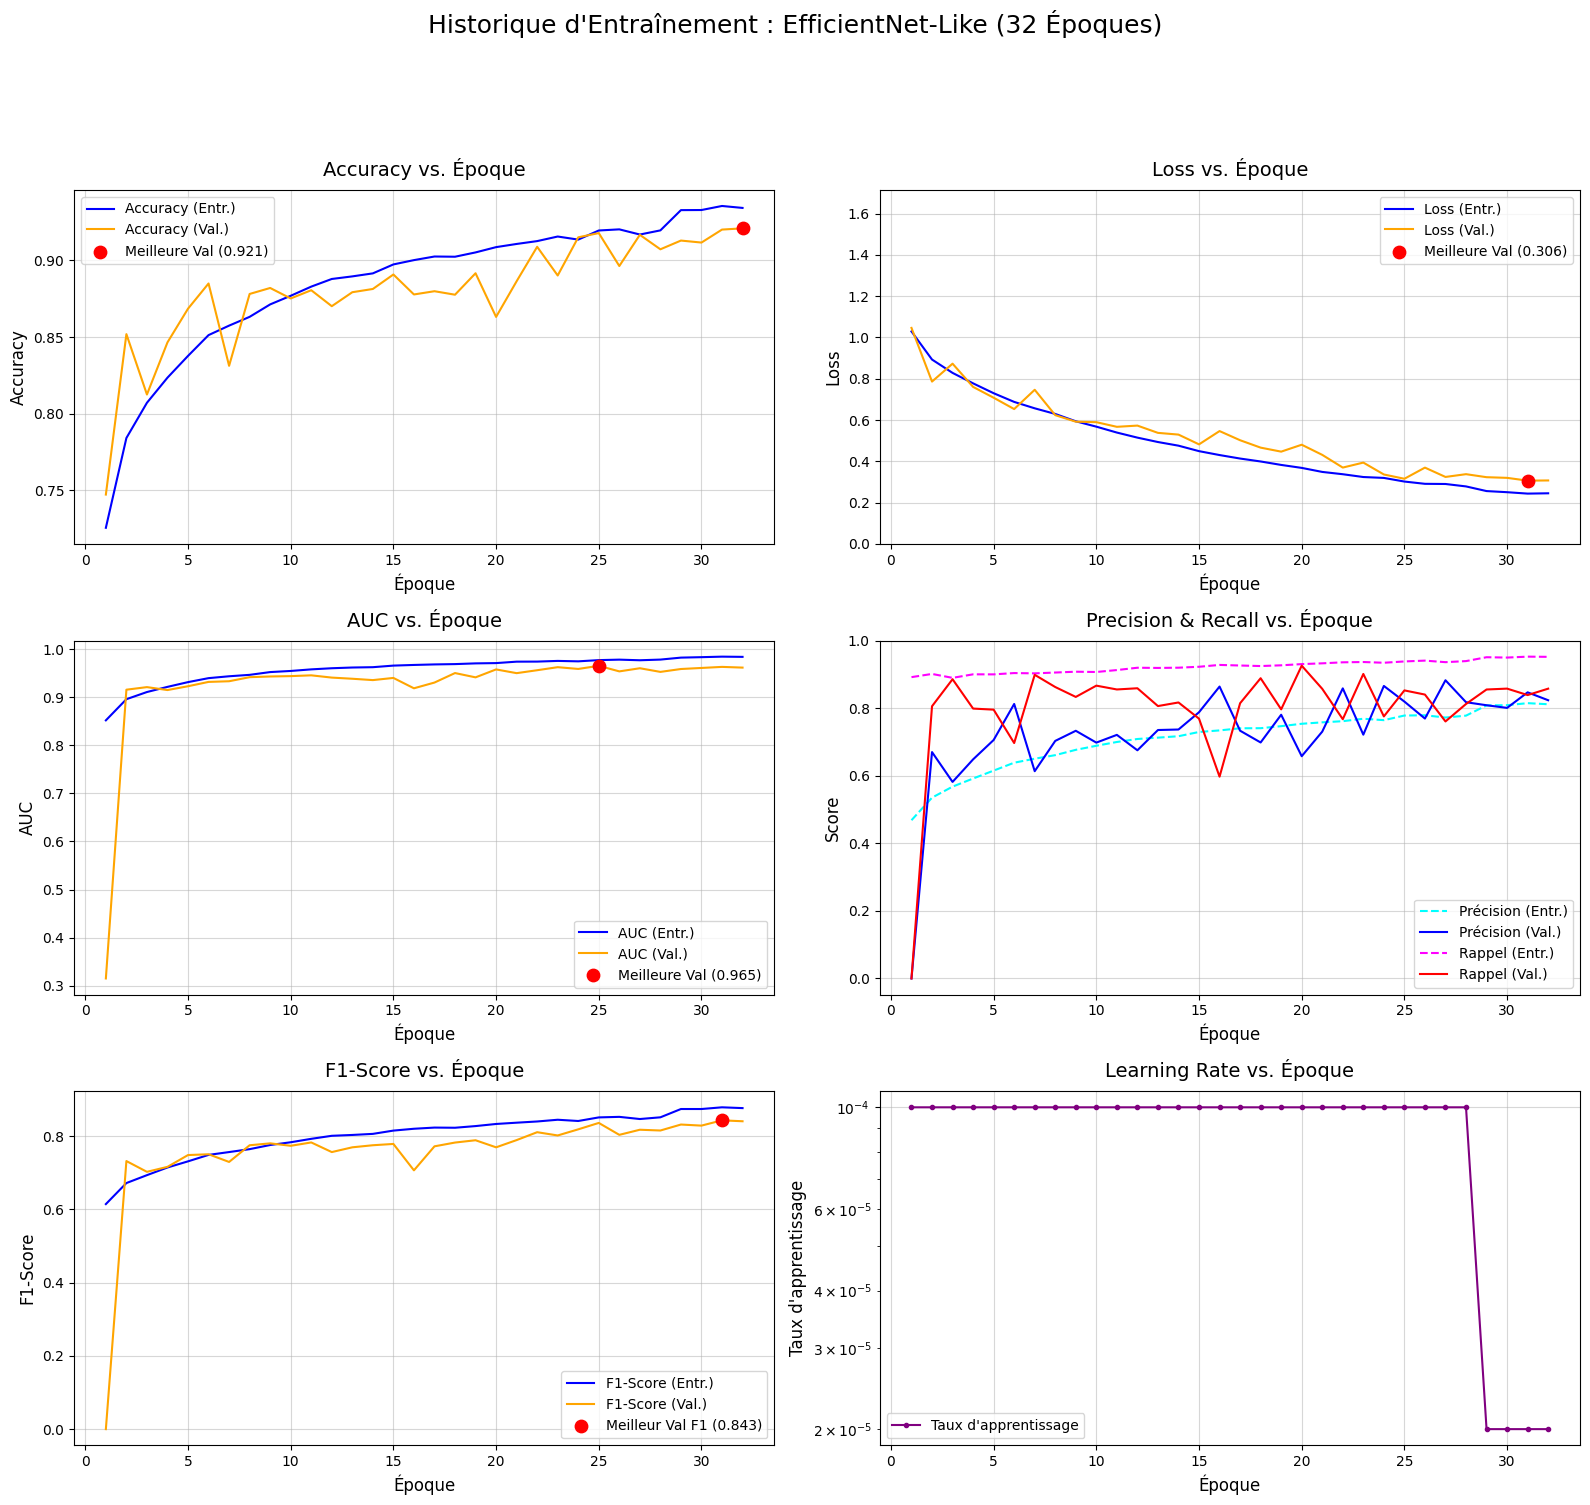


   -> Calcul et affichage de la matrice de confusion pour EfficientNet-Like (Test Set)...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


95/95 [==============================] - 31s 62ms/step


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


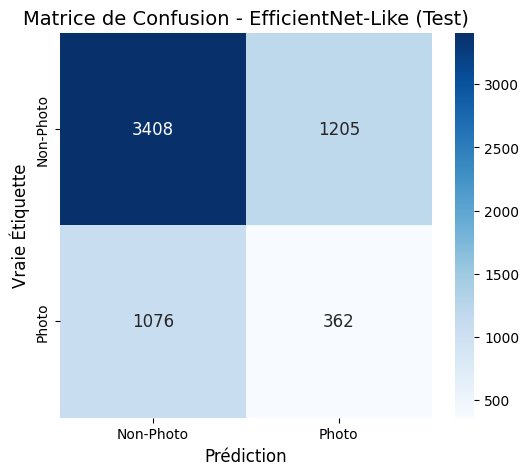


   -> Nettoyage final de la mémoire pour EfficientNet-Like...
   -> Mémoire nettoyée.

 Traitement du Modèle : GoogLeNet-Like 
[1/7] Nettoyage de la session Keras...
[2/7] Construction de l'architecture GoogLeNet-Like...
   -> Modèle GoogLeNet-Like construit.
[3/7] Chemin de sauvegarde du meilleur modèle : /workspace/checkpoints/best_googlenetlike_model.keras
[4/7] Callbacks configurés (EarlyStopping, ReduceLR, ModelCheckpoint spécifique).

[5/7] Démarrage de l'entraînement pour GoogLeNet-Like (max 60 époques)...
Epoch 1/60
445/445 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8011 - auc: 0.9091 - precision: 0.5578 - recall: 0.9022

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 1: val_auc improved from -inf to 0.91976, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 95s 198ms/step - loss: 0.3827 - accuracy: 0.8011 - auc: 0.9091 - precision: 0.5578 - recall: 0.9022 - val_loss: 0.3214 - val_accuracy: 0.8416 - val_auc: 0.9198 - val_precision: 0.6467 - val_recall: 0.8310 - lr: 1.0000e-04
Epoch 2/60
445/445 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.8269 - auc: 0.9245 - precision: 0.5970 - recall: 0.9029

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 2: val_auc improved from 0.91976 to 0.93611, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 84s 186ms/step - loss: 0.3336 - accuracy: 0.8269 - auc: 0.9245 - precision: 0.5970 - recall: 0.9029 - val_loss: 0.3313 - val_accuracy: 0.8330 - val_auc: 0.9361 - val_precision: 0.6040 - val_recall: 0.9159 - lr: 1.0000e-04
Epoch 3/60
445/445 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8566 - auc: 0.9428 - precision: 0.6484 - recall: 0.9064

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 3: val_auc improved from 0.93611 to 0.94826, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 86s 192ms/step - loss: 0.2941 - accuracy: 0.8566 - auc: 0.9428 - precision: 0.6484 - recall: 0.9064 - val_loss: 0.2589 - val_accuracy: 0.8820 - val_auc: 0.9483 - val_precision: 0.7334 - val_recall: 0.8344 - lr: 1.0000e-04
Epoch 4/60
445/445 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8676 - auc: 0.9499 - precision: 0.6695 - recall: 0.9081

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 4: val_auc did not improve from 0.94826
445/445 [==============================] - 84s 186ms/step - loss: 0.2767 - accuracy: 0.8676 - auc: 0.9499 - precision: 0.6695 - recall: 0.9081 - val_loss: 0.2633 - val_accuracy: 0.8758 - val_auc: 0.9416 - val_precision: 0.7392 - val_recall: 0.7660 - lr: 1.0000e-04
Epoch 5/60
445/445 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.8763 - auc: 0.9555 - precision: 0.6866 - recall: 0.9110

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 5: val_auc improved from 0.94826 to 0.95665, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 86s 192ms/step - loss: 0.2617 - accuracy: 0.8763 - auc: 0.9555 - precision: 0.6866 - recall: 0.9110 - val_loss: 0.2741 - val_accuracy: 0.8823 - val_auc: 0.9566 - val_precision: 0.7003 - val_recall: 0.9038 - lr: 1.0000e-04
Epoch 6/60
445/445 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.8834 - auc: 0.9602 - precision: 0.7013 - recall: 0.9128

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 6: val_auc improved from 0.95665 to 0.95830, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 84s 187ms/step - loss: 0.2481 - accuracy: 0.8834 - auc: 0.9602 - precision: 0.7013 - recall: 0.9128 - val_loss: 0.2801 - val_accuracy: 0.8799 - val_auc: 0.9583 - val_precision: 0.6972 - val_recall: 0.9010 - lr: 1.0000e-04
Epoch 7/60
445/445 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9031 - auc: 0.9698 - precision: 0.7422 - recall: 0.9264

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 7: val_auc improved from 0.95830 to 0.96211, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 85s 188ms/step - loss: 0.2169 - accuracy: 0.9031 - auc: 0.9698 - precision: 0.7422 - recall: 0.9264 - val_loss: 0.3126 - val_accuracy: 0.8727 - val_auc: 0.9621 - val_precision: 0.6777 - val_recall: 0.9417 - lr: 2.0000e-05
Epoch 8/60
445/445 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9072 - auc: 0.9716 - precision: 0.7503 - recall: 0.9312

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 8: val_auc improved from 0.96211 to 0.96417, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 87s 187ms/step - loss: 0.2103 - accuracy: 0.9072 - auc: 0.9716 - precision: 0.7503 - recall: 0.9312 - val_loss: 0.2594 - val_accuracy: 0.8940 - val_auc: 0.9642 - val_precision: 0.7218 - val_recall: 0.9236 - lr: 2.0000e-05
Epoch 9/60
445/445 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9099 - auc: 0.9735 - precision: 0.7559 - recall: 0.9340

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 9: val_auc improved from 0.96417 to 0.96661, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 84s 187ms/step - loss: 0.2033 - accuracy: 0.9099 - auc: 0.9735 - precision: 0.7559 - recall: 0.9340 - val_loss: 0.2402 - val_accuracy: 0.8999 - val_auc: 0.9666 - val_precision: 0.7363 - val_recall: 0.9132 - lr: 2.0000e-05
Epoch 10/60
445/445 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9113 - auc: 0.9742 - precision: 0.7584 - recall: 0.9363

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 10: val_auc did not improve from 0.96661
445/445 [==============================] - 87s 194ms/step - loss: 0.2005 - accuracy: 0.9113 - auc: 0.9742 - precision: 0.7584 - recall: 0.9363 - val_loss: 0.2455 - val_accuracy: 0.8963 - val_auc: 0.9640 - val_precision: 0.7402 - val_recall: 0.9055 - lr: 2.0000e-05
Epoch 11/60
445/445 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9142 - auc: 0.9757 - precision: 0.7657 - recall: 0.9362

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 11: val_auc improved from 0.96661 to 0.96807, saving model to /workspace/checkpoints/best_googlenetlike_model.keras
445/445 [==============================] - 85s 188ms/step - loss: 0.1948 - accuracy: 0.9142 - auc: 0.9757 - precision: 0.7657 - recall: 0.9362 - val_loss: 0.2212 - val_accuracy: 0.9074 - val_auc: 0.9681 - val_precision: 0.7621 - val_recall: 0.9099 - lr: 2.0000e-05
Epoch 12/60
445/445 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9156 - auc: 0.9763 - precision: 0.7685 - recall: 0.9383

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 12: val_auc did not improve from 0.96807
445/445 [==============================] - 87s 192ms/step - loss: 0.1921 - accuracy: 0.9156 - auc: 0.9763 - precision: 0.7685 - recall: 0.9383 - val_loss: 0.2709 - val_accuracy: 0.8872 - val_auc: 0.9638 - val_precision: 0.7051 - val_recall: 0.9210 - lr: 2.0000e-05
Epoch 13/60
445/445 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9184 - auc: 0.9778 - precision: 0.7756 - recall: 0.9383

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 13: val_auc did not improve from 0.96807
445/445 [==============================] - 84s 187ms/step - loss: 0.1862 - accuracy: 0.9184 - auc: 0.9778 - precision: 0.7756 - recall: 0.9383 - val_loss: 0.2543 - val_accuracy: 0.8975 - val_auc: 0.9591 - val_precision: 0.7446 - val_recall: 0.8867 - lr: 2.0000e-05
Epoch 14/60
445/445 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9203 - auc: 0.9783 - precision: 0.7801 - recall: 0.9395

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 14: val_auc did not improve from 0.96807
445/445 [==============================] - 88s 194ms/step - loss: 0.1840 - accuracy: 0.9203 - auc: 0.9783 - precision: 0.7801 - recall: 0.9395 - val_loss: 0.2374 - val_accuracy: 0.9043 - val_auc: 0.9661 - val_precision: 0.7552 - val_recall: 0.9001 - lr: 2.0000e-05
Epoch 15/60
445/445 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9256 - auc: 0.9809 - precision: 0.7927 - recall: 0.9432

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 15: val_auc did not improve from 0.96807
445/445 [==============================] - 84s 185ms/step - loss: 0.1728 - accuracy: 0.9256 - auc: 0.9809 - precision: 0.7927 - recall: 0.9432 - val_loss: 0.2476 - val_accuracy: 0.8999 - val_auc: 0.9622 - val_precision: 0.7511 - val_recall: 0.8909 - lr: 4.0000e-06
Epoch 16/60
445/445 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9250 - auc: 0.9812 - precision: 0.7918 - recall: 0.9416

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 16: val_auc did not improve from 0.96807
445/445 [==============================] - 88s 195ms/step - loss: 0.1712 - accuracy: 0.9250 - auc: 0.9812 - precision: 0.7918 - recall: 0.9416 - val_loss: 0.2485 - val_accuracy: 0.8986 - val_auc: 0.9596 - val_precision: 0.7566 - val_recall: 0.8713 - lr: 4.0000e-06
Epoch 17/60
445/445 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9279 - auc: 0.9819 - precision: 0.7978 - recall: 0.9452

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 17: val_auc did not improve from 0.96807
445/445 [==============================] - 84s 186ms/step - loss: 0.1681 - accuracy: 0.9279 - auc: 0.9819 - precision: 0.7978 - recall: 0.9452 - val_loss: 0.2451 - val_accuracy: 0.9014 - val_auc: 0.9612 - val_precision: 0.7553 - val_recall: 0.8821 - lr: 4.0000e-06
Epoch 18/60
445/445 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9274 - auc: 0.9823 - precision: 0.7970 - recall: 0.9442

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 18: val_auc did not improve from 0.96807
445/445 [==============================] - 84s 188ms/step - loss: 0.1663 - accuracy: 0.9274 - auc: 0.9823 - precision: 0.7970 - recall: 0.9442 - val_loss: 0.2441 - val_accuracy: 0.9012 - val_auc: 0.9622 - val_precision: 0.7608 - val_recall: 0.8902 - lr: 1.0000e-06
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 11.
   -> Entraînement de GoogLeNet-Like terminé en 1545.8 secondes (18 époques effectuées).

[6/7] Chargement du meilleur modèle (GoogLeNet-Like) depuis : /workspace/checkpoints/best_googlenetlike_model.keras
   -> Meilleur modèle chargé depuis le fichier checkpoint.

[7/7] Évaluation du meilleur modèle (GoogLeNet-Like) sur l'ensemble de test...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


   --- Résultats sur l'ensemble de test ---
     loss: 0.2151
     accuracy: 0.9078
     auc: 0.9693
     precision: 0.7607
     recall: 0.8980
     f1_score: 0.8236
     training_time_sec: 1545.8117
     epochs_run: 18.0000
   ----------------------------------------

   -> Affichage de l'historique d'entraînement pour GoogLeNet-Like...
    -> Métriques disponibles pour le tracé : ['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr']


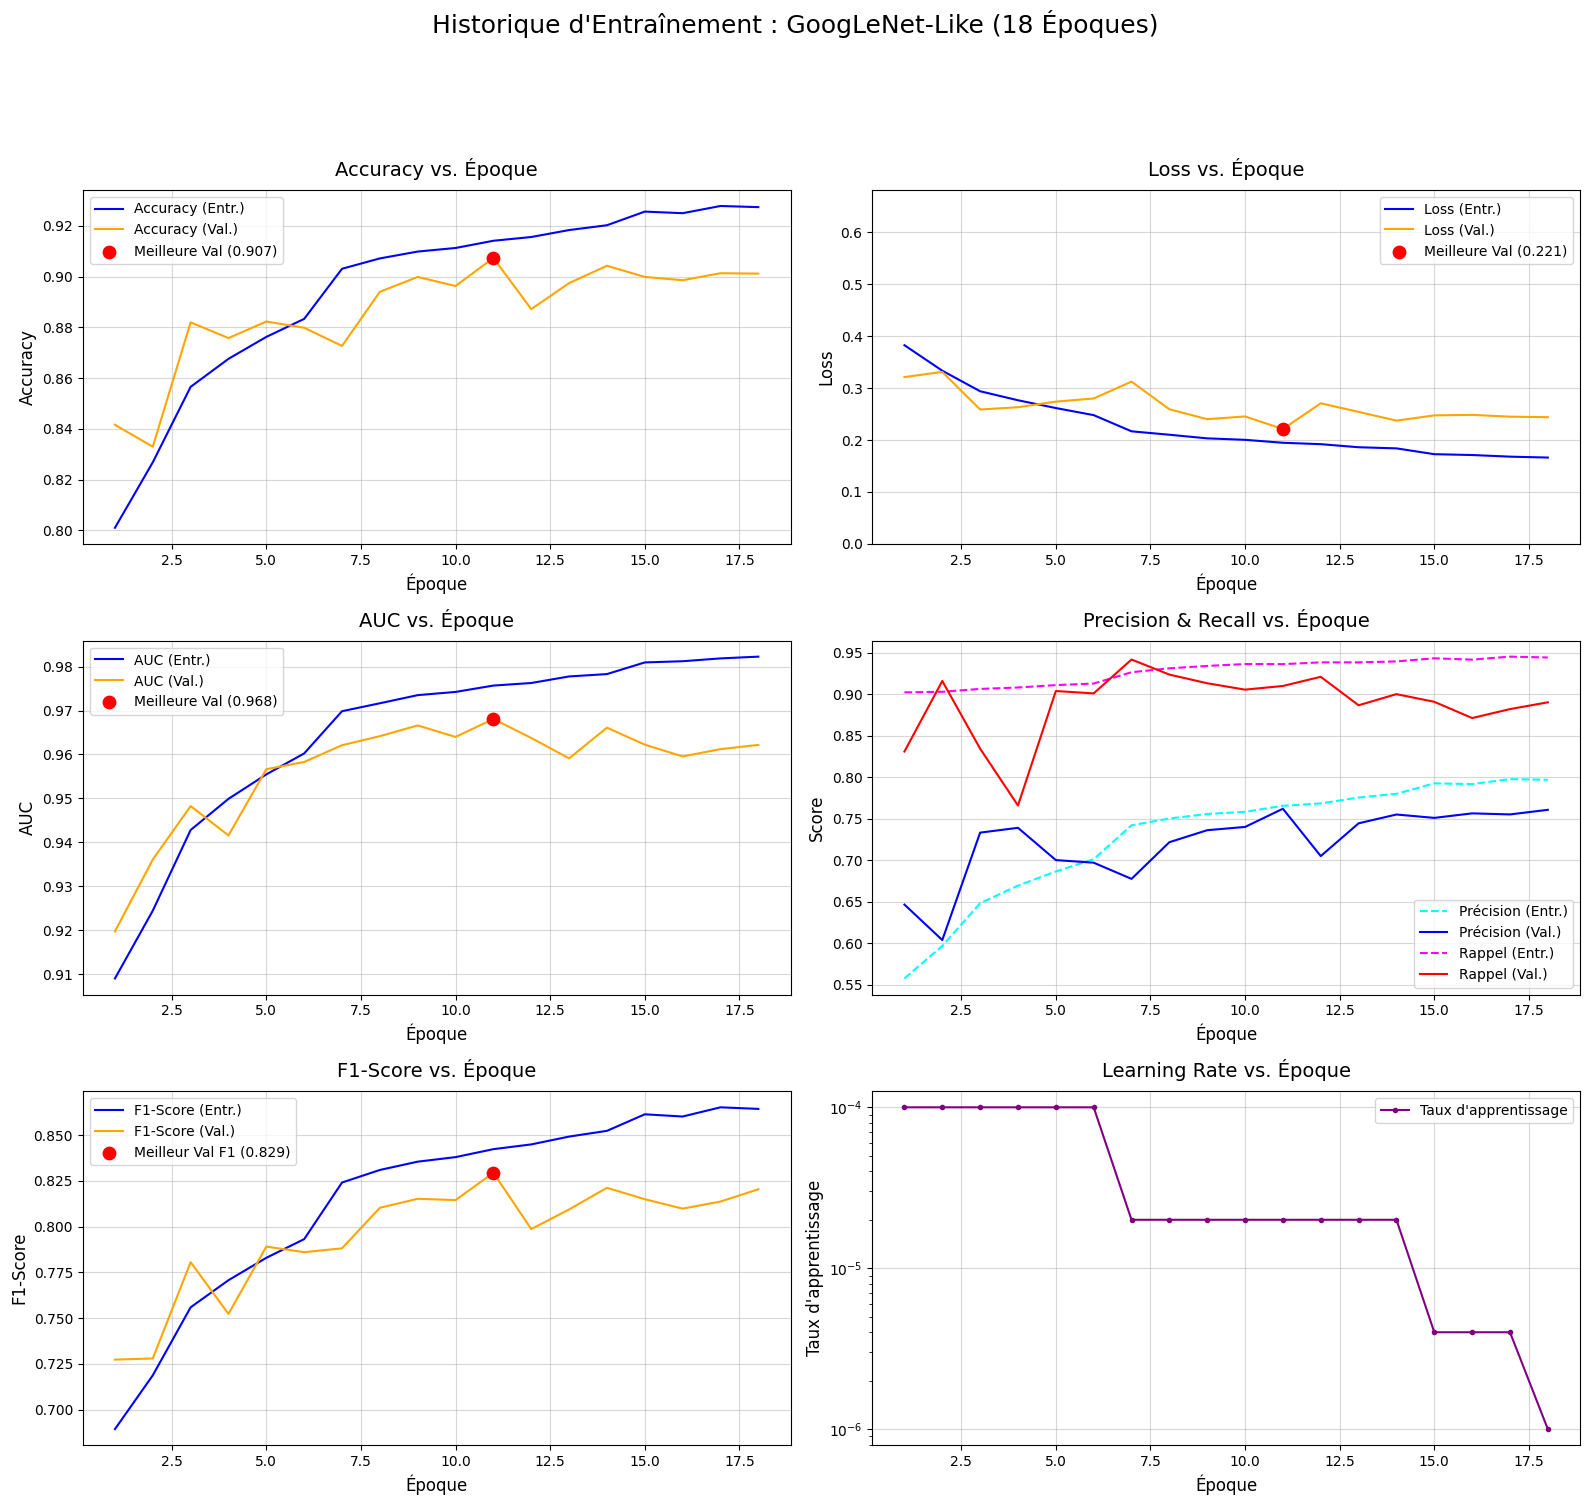


   -> Calcul et affichage de la matrice de confusion pour GoogLeNet-Like (Test Set)...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


95/95 [==============================] - 28s 35ms/step


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


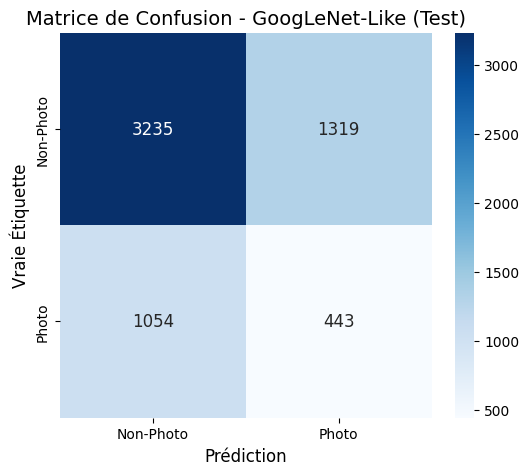


   -> Nettoyage final de la mémoire pour GoogLeNet-Like...
   -> Mémoire nettoyée.

 Traitement du Modèle : ResNet-Like 
[1/7] Nettoyage de la session Keras...
[2/7] Construction de l'architecture ResNet-Like...
   -> Modèle ResNet-Like construit.
[3/7] Chemin de sauvegarde du meilleur modèle : /workspace/checkpoints/best_resnetlike_model.keras
[4/7] Callbacks configurés (EarlyStopping, ReduceLR, ModelCheckpoint spécifique).

[5/7] Démarrage de l'entraînement pour ResNet-Like (max 60 époques)...
Epoch 1/60


E0000 00:00:1743938488.976695     145 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResNet-Like/sp_dropout2a/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


445/445 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.7728 - auc: 0.8862 - precision: 0.5229 - recall: 0.8973

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 1: val_auc improved from -inf to 0.71902, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 175s 357ms/step - loss: 0.9392 - accuracy: 0.7728 - auc: 0.8862 - precision: 0.5229 - recall: 0.8973 - val_loss: 1.0399 - val_accuracy: 0.7188 - val_auc: 0.7190 - val_precision: 0.4503 - val_recall: 0.6234 - lr: 1.0000e-04
Epoch 2/60
445/445 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.8067 - auc: 0.9093 - precision: 0.5666 - recall: 0.8995

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 2: val_auc improved from 0.71902 to 0.93610, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 155s 345ms/step - loss: 0.7873 - accuracy: 0.8067 - auc: 0.9093 - precision: 0.5666 - recall: 0.8995 - val_loss: 0.6713 - val_accuracy: 0.8662 - val_auc: 0.9361 - val_precision: 0.6963 - val_recall: 0.8368 - lr: 1.0000e-04
Epoch 3/60
445/445 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.8307 - auc: 0.9249 - precision: 0.6033 - recall: 0.9026

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 3: val_auc did not improve from 0.93610
445/445 [==============================] - 152s 338ms/step - loss: 0.6983 - accuracy: 0.8307 - auc: 0.9249 - precision: 0.6033 - recall: 0.9026 - val_loss: 0.8002 - val_accuracy: 0.8000 - val_auc: 0.9223 - val_precision: 0.5632 - val_recall: 0.9186 - lr: 1.0000e-04
Epoch 4/60
445/445 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.8399 - auc: 0.9324 - precision: 0.6194 - recall: 0.8991

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 4: val_auc improved from 0.93610 to 0.93834, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 155s 347ms/step - loss: 0.6327 - accuracy: 0.8399 - auc: 0.9324 - precision: 0.6194 - recall: 0.8991 - val_loss: 0.5735 - val_accuracy: 0.8747 - val_auc: 0.9383 - val_precision: 0.7157 - val_recall: 0.8251 - lr: 1.0000e-04
Epoch 5/60
445/445 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.8562 - auc: 0.9424 - precision: 0.6479 - recall: 0.9049

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 5: val_auc improved from 0.93834 to 0.95975, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 153s 341ms/step - loss: 0.5663 - accuracy: 0.8562 - auc: 0.9424 - precision: 0.6479 - recall: 0.9049 - val_loss: 0.5826 - val_accuracy: 0.8615 - val_auc: 0.9597 - val_precision: 0.6582 - val_recall: 0.9394 - lr: 1.0000e-04
Epoch 6/60
445/445 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8633 - auc: 0.9463 - precision: 0.6612 - recall: 0.9068

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 6: val_auc did not improve from 0.95975
445/445 [==============================] - 152s 338ms/step - loss: 0.5162 - accuracy: 0.8633 - auc: 0.9463 - precision: 0.6612 - recall: 0.9068 - val_loss: 0.4985 - val_accuracy: 0.8745 - val_auc: 0.9498 - val_precision: 0.6884 - val_recall: 0.9007 - lr: 1.0000e-04
Epoch 7/60
445/445 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8729 - auc: 0.9517 - precision: 0.6795 - recall: 0.9108

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 7: val_auc did not improve from 0.95975
445/445 [==============================] - 155s 345ms/step - loss: 0.4663 - accuracy: 0.8729 - auc: 0.9517 - precision: 0.6795 - recall: 0.9108 - val_loss: 0.4138 - val_accuracy: 0.8971 - val_auc: 0.9531 - val_precision: 0.7922 - val_recall: 0.7751 - lr: 1.0000e-04
Epoch 8/60
445/445 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8793 - auc: 0.9555 - precision: 0.6926 - recall: 0.9125

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 8: val_auc did not improve from 0.95975
445/445 [==============================] - 152s 340ms/step - loss: 0.4236 - accuracy: 0.8793 - auc: 0.9555 - precision: 0.6926 - recall: 0.9125 - val_loss: 0.4115 - val_accuracy: 0.8883 - val_auc: 0.9582 - val_precision: 0.7218 - val_recall: 0.8865 - lr: 1.0000e-04
Epoch 9/60
445/445 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8863 - auc: 0.9588 - precision: 0.7057 - recall: 0.9193

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 9: val_auc did not improve from 0.95975
445/445 [==============================] - 154s 343ms/step - loss: 0.3867 - accuracy: 0.8863 - auc: 0.9588 - precision: 0.7057 - recall: 0.9193 - val_loss: 0.3556 - val_accuracy: 0.8993 - val_auc: 0.9560 - val_precision: 0.8609 - val_recall: 0.7025 - lr: 1.0000e-04
Epoch 10/60
445/445 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8907 - auc: 0.9619 - precision: 0.7155 - recall: 0.9198

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 10: val_auc improved from 0.95975 to 0.96908, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 153s 341ms/step - loss: 0.3527 - accuracy: 0.8907 - auc: 0.9619 - precision: 0.7155 - recall: 0.9198 - val_loss: 0.2932 - val_accuracy: 0.9196 - val_auc: 0.9691 - val_precision: 0.8334 - val_recall: 0.8527 - lr: 1.0000e-04
Epoch 11/60
445/445 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8921 - auc: 0.9634 - precision: 0.7181 - recall: 0.9216

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 11: val_auc did not improve from 0.96908
445/445 [==============================] - 152s 339ms/step - loss: 0.3265 - accuracy: 0.8921 - auc: 0.9634 - precision: 0.7181 - recall: 0.9216 - val_loss: 0.3725 - val_accuracy: 0.8789 - val_auc: 0.9649 - val_precision: 0.6877 - val_recall: 0.9447 - lr: 1.0000e-04
Epoch 12/60
445/445 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8975 - auc: 0.9658 - precision: 0.7289 - recall: 0.9266

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 12: val_auc did not improve from 0.96908
445/445 [==============================] - 154s 338ms/step - loss: 0.3024 - accuracy: 0.8975 - auc: 0.9658 - precision: 0.7289 - recall: 0.9266 - val_loss: 0.3305 - val_accuracy: 0.8857 - val_auc: 0.9634 - val_precision: 0.7059 - val_recall: 0.9179 - lr: 1.0000e-04
Epoch 13/60
445/445 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9031 - auc: 0.9687 - precision: 0.7419 - recall: 0.9270

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 13: val_auc did not improve from 0.96908
445/445 [==============================] - 152s 339ms/step - loss: 0.2791 - accuracy: 0.9031 - auc: 0.9687 - precision: 0.7419 - recall: 0.9270 - val_loss: 0.2948 - val_accuracy: 0.9019 - val_auc: 0.9596 - val_precision: 0.8781 - val_recall: 0.7047 - lr: 1.0000e-04
Epoch 14/60
445/445 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9163 - auc: 0.9763 - precision: 0.7701 - recall: 0.9388

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 14: val_auc improved from 0.96908 to 0.97796, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 155s 346ms/step - loss: 0.2437 - accuracy: 0.9163 - auc: 0.9763 - precision: 0.7701 - recall: 0.9388 - val_loss: 0.2131 - val_accuracy: 0.9354 - val_auc: 0.9780 - val_precision: 0.8947 - val_recall: 0.8406 - lr: 2.0000e-05
Epoch 15/60
445/445 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9212 - auc: 0.9783 - precision: 0.7822 - recall: 0.9401

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 15: val_auc did not improve from 0.97796
445/445 [==============================] - 152s 339ms/step - loss: 0.2325 - accuracy: 0.9212 - auc: 0.9783 - precision: 0.7822 - recall: 0.9401 - val_loss: 0.2126 - val_accuracy: 0.9365 - val_auc: 0.9778 - val_precision: 0.8819 - val_recall: 0.8684 - lr: 2.0000e-05
Epoch 16/60
445/445 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9230 - auc: 0.9796 - precision: 0.7854 - recall: 0.9435

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 16: val_auc improved from 0.97796 to 0.97875, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 156s 347ms/step - loss: 0.2247 - accuracy: 0.9230 - auc: 0.9796 - precision: 0.7854 - recall: 0.9435 - val_loss: 0.2107 - val_accuracy: 0.9364 - val_auc: 0.9787 - val_precision: 0.8506 - val_recall: 0.8985 - lr: 2.0000e-05
Epoch 17/60
445/445 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9258 - auc: 0.9802 - precision: 0.7932 - recall: 0.9428

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 17: val_auc improved from 0.97875 to 0.97996, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 154s 341ms/step - loss: 0.2192 - accuracy: 0.9258 - auc: 0.9802 - precision: 0.7932 - recall: 0.9428 - val_loss: 0.2013 - val_accuracy: 0.9359 - val_auc: 0.9800 - val_precision: 0.8577 - val_recall: 0.8871 - lr: 2.0000e-05
Epoch 18/60
445/445 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9266 - auc: 0.9808 - precision: 0.7940 - recall: 0.9461

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 18: val_auc did not improve from 0.97996
445/445 [==============================] - 154s 344ms/step - loss: 0.2141 - accuracy: 0.9266 - auc: 0.9808 - precision: 0.7940 - recall: 0.9461 - val_loss: 0.2144 - val_accuracy: 0.9302 - val_auc: 0.9770 - val_precision: 0.9046 - val_recall: 0.8081 - lr: 2.0000e-05
Epoch 19/60
445/445 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9280 - auc: 0.9819 - precision: 0.7984 - recall: 0.9449

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 19: val_auc did not improve from 0.97996
445/445 [==============================] - 152s 338ms/step - loss: 0.2070 - accuracy: 0.9280 - auc: 0.9819 - precision: 0.7984 - recall: 0.9449 - val_loss: 0.2037 - val_accuracy: 0.9325 - val_auc: 0.9764 - val_precision: 0.8678 - val_recall: 0.8570 - lr: 2.0000e-05
Epoch 20/60
445/445 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9288 - auc: 0.9822 - precision: 0.8000 - recall: 0.9459

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 20: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 20: val_auc did not improve from 0.97996
445/445 [==============================] - 154s 344ms/step - loss: 0.2028 - accuracy: 0.9288 - auc: 0.9822 - precision: 0.8000 - recall: 0.9459 - val_loss: 0.2097 - val_accuracy: 0.9313 - val_auc: 0.9756 - val_precision: 0.8847 - val_recall: 0.8420 - lr: 2.0000e-05
Epoch 21/60
445/445 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9316 - auc: 0.9838 - precision: 0.8079 - recall: 0.9457

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 21: val_auc improved from 0.97996 to 0.98205, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 153s 340ms/step - loss: 0.1948 - accuracy: 0.9316 - auc: 0.9838 - precision: 0.8079 - recall: 0.9457 - val_loss: 0.1881 - val_accuracy: 0.9408 - val_auc: 0.9821 - val_precision: 0.8567 - val_recall: 0.9177 - lr: 4.0000e-06
Epoch 22/60
445/445 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9341 - auc: 0.9836 - precision: 0.8132 - recall: 0.9491

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 22: val_auc did not improve from 0.98205
445/445 [==============================] - 155s 345ms/step - loss: 0.1940 - accuracy: 0.9341 - auc: 0.9836 - precision: 0.8132 - recall: 0.9491 - val_loss: 0.1906 - val_accuracy: 0.9383 - val_auc: 0.9807 - val_precision: 0.8707 - val_recall: 0.8859 - lr: 4.0000e-06
Epoch 23/60
445/445 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9355 - auc: 0.9845 - precision: 0.8158 - recall: 0.9515

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 23: val_auc did not improve from 0.98205
445/445 [==============================] - 152s 339ms/step - loss: 0.1894 - accuracy: 0.9355 - auc: 0.9845 - precision: 0.8158 - recall: 0.9515 - val_loss: 0.1892 - val_accuracy: 0.9406 - val_auc: 0.9811 - val_precision: 0.8602 - val_recall: 0.9110 - lr: 4.0000e-06
Epoch 24/60
445/445 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9332 - auc: 0.9842 - precision: 0.8103 - recall: 0.9500

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 24: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 24: val_auc did not improve from 0.98205
445/445 [==============================] - 152s 338ms/step - loss: 0.1905 - accuracy: 0.9332 - auc: 0.9842 - precision: 0.8103 - recall: 0.9500 - val_loss: 0.1888 - val_accuracy: 0.9406 - val_auc: 0.9814 - val_precision: 0.8608 - val_recall: 0.9027 - lr: 4.0000e-06
Epoch 25/60
445/445 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9346 - auc: 0.9845 - precision: 0.8147 - recall: 0.9491

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 25: val_auc did not improve from 0.98205
445/445 [==============================] - 155s 345ms/step - loss: 0.1875 - accuracy: 0.9346 - auc: 0.9845 - precision: 0.8147 - recall: 0.9491 - val_loss: 0.1816 - val_accuracy: 0.9425 - val_auc: 0.9820 - val_precision: 0.8672 - val_recall: 0.9096 - lr: 1.0000e-06
Epoch 26/60
445/445 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9362 - auc: 0.9851 - precision: 0.8180 - recall: 0.9512

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 26: val_auc did not improve from 0.98205
445/445 [==============================] - 152s 338ms/step - loss: 0.1853 - accuracy: 0.9362 - auc: 0.9851 - precision: 0.8180 - recall: 0.9512 - val_loss: 0.1935 - val_accuracy: 0.9377 - val_auc: 0.9801 - val_precision: 0.8572 - val_recall: 0.8993 - lr: 1.0000e-06
Epoch 27/60
445/445 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9378 - auc: 0.9851 - precision: 0.8208 - recall: 0.9544

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 27: val_auc improved from 0.98205 to 0.98269, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 156s 347ms/step - loss: 0.1848 - accuracy: 0.9378 - auc: 0.9851 - precision: 0.8208 - recall: 0.9544 - val_loss: 0.1822 - val_accuracy: 0.9408 - val_auc: 0.9827 - val_precision: 0.8644 - val_recall: 0.9030 - lr: 1.0000e-06
Epoch 28/60
445/445 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9339 - auc: 0.9847 - precision: 0.8113 - recall: 0.9517

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 28: val_auc did not improve from 0.98269
445/445 [==============================] - 151s 336ms/step - loss: 0.1870 - accuracy: 0.9339 - auc: 0.9847 - precision: 0.8113 - recall: 0.9517 - val_loss: 0.1806 - val_accuracy: 0.9442 - val_auc: 0.9822 - val_precision: 0.8629 - val_recall: 0.9203 - lr: 1.0000e-06
Epoch 29/60
445/445 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9369 - auc: 0.9855 - precision: 0.8198 - recall: 0.9514

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 29: val_auc did not improve from 0.98269
445/445 [==============================] - 154s 338ms/step - loss: 0.1833 - accuracy: 0.9369 - auc: 0.9855 - precision: 0.8198 - recall: 0.9514 - val_loss: 0.1916 - val_accuracy: 0.9396 - val_auc: 0.9814 - val_precision: 0.8581 - val_recall: 0.9089 - lr: 1.0000e-06
Epoch 30/60
445/445 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9360 - auc: 0.9851 - precision: 0.8165 - recall: 0.9528

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 30: val_auc did not improve from 0.98269
445/445 [==============================] - 152s 338ms/step - loss: 0.1847 - accuracy: 0.9360 - auc: 0.9851 - precision: 0.8165 - recall: 0.9528 - val_loss: 0.1811 - val_accuracy: 0.9430 - val_auc: 0.9825 - val_precision: 0.8588 - val_recall: 0.9163 - lr: 1.0000e-06
Epoch 31/60
445/445 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9373 - auc: 0.9857 - precision: 0.8211 - recall: 0.9515

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 31: val_auc improved from 0.98269 to 0.98337, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 156s 348ms/step - loss: 0.1827 - accuracy: 0.9373 - auc: 0.9857 - precision: 0.8211 - recall: 0.9515 - val_loss: 0.1798 - val_accuracy: 0.9429 - val_auc: 0.9834 - val_precision: 0.8636 - val_recall: 0.9082 - lr: 1.0000e-06
Epoch 32/60
445/445 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9355 - auc: 0.9852 - precision: 0.8162 - recall: 0.9510

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 32: val_auc did not improve from 0.98337
445/445 [==============================] - 152s 337ms/step - loss: 0.1846 - accuracy: 0.9355 - auc: 0.9852 - precision: 0.8162 - recall: 0.9510 - val_loss: 0.1833 - val_accuracy: 0.9448 - val_auc: 0.9824 - val_precision: 0.8679 - val_recall: 0.9145 - lr: 1.0000e-06
Epoch 33/60
445/445 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9376 - auc: 0.9860 - precision: 0.8202 - recall: 0.9547

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 33: val_auc did not improve from 0.98337
445/445 [==============================] - 152s 338ms/step - loss: 0.1795 - accuracy: 0.9376 - auc: 0.9860 - precision: 0.8202 - recall: 0.9547 - val_loss: 0.1795 - val_accuracy: 0.9430 - val_auc: 0.9828 - val_precision: 0.8641 - val_recall: 0.9150 - lr: 1.0000e-06
Epoch 34/60
445/445 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9341 - auc: 0.9847 - precision: 0.8131 - recall: 0.9495

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 34: val_auc did not improve from 0.98337
445/445 [==============================] - 155s 345ms/step - loss: 0.1866 - accuracy: 0.9341 - auc: 0.9847 - precision: 0.8131 - recall: 0.9495 - val_loss: 0.1900 - val_accuracy: 0.9422 - val_auc: 0.9806 - val_precision: 0.8565 - val_recall: 0.9127 - lr: 1.0000e-06
Epoch 35/60
445/445 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9369 - auc: 0.9856 - precision: 0.8186 - recall: 0.9541

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 35: val_auc did not improve from 0.98337
445/445 [==============================] - 152s 338ms/step - loss: 0.1819 - accuracy: 0.9369 - auc: 0.9856 - precision: 0.8186 - recall: 0.9541 - val_loss: 0.1820 - val_accuracy: 0.9432 - val_auc: 0.9826 - val_precision: 0.8700 - val_recall: 0.9120 - lr: 1.0000e-06
Epoch 36/60
445/445 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9376 - auc: 0.9862 - precision: 0.8219 - recall: 0.9517

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 36: val_auc improved from 0.98337 to 0.98427, saving model to /workspace/checkpoints/best_resnetlike_model.keras
445/445 [==============================] - 155s 347ms/step - loss: 0.1789 - accuracy: 0.9376 - auc: 0.9862 - precision: 0.8219 - recall: 0.9517 - val_loss: 0.1762 - val_accuracy: 0.9447 - val_auc: 0.9843 - val_precision: 0.8662 - val_recall: 0.9204 - lr: 1.0000e-06
Epoch 37/60
445/445 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9363 - auc: 0.9862 - precision: 0.8164 - recall: 0.9547

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 37: val_auc did not improve from 0.98427
445/445 [==============================] - 152s 338ms/step - loss: 0.1782 - accuracy: 0.9363 - auc: 0.9862 - precision: 0.8164 - recall: 0.9547 - val_loss: 0.1846 - val_accuracy: 0.9422 - val_auc: 0.9825 - val_precision: 0.8664 - val_recall: 0.9145 - lr: 1.0000e-06
Epoch 38/60
445/445 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9374 - auc: 0.9859 - precision: 0.8221 - recall: 0.9501

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 38: val_auc did not improve from 0.98427
445/445 [==============================] - 152s 338ms/step - loss: 0.1796 - accuracy: 0.9374 - auc: 0.9859 - precision: 0.8221 - recall: 0.9501 - val_loss: 0.1914 - val_accuracy: 0.9396 - val_auc: 0.9807 - val_precision: 0.8679 - val_recall: 0.8924 - lr: 1.0000e-06
Epoch 39/60
445/445 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9371 - auc: 0.9857 - precision: 0.8198 - recall: 0.9525

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 39: val_auc did not improve from 0.98427
445/445 [==============================] - 155s 345ms/step - loss: 0.1803 - accuracy: 0.9371 - auc: 0.9857 - precision: 0.8198 - recall: 0.9525 - val_loss: 0.1823 - val_accuracy: 0.9422 - val_auc: 0.9832 - val_precision: 0.8656 - val_recall: 0.9130 - lr: 1.0000e-06
Epoch 40/60
445/445 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9372 - auc: 0.9859 - precision: 0.8199 - recall: 0.9533

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 40: val_auc did not improve from 0.98427
445/445 [==============================] - 151s 337ms/step - loss: 0.1786 - accuracy: 0.9372 - auc: 0.9859 - precision: 0.8199 - recall: 0.9533 - val_loss: 0.1824 - val_accuracy: 0.9385 - val_auc: 0.9821 - val_precision: 0.8616 - val_recall: 0.8945 - lr: 1.0000e-06
Epoch 41/60
445/445 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9357 - auc: 0.9854 - precision: 0.8167 - recall: 0.9511

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 41: val_auc did not improve from 0.98427
445/445 [==============================] - 155s 345ms/step - loss: 0.1824 - accuracy: 0.9357 - auc: 0.9854 - precision: 0.8167 - recall: 0.9511 - val_loss: 0.1805 - val_accuracy: 0.9425 - val_auc: 0.9826 - val_precision: 0.8668 - val_recall: 0.9102 - lr: 1.0000e-06
Epoch 42/60
445/445 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9385 - auc: 0.9855 - precision: 0.8235 - recall: 0.9534

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 42: val_auc did not improve from 0.98427
445/445 [==============================] - 152s 338ms/step - loss: 0.1807 - accuracy: 0.9385 - auc: 0.9855 - precision: 0.8235 - recall: 0.9534 - val_loss: 0.1767 - val_accuracy: 0.9451 - val_auc: 0.9831 - val_precision: 0.8748 - val_recall: 0.9056 - lr: 1.0000e-06
Epoch 43/60
445/445 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9377 - auc: 0.9862 - precision: 0.8221 - recall: 0.9517

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 43: val_auc did not improve from 0.98427
445/445 [==============================] - 152s 339ms/step - loss: 0.1774 - accuracy: 0.9377 - auc: 0.9862 - precision: 0.8221 - recall: 0.9517 - val_loss: 0.1837 - val_accuracy: 0.9406 - val_auc: 0.9825 - val_precision: 0.8589 - val_recall: 0.9111 - lr: 1.0000e-06
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 36.
   -> Entraînement de ResNet-Like terminé en 6610.5 secondes (43 époques effectuées).

[6/7] Chargement du meilleur modèle (ResNet-Like) depuis : /workspace/checkpoints/best_resnetlike_model.keras
   -> Meilleur modèle chargé depuis le fichier checkpoint.

[7/7] Évaluation du meilleur modèle (ResNet-Like) sur l'ensemble de test...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


   --- Résultats sur l'ensemble de test ---
     loss: 0.1823
     accuracy: 0.9423
     auc: 0.9827
     precision: 0.8627
     recall: 0.9088
     f1_score: 0.8852
     training_time_sec: 6610.5315
     epochs_run: 43.0000
   ----------------------------------------

   -> Affichage de l'historique d'entraînement pour ResNet-Like...
    -> Métriques disponibles pour le tracé : ['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr']


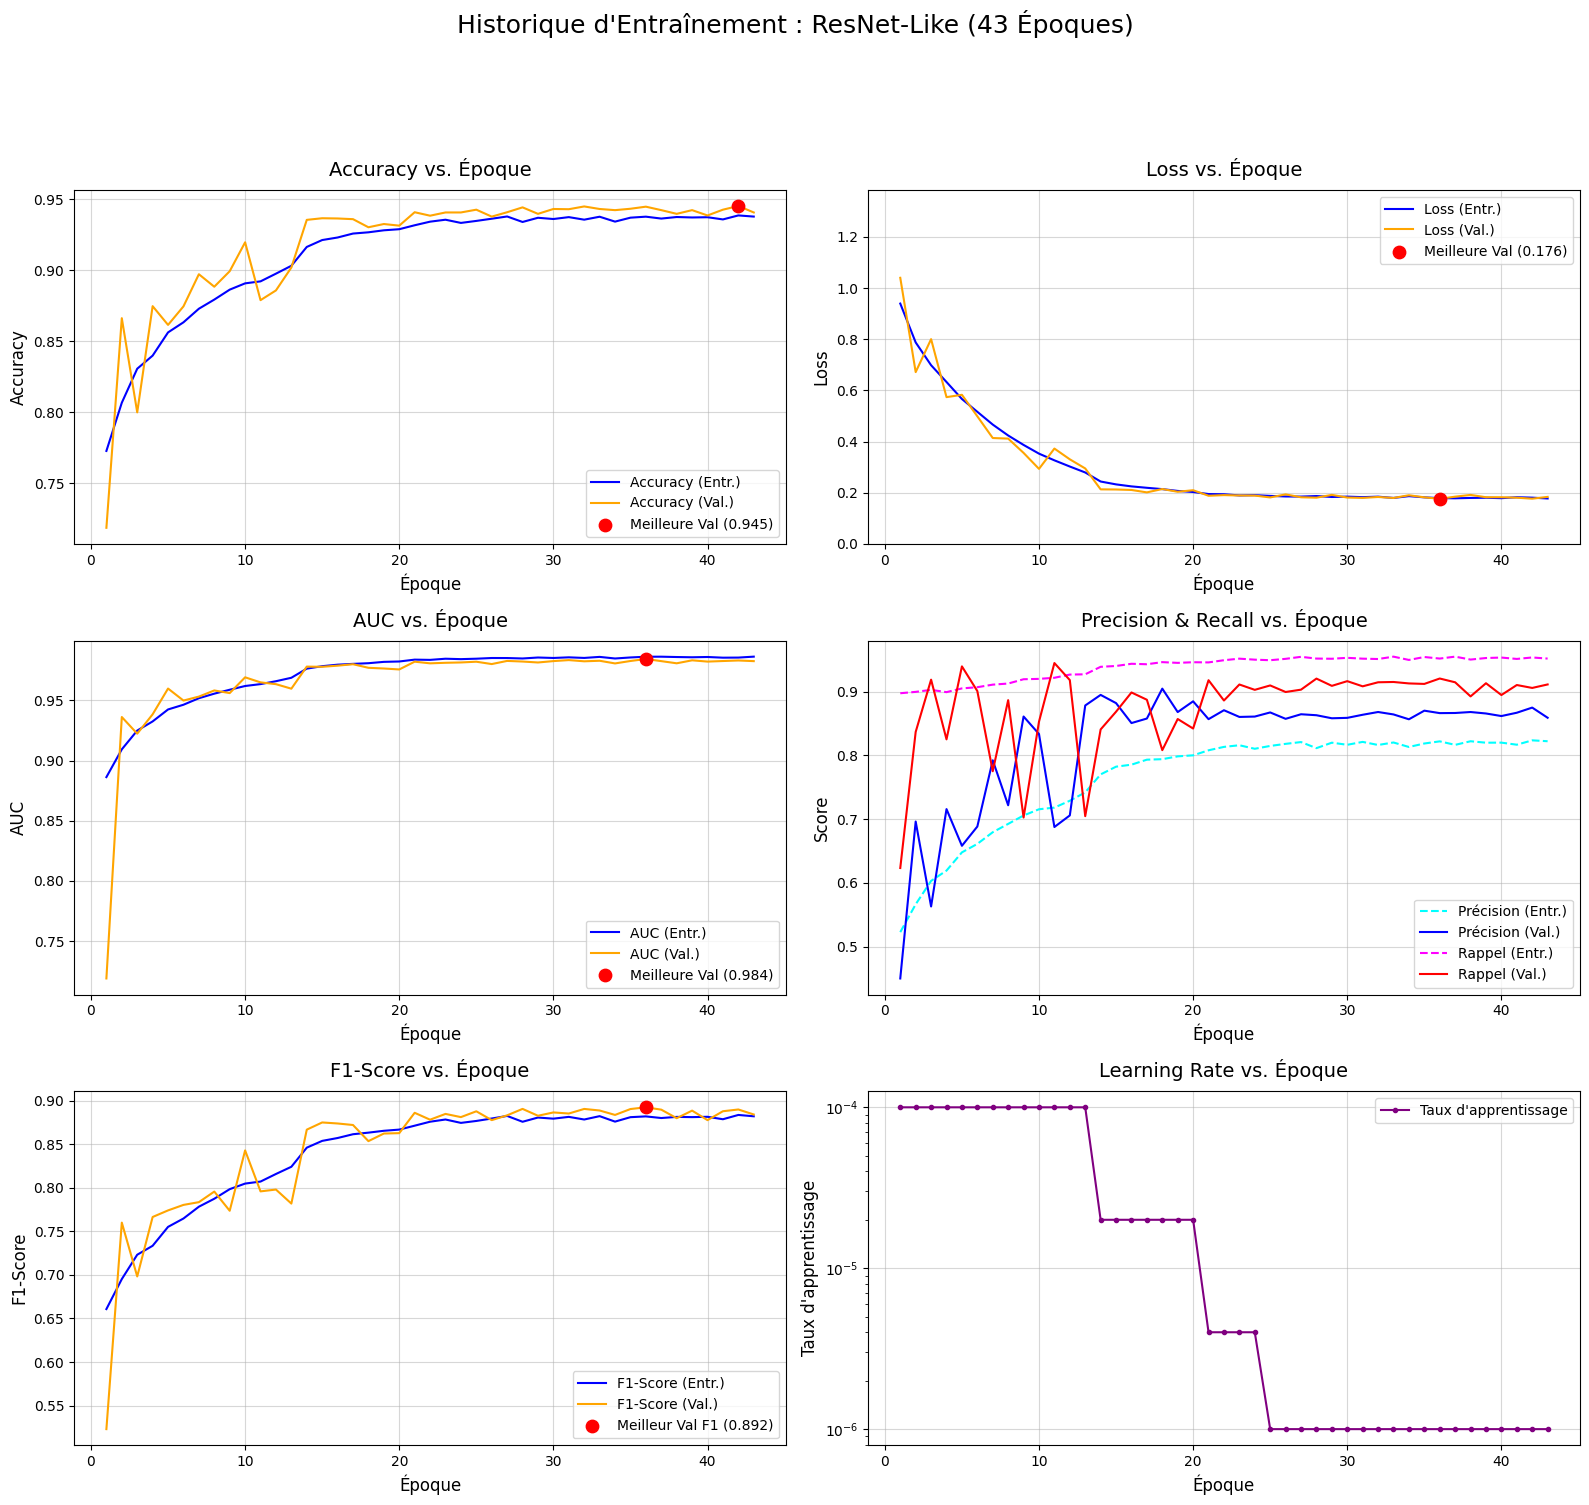


   -> Calcul et affichage de la matrice de confusion pour ResNet-Like (Test Set)...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


95/95 [==============================] - 31s 66ms/step


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


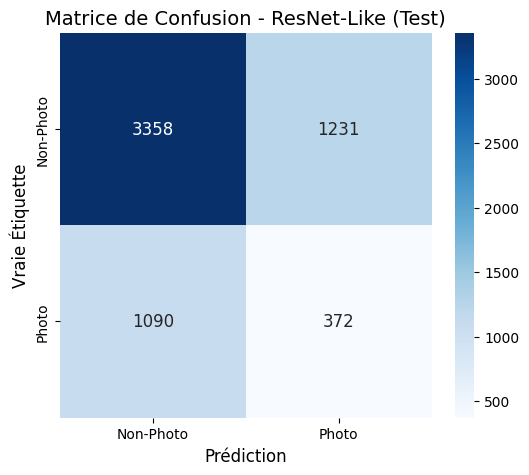


   -> Nettoyage final de la mémoire pour ResNet-Like...
   -> Mémoire nettoyée.

 Traitement du Modèle : DenseNet-Like 
[1/7] Nettoyage de la session Keras...
[2/7] Construction de l'architecture DenseNet-Like...
   -> Modèle DenseNet-Like construit.
[3/7] Chemin de sauvegarde du meilleur modèle : /workspace/checkpoints/best_densenetlike_model.keras
[4/7] Callbacks configurés (EarlyStopping, ReduceLR, ModelCheckpoint spécifique).

[5/7] Démarrage de l'entraînement pour DenseNet-Like (max 60 époques)...
Epoch 1/60


E0000 00:00:1743945271.387023     145 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDenseNet-Like/dense_block1_layer0_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


445/445 [==============================] - ETA: 0s - loss: 0.7790 - accuracy: 0.7953 - auc: 0.9021 - precision: 0.5506 - recall: 0.9099

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 1: val_auc improved from -inf to 0.72092, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 171s 325ms/step - loss: 0.7790 - accuracy: 0.7953 - auc: 0.9021 - precision: 0.5506 - recall: 0.9099 - val_loss: 0.9378 - val_accuracy: 0.7453 - val_auc: 0.7209 - val_precision: 0.4663 - val_recall: 0.0985 - lr: 1.0000e-04
Epoch 2/60
445/445 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.8170 - auc: 0.9193 - precision: 0.5812 - recall: 0.9065

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 2: val_auc improved from 0.72092 to 0.94581, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 152s 338ms/step - loss: 0.6592 - accuracy: 0.8170 - auc: 0.9193 - precision: 0.5812 - recall: 0.9065 - val_loss: 0.5472 - val_accuracy: 0.8809 - val_auc: 0.9458 - val_precision: 0.8239 - val_recall: 0.6561 - lr: 1.0000e-04
Epoch 3/60
445/445 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.8405 - auc: 0.9336 - precision: 0.6199 - recall: 0.9021

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 3: val_auc did not improve from 0.94581
445/445 [==============================] - 144s 320ms/step - loss: 0.5988 - accuracy: 0.8405 - auc: 0.9336 - precision: 0.6199 - recall: 0.9021 - val_loss: 0.8008 - val_accuracy: 0.8055 - val_auc: 0.8946 - val_precision: 0.8853 - val_recall: 0.2637 - lr: 1.0000e-04
Epoch 4/60
445/445 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.8503 - auc: 0.9397 - precision: 0.6375 - recall: 0.9019

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 4: val_auc did not improve from 0.94581
445/445 [==============================] - 142s 317ms/step - loss: 0.5615 - accuracy: 0.8503 - auc: 0.9397 - precision: 0.6375 - recall: 0.9019 - val_loss: 0.5403 - val_accuracy: 0.8734 - val_auc: 0.9333 - val_precision: 0.7945 - val_recall: 0.6625 - lr: 1.0000e-04
Epoch 5/60
445/445 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.8653 - auc: 0.9487 - precision: 0.6654 - recall: 0.9058

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 5: val_auc did not improve from 0.94581
445/445 [==============================] - 147s 327ms/step - loss: 0.5173 - accuracy: 0.8653 - auc: 0.9487 - precision: 0.6654 - recall: 0.9058 - val_loss: 0.5287 - val_accuracy: 0.8779 - val_auc: 0.9338 - val_precision: 0.7508 - val_recall: 0.7664 - lr: 1.0000e-04
Epoch 6/60
445/445 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.8731 - auc: 0.9529 - precision: 0.6801 - recall: 0.9108

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 6: val_auc improved from 0.94581 to 0.94837, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 141s 315ms/step - loss: 0.4861 - accuracy: 0.8731 - auc: 0.9529 - precision: 0.6801 - recall: 0.9108 - val_loss: 0.4624 - val_accuracy: 0.9022 - val_auc: 0.9484 - val_precision: 0.8381 - val_recall: 0.7507 - lr: 1.0000e-04
Epoch 7/60
445/445 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8794 - auc: 0.9567 - precision: 0.6929 - recall: 0.9120

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 7: val_auc improved from 0.94837 to 0.95506, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 146s 324ms/step - loss: 0.4571 - accuracy: 0.8794 - auc: 0.9567 - precision: 0.6929 - recall: 0.9120 - val_loss: 0.4486 - val_accuracy: 0.8854 - val_auc: 0.9551 - val_precision: 0.7175 - val_recall: 0.8840 - lr: 1.0000e-04
Epoch 8/60
445/445 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.8887 - auc: 0.9603 - precision: 0.7110 - recall: 0.9196

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 8: val_auc improved from 0.95506 to 0.95958, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 143s 319ms/step - loss: 0.4272 - accuracy: 0.8887 - auc: 0.9603 - precision: 0.7110 - recall: 0.9196 - val_loss: 0.4026 - val_accuracy: 0.9035 - val_auc: 0.9596 - val_precision: 0.8015 - val_recall: 0.8187 - lr: 1.0000e-04
Epoch 9/60
445/445 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8927 - auc: 0.9638 - precision: 0.7198 - recall: 0.9207

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 9: val_auc improved from 0.95958 to 0.96148, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 144s 320ms/step - loss: 0.3998 - accuracy: 0.8927 - auc: 0.9638 - precision: 0.7198 - recall: 0.9207 - val_loss: 0.3826 - val_accuracy: 0.9095 - val_auc: 0.9615 - val_precision: 0.8258 - val_recall: 0.8119 - lr: 1.0000e-04
Epoch 10/60
445/445 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8952 - auc: 0.9654 - precision: 0.7250 - recall: 0.9220

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 10: val_auc did not improve from 0.96148
445/445 [==============================] - 143s 318ms/step - loss: 0.3787 - accuracy: 0.8952 - auc: 0.9654 - precision: 0.7250 - recall: 0.9220 - val_loss: 0.4252 - val_accuracy: 0.8867 - val_auc: 0.9486 - val_precision: 0.8309 - val_recall: 0.6768 - lr: 1.0000e-04
Epoch 11/60
445/445 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9029 - auc: 0.9685 - precision: 0.7410 - recall: 0.9280

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 11: val_auc did not improve from 0.96148
445/445 [==============================] - 143s 318ms/step - loss: 0.3538 - accuracy: 0.9029 - auc: 0.9685 - precision: 0.7410 - recall: 0.9280 - val_loss: 0.3911 - val_accuracy: 0.8963 - val_auc: 0.9598 - val_precision: 0.9050 - val_recall: 0.6450 - lr: 1.0000e-04
Epoch 12/60
445/445 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.9052 - auc: 0.9708 - precision: 0.7466 - recall: 0.9283

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 12: val_auc did not improve from 0.96148
445/445 [==============================] - 145s 323ms/step - loss: 0.3316 - accuracy: 0.9052 - auc: 0.9708 - precision: 0.7466 - recall: 0.9283 - val_loss: 0.3496 - val_accuracy: 0.9119 - val_auc: 0.9594 - val_precision: 0.8580 - val_recall: 0.7687 - lr: 1.0000e-04
Epoch 13/60
445/445 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9070 - auc: 0.9718 - precision: 0.7515 - recall: 0.9269

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 13: val_auc improved from 0.96148 to 0.96176, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 144s 320ms/step - loss: 0.3177 - accuracy: 0.9070 - auc: 0.9718 - precision: 0.7515 - recall: 0.9269 - val_loss: 0.3651 - val_accuracy: 0.8940 - val_auc: 0.9618 - val_precision: 0.9022 - val_recall: 0.6447 - lr: 1.0000e-04
Epoch 14/60
445/445 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.9113 - auc: 0.9733 - precision: 0.7596 - recall: 0.9335

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 14: val_auc improved from 0.96176 to 0.97404, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 144s 320ms/step - loss: 0.3009 - accuracy: 0.9113 - auc: 0.9733 - precision: 0.7596 - recall: 0.9335 - val_loss: 0.2820 - val_accuracy: 0.9198 - val_auc: 0.9740 - val_precision: 0.9004 - val_recall: 0.7677 - lr: 1.0000e-04
Epoch 15/60
445/445 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9138 - auc: 0.9750 - precision: 0.7663 - recall: 0.9325

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 15: val_auc did not improve from 0.97404
445/445 [==============================] - 143s 319ms/step - loss: 0.2844 - accuracy: 0.9138 - auc: 0.9750 - precision: 0.7663 - recall: 0.9325 - val_loss: 0.2797 - val_accuracy: 0.9201 - val_auc: 0.9698 - val_precision: 0.8597 - val_recall: 0.8054 - lr: 1.0000e-04
Epoch 16/60
445/445 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9126 - auc: 0.9747 - precision: 0.7632 - recall: 0.9328

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 16: val_auc improved from 0.97404 to 0.97762, saving model to /workspace/checkpoints/best_densenetlike_model.keras
445/445 [==============================] - 143s 319ms/step - loss: 0.2779 - accuracy: 0.9126 - auc: 0.9747 - precision: 0.7632 - recall: 0.9328 - val_loss: 0.2427 - val_accuracy: 0.9326 - val_auc: 0.9776 - val_precision: 0.8969 - val_recall: 0.8243 - lr: 1.0000e-04
Epoch 17/60
445/445 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9198 - auc: 0.9773 - precision: 0.7797 - recall: 0.9378

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 17: val_auc did not improve from 0.97762
445/445 [==============================] - 144s 320ms/step - loss: 0.2601 - accuracy: 0.9198 - auc: 0.9773 - precision: 0.7797 - recall: 0.9378 - val_loss: 0.3018 - val_accuracy: 0.9074 - val_auc: 0.9625 - val_precision: 0.8711 - val_recall: 0.7453 - lr: 1.0000e-04
Epoch 18/60
445/445 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9191 - auc: 0.9780 - precision: 0.7785 - recall: 0.9362

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 18: val_auc did not improve from 0.97762
445/445 [==============================] - 145s 318ms/step - loss: 0.2513 - accuracy: 0.9191 - auc: 0.9780 - precision: 0.7785 - recall: 0.9362 - val_loss: 0.5607 - val_accuracy: 0.8407 - val_auc: 0.9083 - val_precision: 0.9351 - val_recall: 0.3802 - lr: 1.0000e-04
Epoch 19/60
445/445 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9240 - auc: 0.9793 - precision: 0.7898 - recall: 0.9399

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 19: val_auc did not improve from 0.97762
445/445 [==============================] - 143s 319ms/step - loss: 0.2389 - accuracy: 0.9240 - auc: 0.9793 - precision: 0.7898 - recall: 0.9399 - val_loss: 0.2386 - val_accuracy: 0.9253 - val_auc: 0.9757 - val_precision: 0.8883 - val_recall: 0.8052 - lr: 1.0000e-04
Epoch 20/60
445/445 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9252 - auc: 0.9806 - precision: 0.7917 - recall: 0.9429

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 20: val_auc did not improve from 0.97762
445/445 [==============================] - 143s 320ms/step - loss: 0.2283 - accuracy: 0.9252 - auc: 0.9806 - precision: 0.7917 - recall: 0.9429 - val_loss: 0.7011 - val_accuracy: 0.8285 - val_auc: 0.8876 - val_precision: 0.9089 - val_recall: 0.3412 - lr: 1.0000e-04
Epoch 21/60
445/445 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9252 - auc: 0.9808 - precision: 0.7914 - recall: 0.9434

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 21: val_auc did not improve from 0.97762
445/445 [==============================] - 143s 319ms/step - loss: 0.2230 - accuracy: 0.9252 - auc: 0.9808 - precision: 0.7914 - recall: 0.9434 - val_loss: 0.7708 - val_accuracy: 0.8224 - val_auc: 0.8653 - val_precision: 0.9312 - val_recall: 0.3098 - lr: 1.0000e-04
Epoch 22/60
445/445 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9286 - auc: 0.9823 - precision: 0.8025 - recall: 0.9399

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 22: val_auc did not improve from 0.97762
445/445 [==============================] - 145s 323ms/step - loss: 0.2125 - accuracy: 0.9286 - auc: 0.9823 - precision: 0.8025 - recall: 0.9399 - val_loss: 0.2374 - val_accuracy: 0.9268 - val_auc: 0.9740 - val_precision: 0.8949 - val_recall: 0.7987 - lr: 1.0000e-04
Epoch 23/60
445/445 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9288 - auc: 0.9828 - precision: 0.7997 - recall: 0.9464

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 23: val_auc did not improve from 0.97762
445/445 [==============================] - 143s 319ms/step - loss: 0.2060 - accuracy: 0.9288 - auc: 0.9828 - precision: 0.7997 - recall: 0.9464 - val_loss: 0.3221 - val_accuracy: 0.9036 - val_auc: 0.9599 - val_precision: 0.9246 - val_recall: 0.6729 - lr: 1.0000e-04
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 16.
   -> Entraînement de DenseNet-Like terminé en 3341.7 secondes (23 époques effectuées).

[6/7] Chargement du meilleur modèle (DenseNet-Like) depuis : /workspace/checkpoints/best_densenetlike_model.keras
   -> Meilleur modèle chargé depuis le fichier checkpoint.

[7/7] Évaluation du meilleur modèle (DenseNet-Like) sur l'ensemble de test...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


   --- Résultats sur l'ensemble de test ---
     loss: 0.2454
     accuracy: 0.9317
     auc: 0.9776
     precision: 0.8942
     recall: 0.8267
     f1_score: 0.8591
     training_time_sec: 3341.6964
     epochs_run: 23.0000
   ----------------------------------------

   -> Affichage de l'historique d'entraînement pour DenseNet-Like...
    -> Métriques disponibles pour le tracé : ['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr']


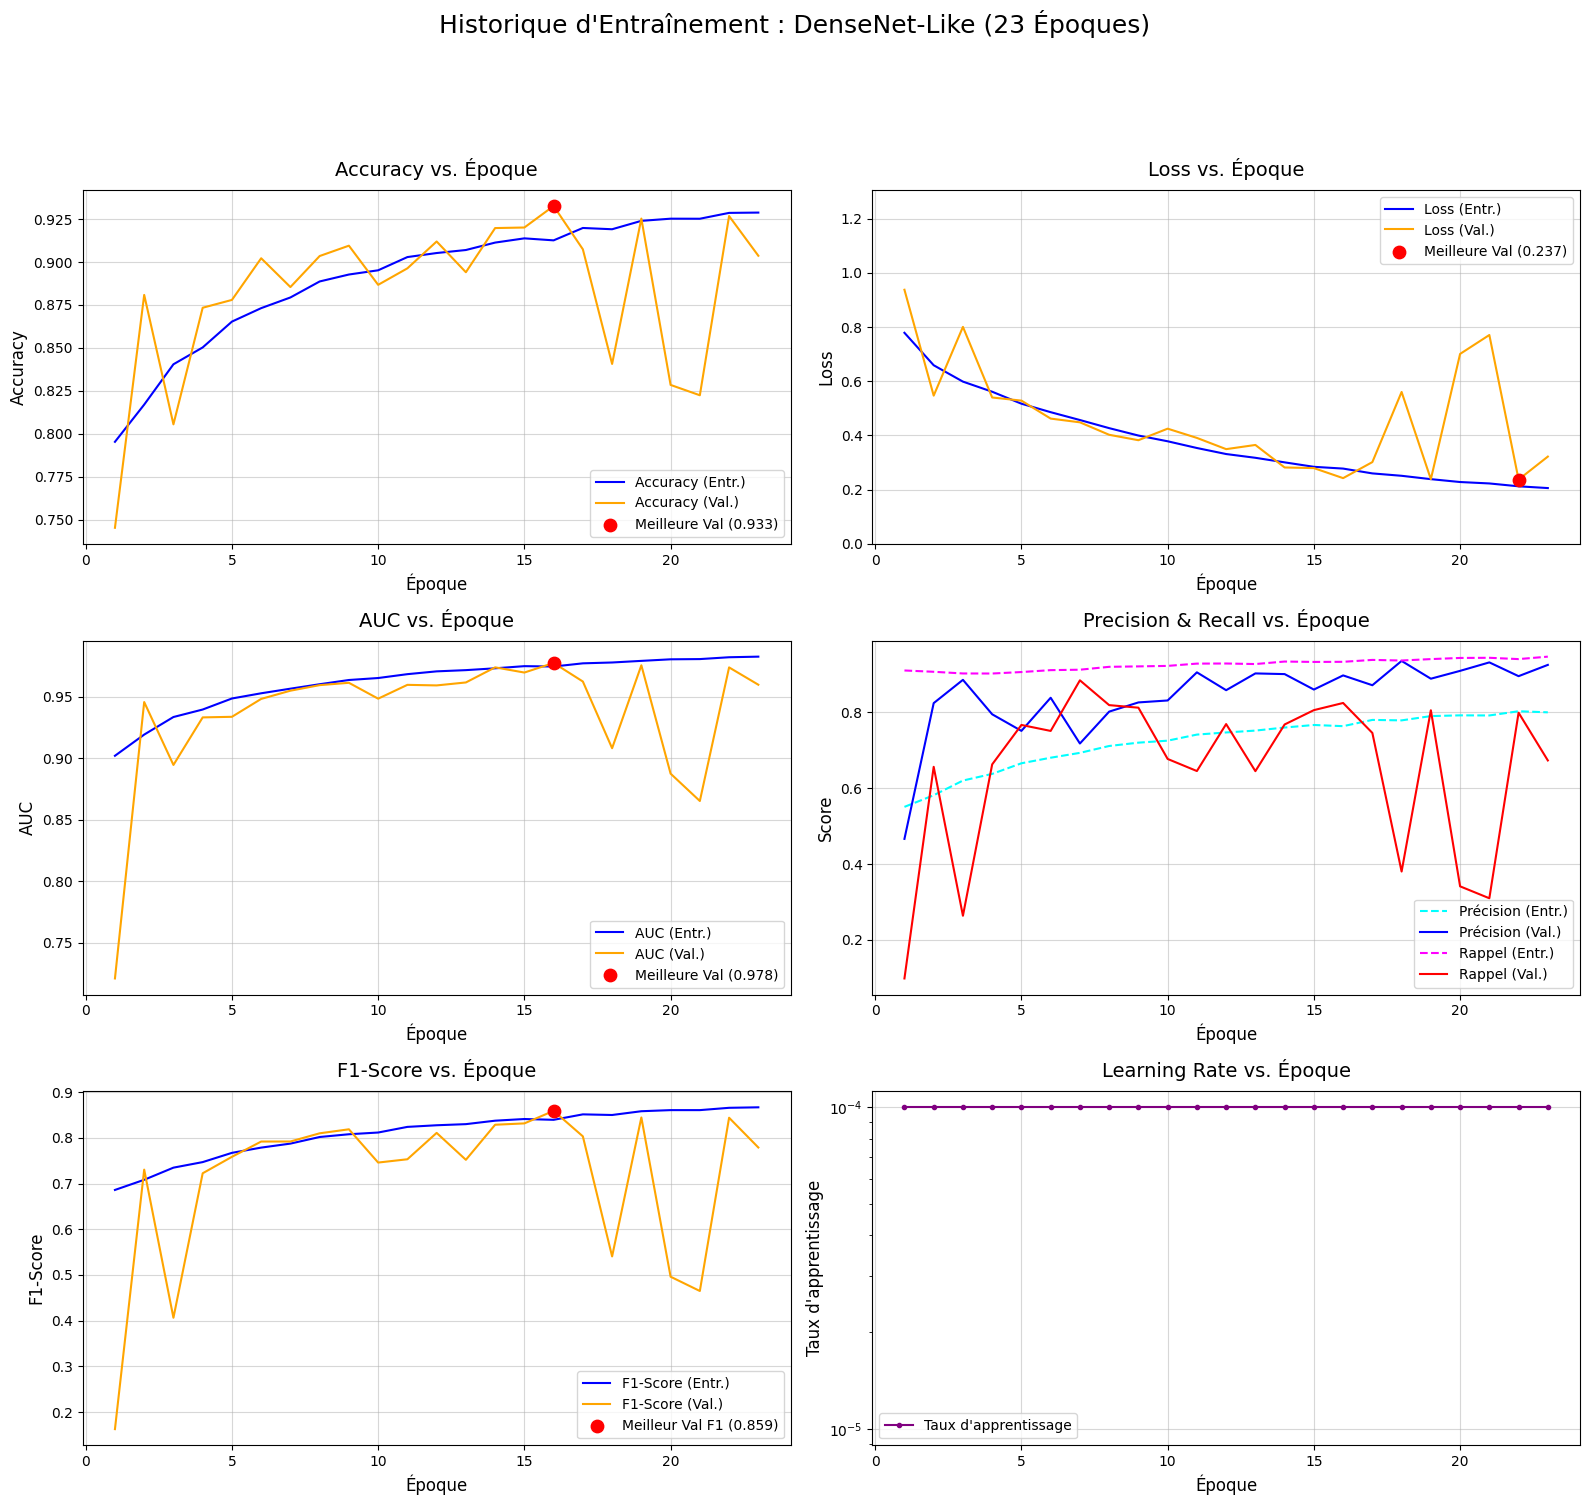


   -> Calcul et affichage de la matrice de confusion pour DenseNet-Like (Test Set)...


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


95/95 [==============================] - 31s 56ms/step


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


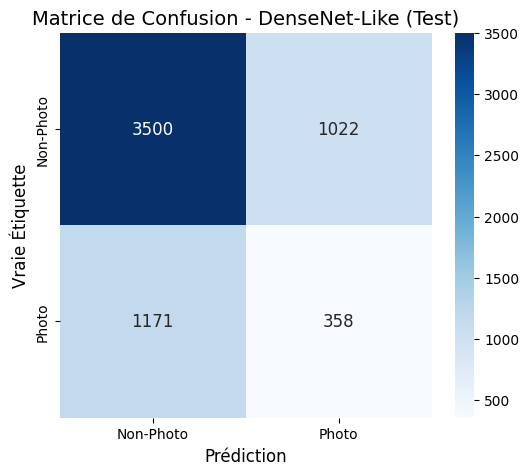


   -> Nettoyage final de la mémoire pour DenseNet-Like...
   -> Mémoire nettoyée.

######## Boucle d'Entraînement Terminée ########


In [11]:
# Dictionnaires pour stocker les informations pendant la boucle
model_builders = {
    "EfficientNet-Like": build_efficientnet_like,
    "GoogLeNet-Like": build_googlenet_like,
    "ResNet-Like": build_ResNetLite_model, # Remplacement de VGG
    "DenseNet-Like": build_densenet_like
}
print(f"Architectures à entraîner : {list(model_builders.keys())}")

training_histories = {} # Pour stocker les historiques d'entraînement (métriques par époque)
test_results_all = {}   # Pour stocker les résultats finaux sur l'ensemble de test
best_model_paths = {}   # Pour stocker les chemins vers les meilleurs checkpoints sauvegardés

# Nombre maximal d'époques pour l'entraînement (sera souvent arrêté avant par EarlyStopping)
epochs_to_run = 60 

# Vérification finale de la disponibilité des datasets avant de lancer la boucle
datasets_available = ('train_set' in locals() and train_set) and \
                     ('val_set' in locals() and val_set) and \
                     ('test_set' in locals() and test_set)

if not datasets_available:
    print("\nERREUR CRITIQUE : Les datasets ne sont pas correctement initialisés. "
          "Vérifiez les étapes de chargement et de prétraitement. Arrêt.")
else:
    print(f"\nPrêt à démarrer la boucle d'entraînement pour {len(model_builders)} modèles (max {epochs_to_run} époques chacun)...")
    # --- Boucle Principale d'Entraînement et Évaluation ---
    for model_name, builder_func in model_builders.items():
        print(f"\n{'='*30}")
        print(f" Traitement du Modèle : {model_name} ")
        print(f"{'='*30}")

        model = None # Assurer que model est None au début de chaque itération
        loaded_best_model = None
        history = None
        
        try:
            # 1. Nettoyer la session Keras précédente
            print("[1/7] Nettoyage de la session Keras...")
            tf.keras.backend.clear_session()

            # 2. Construire le modèle
            print(f"[2/7] Construction de l'architecture {model_name}...")
            model = builder_func(image_h, image_w)
            print(f"   -> Modèle {model.name} construit.")
            # model.summary(line_length=110) # Optionnel: Afficher le résumé ici si besoin

            # 3. Définir le chemin unique pour le checkpoint de ce modèle
            safe_model_name = model_name.replace(' ', '_').replace('-', '').lower()
            checkpoint_filepath = os.path.join(checkpoints_dir, f'best_{safe_model_name}_model.keras')
            best_model_paths[model_name] = checkpoint_filepath
            print(f"[3/7] Chemin de sauvegarde du meilleur modèle : {checkpoint_filepath}")

            # 4. Créer le callback ModelCheckpoint pour sauvegarder le meilleur modèle basé sur val_auc
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                monitor='val_auc',       
                mode='max',              
                save_best_only=True,     
                verbose=1                
            )

            # Liste complète des callbacks pour cet entraînement
            callbacks_list = [early_stopping, reduce_lr, model_checkpoint_callback]
            print("[4/7] Callbacks configurés (EarlyStopping, ReduceLR, ModelCheckpoint spécifique)." )            

            # 5. Entraîner le modèle
            print(f"\n[5/7] Démarrage de l'entraînement pour {model_name} (max {epochs_to_run} époques)...")
            start_time = time.time()
            
            history = model.fit(
                train_set,                 # Données d'entraînement
                validation_data=val_set,   # Données de validation pour le monitoring
                epochs=epochs_to_run,      # Nombre maximal d'époques
                callbacks=callbacks_list,  # Callbacks pour contrôler l'entraînement
                class_weight=class_weight_dict, # Poids pour gérer le déséquilibre (peut être None)
                verbose=1                  # Afficher la progression (1 ligne par époque)
            )
            
            training_time = time.time() - start_time
            epochs_completed = len(history.history['loss']) # Nombre réel d'époques effectuées
            print(f"   -> Entraînement de {model_name} terminé en {training_time:.1f} secondes ({epochs_completed} époques effectuées).")

            # 6. Stocker l'historique d'entraînement
            training_histories[model_name] = history.history
            
            # 7. Charger le meilleur modèle explicitement depuis le fichier sauvegardé
            print(f"\n[6/7] Chargement du meilleur modèle ({model_name}) depuis : {checkpoint_filepath}")
            if os.path.exists(checkpoint_filepath):
                loaded_best_model = tf.keras.models.load_model(checkpoint_filepath) # Charger depuis le .keras
                print("   -> Meilleur modèle chargé depuis le fichier checkpoint.")
            else:
                print("   -> AVERTISSEMENT : Fichier checkpoint non trouvé ! Utilisation du modèle final en mémoire (restauré par EarlyStopping si activé).")
                # EarlyStopping (avec restore_best_weights=True) devrait avoir restauré les meilleurs poids en mémoire
                loaded_best_model = model 
            
            # --- Évaluation sur l'Ensemble de Test --- 
            if loaded_best_model:
                print(f"\n[7/7] Évaluation du meilleur modèle ({model_name}) sur l'ensemble de test...")
                test_results = loaded_best_model.evaluate(test_set, verbose=0) # verbose=0 pour moins de sortie

                # Stocker les résultats dans un dictionnaire propre
                results_dict = dict(zip(loaded_best_model.metrics_names, test_results))

                # Calculer et ajouter le F1-score
                precision = results_dict.get('precision', 0)
                recall = results_dict.get('recall', 0)
                if (precision + recall) > 0:
                    results_dict['f1_score'] = 2 * (precision * recall) / (precision + recall)
                else:
                    results_dict['f1_score'] = 0.0
                
                # Ajouter infos entraînement
                results_dict['training_time_sec'] = training_time
                results_dict['epochs_run'] = epochs_completed

                # Sauvegarder les résultats finaux pour ce modèle
                test_results_all[model_name] = results_dict
                print("   --- Résultats sur l'ensemble de test ---")
                for name, value in results_dict.items():
                     print(f"     {name}: {value:.4f}")
                print("   ----------------------------------------")
                
                # --- Visualisations pour ce modèle --- 
                # Afficher l'historique d'entraînement
                print(f"\n   -> Affichage de l'historique d'entraînement pour {model_name}...")
                plot_training_history(history, model_name)
                
                # Afficher la Matrice de Confusion
                print(f"\n   -> Calcul et affichage de la matrice de confusion pour {model_name} (Test Set)...")
                try:
                    test_predictions_probs = loaded_best_model.predict(test_set) # Prédictions (probs)
                    test_predicted_classes = (test_predictions_probs > 0.5).astype(int).flatten() # Classes prédites
                    test_true_labels = np.concatenate([y for x, y in test_set], axis=0).flatten().astype(int) # Vraies classes
                    
                    cm = confusion_matrix(test_true_labels, test_predicted_classes)
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=target_class_names, yticklabels=target_class_names, 
                                annot_kws={"size": 12})
                    plt.xlabel('Prédiction', fontsize=12)
                    plt.ylabel('Vraie Étiquette', fontsize=12)
                    plt.title(f'Matrice de Confusion - {model_name} (Test)', fontsize=14)
                    plt.show()
                except Exception as cm_error:
                    print(f"      Erreur lors de la génération de la matrice de confusion : {cm_error}")

            else:
                 print(f"   -> ERREUR: Aucun modèle n'a pu être chargé pour l'évaluation de {model_name}.")
                 test_results_all[model_name] = {'error': 'Model loading failed before evaluation'}
                 
        except Exception as e:
            # Attraper toute autre erreur pendant le processus pour ce modèle
            print(f"\n! ERREUR INATTENDUE pendant le traitement du modèle {model_name} : {e} !")
            import traceback
            traceback.print_exc() # Afficher la trace complète de l'erreur
            test_results_all[model_name] = {'error': f'Unexpected error: {e}'}
            # Continuer avec le modèle suivant
            
        finally:
            # Nettoyage final pour ce tour de boucle (même en cas d'erreur)
            print(f"\n   -> Nettoyage final de la mémoire pour {model_name}...")
            if model is not None: del model
            if loaded_best_model is not None: del loaded_best_model
            if history is not None: del history
            tf.keras.backend.clear_session()
            import gc
            gc.collect() # Forcer le garbage collection
            print(f"   -> Mémoire nettoyée.")
            print(f"{'='*30}")

print("\n######## Boucle d'Entraînement Terminée ########")

### Comparaison des Performances des Modèles

**Quoi :** Centralise, affiche et analyse les résultats finaux de tous les modèles évalués sur l'ensemble de test afin d'identifier le plus performant.

**Comment :**
1.  **Collecte des Données :** Utilise le dictionnaire `test_results_all` qui a été peuplé pendant la boucle d'entraînement avec les métriques de test de chaque modèle.
2.  **Filtrage des Erreurs :** Sépare les résultats valides des éventuelles erreurs (modèles qui n'ont pas pu être construits, entraînés ou évalués).
3.  **Création du DataFrame :** Les résultats valides sont convertis en un DataFrame `pandas`. Chaque ligne représente un modèle et chaque colonne une métrique (`auc`, `f1_score`, `recall`, `precision`, `accuracy`, `loss`) ou une information d'entraînement (`epochs_run`, `training_time_sec`).
4.  **Sélection et Ordre des Colonnes :** Définit les colonnes d'intérêt et leur ordre pour l'affichage.
5.  **Tri Hiérarchique :** Le DataFrame est trié selon plusieurs critères, par ordre d'importance décroissante (paramétrable via `sort_priority`) :
    *   AUC (décroissant) : Capacité globale de discrimination.
    *   F1-Score (décroissant) : Équilibre entre Précision et Rappel.
    *   Recall (décroissant) : Capacité à identifier les 'Photos' (minimise les Faux Négatifs).
    *   Precision (décroissant) : Fiabilité des prédictions 'Photo' (minimise les Faux Positifs).
    *   Accuracy (décroissant) : Précision globale.
6.  **Affichage du Tableau Comparatif :** Le DataFrame trié est affiché, permettant une comparaison visuelle rapide des performances.
7.  **Identification du Meilleur :** Le modèle apparaissant en première ligne du DataFrame trié est déclaré comme le `overall_best_model_name`.
8.  **Affichage du Meilleur :** Les métriques spécifiques et le chemin vers le fichier `.keras` du meilleur modèle sont affichés.
9.  **Rapport des Erreurs :** Les éventuels messages d'erreur stockés pour les modèles ayant échoué sont également affichés.

**Pourquoi :**
*   **Vision Globale :** Rassembler tous les résultats en un seul endroit structuré (le DataFrame) est essentiel pour comparer efficacement les différentes approches architecturales.
*   **Décision Basée sur les Données :** Le tri selon des critères priorisés permet d'identifier objectivement le modèle qui répond le mieux aux exigences du problème. L'ordre des priorités (AUC, F1, Recall, Precision) peut être ajusté en fonction des coûts relatifs des différents types d'erreurs (est-il pire de manquer une vraie photo ou de classer une non-photo comme photo ?).
*   **Transparence :** Afficher le tableau complet et les erreurs éventuelles rend le processus de sélection transparent.

In [12]:
print(f"\n{'='*30}")
print(" Comparaison des Performances Finales des Modèles")
print(f"{'='*30}")

# Vérifier si des résultats ont été stockés
if not test_results_all:
    print("Aucun résultat d'évaluation de modèle n'est disponible pour la comparaison.")
else:
    # Séparer les résultats valides des erreurs
    valid_results = {name: metrics for name, metrics in test_results_all.items() if 'error' not in metrics}
    failed_models_report = {name: metrics['error'] for name, metrics in test_results_all.items() if 'error' in metrics}
    
    overall_best_model_name = None # Initialiser
    overall_best_model_path = None

    if not valid_results:
        print("Aucun résultat d'évaluation VALIDE trouvé. Impossible de comparer les modèles.")
    else:
        # Convertir les résultats valides en DataFrame pour faciliter le traitement
        results_df = pd.DataFrame.from_dict(valid_results, orient='index')
        print(f"Comparaison des {len(results_df)} modèles ayant terminé avec succès:")

        # Définir les colonnes à afficher et l'ordre souhaité
        display_cols = ['auc', 'f1_score', 'recall', 'precision', 'accuracy', 'loss', 'epochs_run', 'training_time_sec']
        # S'assurer que seules les colonnes existantes sont utilisées (au cas où une métrique manquerait)
        available_cols = [col for col in display_cols if col in results_df.columns]
        results_df = results_df[available_cols]

        # Définir les critères de tri par ordre de priorité (colonne, ascendant=False signifie décroissant)
        sort_priority = [
            ('auc', False),       # Priorité 1: AUC (maximiser)
            ('f1_score', False),  # Priorité 2: F1-Score (maximiser - équilibre Prec/Recall)
            ('recall', False),    # Priorité 3: Recall (maximiser - trouver les 'Photos')
            ('precision', False), # Priorité 4: Precision (maximiser - éviter fausses 'Photos')
            ('accuracy', False),  # Priorité 5: Accuracy (maximiser)
            ('loss', True)        # Priorité 6: Loss (minimiser)
        ]
        
        # Filtrer les critères de tri pour n'inclure que les colonnes disponibles
        active_sort_priority = [(col, asc) for col, asc in sort_priority if col in results_df.columns]
        sort_by_cols = [col for col, asc in active_sort_priority]
        sort_ascending = [asc for col, asc in active_sort_priority]
        
        # Trier le DataFrame
        if sort_by_cols:
            results_df_sorted = results_df.sort_values(by=sort_by_cols, ascending=sort_ascending)
            print(f"\nTableau Récapitulatif des Performances sur l'Ensemble de Test (Trié par {', '.join(sort_by_cols)}):")
        else:
            results_df_sorted = results_df # Aucun tri possible si les colonnes manquent
            print("\nTableau Récapitulatif des Performances sur l'Ensemble de Test (Non trié car colonnes de tri manquantes):")
            
        # Afficher le DataFrame trié avec un formatage numérique
        pd.options.display.float_format = '{:.4f}'.format # Définir le formatage pour l'affichage
        print(results_df_sorted)
        pd.reset_option('display.float_format') # Rétablir le formatage par défaut
        
        # Déterminer le meilleur modèle (la première ligne après tri)
        if not results_df_sorted.empty:
            best_model_name = results_df_sorted.index[0]
            best_model_metrics = results_df_sorted.iloc[0]
            print(f"\n{'*'*15} Meilleur Modèle Identifié : {best_model_name} {'*'*15}")
            print("--> Métriques Clés sur l'Ensemble de Test:")
            # Afficher les métriques clés du meilleur
            print(f"    AUC       : {best_model_metrics.get('auc', 'N/A'):.4f}")
            print(f"    F1-Score  : {best_model_metrics.get('f1_score', 'N/A'):.4f}")
            print(f"    Recall    : {best_model_metrics.get('recall', 'N/A'):.4f}")
            print(f"    Precision : {best_model_metrics.get('precision', 'N/A'):.4f}")
            print(f"    Accuracy  : {best_model_metrics.get('accuracy', 'N/A'):.4f}")
            print(f"    Loss      : {best_model_metrics.get('loss', 'N/A'):.4f}")
            print(f"--> Informations d'Entraînement:")
            print(f"    Époques   : {int(best_model_metrics.get('epochs_run', 'N/A'))}")
            print(f"    Temps     : {best_model_metrics.get('training_time_sec', 'N/A'):.1f} sec")
            
            # Stocker le nom et le chemin pour l'analyse post-hoc
            overall_best_model_name = best_model_name
            overall_best_model_path = best_model_paths.get(overall_best_model_name)
            if overall_best_model_path and os.path.exists(overall_best_model_path):
                 print(f"--> Chemin Checkpoint : {overall_best_model_path}")
            else:
                 print(f"--> AVERTISSEMENT: Chemin Checkpoint non trouvé ou invalide pour le meilleur modèle ({overall_best_model_path})")
                 overall_best_model_path = None # Invalider pour l'étape suivante
        else:
            print("\nImpossible de déterminer le meilleur modèle (DataFrame trié vide).")

    # Afficher les erreurs des modèles qui ont échoué, s'il y en a
    if failed_models_report:
        print("\n--- Modèles ayant rencontré une Erreur lors de l'exécution ---")
        for name, error_msg in failed_models_report.items():
            print(f"  - Modèle : {name}")
            print(f"    Erreur : {error_msg}")
        print("-------------------------------------------------------------")


 Comparaison des Performances Finales des Modèles
Comparaison des 4 modèles ayant terminé avec succès:

Tableau Récapitulatif des Performances sur l'Ensemble de Test (Trié par auc, f1_score, recall, precision, accuracy, loss):
                     auc  f1_score  recall  precision  accuracy   loss  \
ResNet-Like       0.9827    0.8852  0.9088     0.8627    0.9423 0.1823   
DenseNet-Like     0.9776    0.8591  0.8267     0.8942    0.9317 0.2454   
EfficientNet-Like 0.9709    0.8543  0.8695     0.8396    0.9256 0.2984   
GoogLeNet-Like    0.9693    0.8236  0.8980     0.7607    0.9078 0.2151   

                   epochs_run  training_time_sec  
ResNet-Like                43          6610.5315  
DenseNet-Like              23          3341.6964  
EfficientNet-Like          32          4813.2727  
GoogLeNet-Like             18          1545.8117  

*************** Meilleur Modèle Identifié : ResNet-Like ***************
--> Métriques Clés sur l'Ensemble de Test:
    AUC       : 0.9827
    F1-

### Interprétation Détaillée de l'Analyse Comparative

L'évaluation finale des quatre architectures de modèles sur l'ensemble de test, après entraînement et sélection des meilleurs poids basés sur l'AUC de validation, permet une comparaison fine de leurs performances respectives sur des données totalement inédites :

1.  **Capacité de Discrimination Globale (AUC - Aire sous la courbe ROC) :**
    Cette métrique évalue la capacité générale du modèle à distinguer une image 'Photo' d'une image 'Non-Photo' sur l'ensemble des seuils de décision possibles. Un score proche de 1 indique une excellente discrimination.
    *   Le modèle **ResNet-Like** domine nettement avec une **AUC de 0.9827**.
    *   DenseNet-Like suit avec une très bonne performance de 0.9776.
    *   EfficientNet-Like (0.9709) et GoogLeNet-Like (0.9693) affichent des scores légèrement inférieurs mais restent performants.

2.  **Identification des Images 'Photo' (Recall / Sensibilité) :**
    Le Recall mesure la proportion des images réellement 'Photo' que le modèle a réussi à identifier comme telles. Un Recall élevé est crucial si l'objectif est de minimiser les photos manquées (Faux Négatifs).
    *   **ResNet-Like** se distingue à nouveau avec le **Recall le plus élevé (0.9088)**, signifiant qu'il identifie correctement près de 91% de toutes les photos présentes dans l'ensemble de test.
    *   GoogLeNet-Like le talonne de très près avec 0.8980.
    *   EfficientNet-Like atteint un bon score de 0.8695.
    *   DenseNet-Like est notablement moins performant sur ce critère spécifique (0.8267).

3.  **Fiabilité des Prédictions 'Photo' (Precision / Précision) :**
    La Precision indique, parmi toutes les images que le modèle a classées comme 'Photo', quelle proportion était réellement une 'Photo'. Une Precision élevée minimise les classifications erronées de 'Non-Photo' en 'Photo' (Faux Positifs).
    *   **DenseNet-Like** excelle sur ce point avec la **meilleure Precision (0.8942)**. Lorsqu'il prédit "Photo", il a raison dans près de 90% des cas.
    *   ResNet-Like suit avec une bonne Precision de 0.8627.
    *   EfficientNet-Like (0.8396) et surtout GoogLeNet-Like (0.7607) sont moins précis dans leurs prédictions positives.

4.  **Équilibre Précision/Rappel (F1-Score) :**
    Le F1-Score est la moyenne harmonique de la Precision et du Recall. Il fournit une mesure unique qui évalue l'équilibre entre la capacité à trouver toutes les photos et la fiabilité des prédictions positives.
    *   **ResNet-Like** obtient le **meilleur F1-Score (0.8852)**, confirmant son excellent compromis entre Recall et Precision.
    *   DenseNet-Like (0.8591) et EfficientNet-Like (0.8543) montrent un équilibre légèrement moins optimal.
    *   GoogLeNet-Like (0.8236) est le moins performant sur cette métrique combinée.

5.  **Performance Générale (Accuracy et Loss) :**
    L'Accuracy mesure le pourcentage global de classifications correctes (Photos et Non-Photos). La Loss représente l'erreur moyenne du modèle.
    *   **ResNet-Like** est également le **leader** sur ces indicateurs généraux avec l'Accuracy la plus haute (0.9423) et la Loss la plus faible (0.1823).

**Synthèse de l'Analyse :**

Le modèle **ResNet-Like** démontre la supériorité la plus constante à travers les métriques clés. Il domine en AUC, Recall, F1-Score et Accuracy, tout en maintenant une Precision très respectable. Il représente donc le **meilleur choix global** issu de cette série d'expériences, offrant la meilleure capacité de discrimination et le meilleur équilibre pour identifier correctement les photos tout en limitant les erreurs. DenseNet-Like se positionne comme un challenger intéressant, particulièrement fort en Precision, mais son Recall plus faible le pénalise dans l'équilibre général.

### Pistes d'Amélioration Potentielles

Bien que ResNet-Like soit le modèle gagnant de cette série, plusieurs axes d'amélioration pourraient être explorés pour confirmer ce choix et potentiellement améliorer encore les performances (en plus de la correction impérative des erreurs JPEG) :

1.  **Optimisation des Hyperparamètres (Par Modèle) :** Chaque architecture pourrait réagir différemment aux hyperparamètres. Utiliser des outils comme KerasTuner pour rechercher le taux d'apprentissage optimal, les paramètres de l'optimiseur ou les taux de dropout spécifiques à chaque modèle (ResNet-Like, DenseNet-Like, etc.) pourrait révéler leur plein potentiel et affiner la comparaison.

2.  **Stratégie d'Augmentation de Données :** L'augmentation actuelle est générique. Tester des stratégies plus ciblées sur la distinction Photo/Peinture (par ex., variations de couleurs plus importantes, moins de transformations géométriques si l'orientation est clé) pourrait améliorer la robustesse des modèles sur les cas difficiles.

3.  **Validation Croisée (K-Fold Cross-Validation) :** Pour une évaluation plus robuste et moins dépendante de la division initiale unique train/val/test, une validation croisée (ex: 5-Fold) permettrait de calculer les performances moyennes de chaque modèle sur différentes partitions des données, donnant une estimation plus fiable de leur capacité de généralisation.

4.  **Stratégie d'Entraînement et Callbacks :** Les modèles ont convergé à des vitesses différentes. Augmenter légèrement la patience pour `EarlyStopping` (ex: 10-15 époques) pourrait permettre à certains modèles (comme DenseNet-Like ou EfficientNet-Like qui se sont arrêtés plus tôt) d'atteindre une meilleure performance de validation, tout en s'assurant de toujours restaurer les meilleurs poids.

### Analyse Post-Hoc du Meilleur Modèle

**Quoi :** Effectue une analyse plus qualitative sur le modèle jugé le plus performant lors de l'étape de comparaison. L'objectif principal ici est d'examiner spécifiquement les erreurs de type Faux Positifs.

**Comment :**
1.  **Vérification Préalable :** S'assure que la section précédente a bien identifié un `overall_best_model_name`, que le chemin vers son checkpoint (`overall_best_model_path`) est valide et existe, et que l'ensemble de test (`test_set`) est disponible.
2.  **Chargement du Modèle :** Le fichier `.keras` correspondant au meilleur modèle est chargé en mémoire (`final_best_model`).
3.  **Identification des Faux Positifs (FP) :**
    *   Le code itère à travers les lots de l'ensemble de test.
    *   Pour chaque lot, `predict_on_batch` (optimisé pour l'inférence par lot) est utilisé pour obtenir les probabilités de sortie du modèle.
    *   Ces probabilités sont comparées à un seuil (ici, 0.5) pour obtenir les classes prédites (0 ou 1).
    *   Les vraies étiquettes sont extraites du lot.
    *   Le code recherche les indices où la vraie étiquette est 0 (classe 'Non-Photo') *et* la classe prédite est 1 (classe 'Photo'). Ce sont les Faux Positifs.
    *   Les images correspondantes à ces FP, ainsi que la probabilité que le modèle avait attribuée à la classe 'Photo' pour ces images, sont collectées.
4.  **Affichage des Faux Positifs :**
    *   Si des FP ont été trouvés, un certain nombre (`num_fp_to_show`) d'entre eux sont affichés en utilisant `matplotlib`.
    *   Pour chaque image FP affichée, le titre indique clairement "Vrai: Non-Photo" et "Prédit: Photo", ainsi que la probabilité de cette prédiction erronée. Les images sont affichées telles quelles car elles ont déjà été mises à l'échelle [0,1] par `preprocess_binary_class`.
5.  **Nettoyage :** Le modèle chargé (`final_best_model`) est supprimé de la mémoire.

**Pourquoi :**
*   **Analyse Qualitative des Erreurs :** Alors que les métriques donnent une vue d'ensemble quantitative, examiner les erreurs spécifiques (comme les FP) permet de comprendre *pourquoi* le modèle se trompe. Observer les images classées à tort comme 'Photo' peut révéler des motifs : le modèle est-il confus par des dessins, des images très texturées, des reflets, etc. ?
*   **Pistes d'Amélioration :** Cette analyse peut suggérer des pistes pour améliorer le modèle, par exemple : collecter plus de données similaires aux cas d'erreur, ajuster les techniques d'augmentation, ou même modifier l'architecture si un type spécifique de caractéristique semble poser problème.
*   **Compréhension des Limites :** Aide à comprendre les limites et les biais potentiels du meilleur modèle sélectionné.


 Analyse Post-Hoc du Meilleur Modèle : ResNet-Like
[1/2] Chargement du modèle depuis : /workspace/checkpoints/best_resnetlike_model.keras...
   -> Modèle chargé avec succès pour l'analyse.

[2/2] Identification et Affichage des Faux Positifs (FP)...
      (Images 'Non-Photo' classées à tort comme 'Photo')
      -> Scan de l'ensemble de test pour trouver jusqu'à 9 Faux Positifs...


Analyse des lots:   6%|▋         | 6/95 [00:24<06:07,  4.13s/lot]


      -> 9 exemples de Faux Positifs collectés.
      -> Affichage des exemples de Faux Positifs...


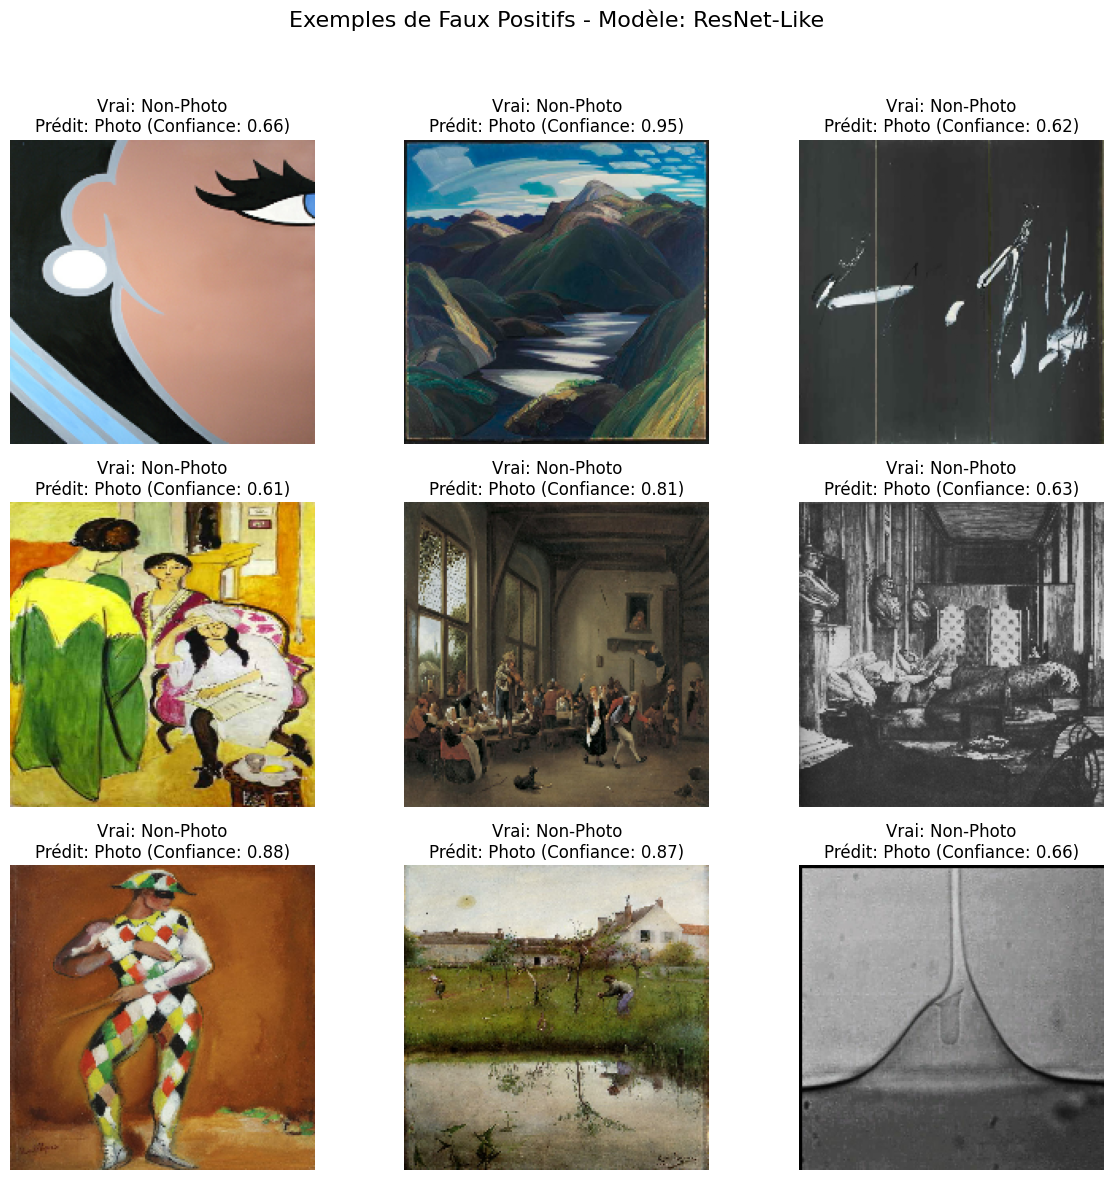


   -> Nettoyage du modèle final de la mémoire.


In [13]:
# --- Analyse Approfondie du Meilleur Modèle Identifié --- 

# Vérifier si un meilleur modèle a été identifié et si son fichier est accessible
best_model_available_for_analysis = (
    'overall_best_model_name' in locals() and overall_best_model_name and
    'overall_best_model_path' in locals() and overall_best_model_path and
    os.path.exists(overall_best_model_path) and
    ('test_set' in locals() and test_set) # S'assurer que le test set existe aussi
)

if best_model_available_for_analysis:
    print(f"\n{'='*30}")
    print(f" Analyse Post-Hoc du Meilleur Modèle : {overall_best_model_name}")
    print(f"{'='*30}")

    # 1. Charger le meilleur modèle global identifié
    print(f"[1/2] Chargement du modèle depuis : {overall_best_model_path}...")
    final_best_model = None # Initialiser
    try:
        # Charger le modèle sauvegardé
        final_best_model = tf.keras.models.load_model(overall_best_model_path)
        print("   -> Modèle chargé avec succès pour l'analyse.")
        # Afficher le résumé pour rappel
        # final_best_model.summary(line_length=100) 
    except Exception as e:
        print(f"   -> ERREUR lors du chargement du modèle final : {e}")

    # 2. Identifier et Afficher les Faux Positifs (si le modèle est chargé)
    if final_best_model:
        print(f"\n[2/2] Identification et Affichage des Faux Positifs (FP)..." )        
        print("      (Images 'Non-Photo' classées à tort comme 'Photo')")
        
        fp_images_to_show = []             # Liste pour stocker les images FP
        fp_predicted_probs_to_show = []    # Liste pour stocker les probabilités prédites pour ces FP
        num_fp_to_show = 9                 # Nombre max d'exemples à afficher
        collected_count = 0
        threshold = 0.5                    # Seuil de décision pour la classe 1 ('Photo')

        print(f"      -> Scan de l'ensemble de test pour trouver jusqu'à {num_fp_to_show} Faux Positifs...")
        try:
            # Itérer sur les lots de l'ensemble de test
            for images_batch, labels_batch in tqdm(test_set, desc="Analyse des lots", unit="lot"):
                # Arrêter si on a collecté assez d'exemples
                if collected_count >= num_fp_to_show:
                    break

                # Obtenir les prédictions (probabilités) pour le lot
                preds_batch_probs = final_best_model.predict_on_batch(images_batch)
                # Convertir en classes prédites (0 ou 1)
                preds_batch_classes = (preds_batch_probs > threshold).astype(int).flatten()
                # Obtenir les vraies étiquettes (0 ou 1)
                true_batch_labels = labels_batch.numpy().flatten().astype(int)

                # Identifier les indices des FP dans ce lot
                # Condition: Vraie étiquette = 0 ET Étiquette Prédite = 1
                fp_indices_in_batch = np.where((true_batch_labels == 0) & (preds_batch_classes == 1))[0]

                # Collecter les informations pour les FP trouvés
                for idx in fp_indices_in_batch:
                    if collected_count < num_fp_to_show:
                        # L'image est déjà dans [0, 1] car mise à l'échelle dans preprocess_binary_class
                        fp_images_to_show.append(images_batch[idx].numpy())
                        fp_predicted_probs_to_show.append(preds_batch_probs[idx][0]) # Probabilité de la classe 1
                        collected_count += 1
                    else:
                        break # Sortir de la boucle interne si assez d'exemples

            print(f"      -> {collected_count} exemples de Faux Positifs collectés.")

            # Afficher les images FP si au moins une a été trouvée
            if fp_images_to_show:
                print("      -> Affichage des exemples de Faux Positifs...")
                plt.figure(figsize=(12, 4 * int(np.ceil(len(fp_images_to_show) / 3))))
                rows = int(np.ceil(len(fp_images_to_show) / 3))
                for i in range(len(fp_images_to_show)):
                    ax = plt.subplot(rows, 3, i + 1)
                    plt.imshow(fp_images_to_show[i]) # Afficher l'image [0, 1]
                    true_label_name = target_class_names[0]    # Vrai = Non-Photo (0)
                    predicted_label_name = target_class_names[1] # Prédit = Photo (1)
                    prob = fp_predicted_probs_to_show[i]
                    plt.title(f"Vrai: {true_label_name}\nPrédit: {predicted_label_name} (Confiance: {prob:.2f})")
                    plt.axis("off")
                plt.suptitle(f"Exemples de Faux Positifs - Modèle: {overall_best_model_name}", fontsize=16, y=1.01)
                plt.tight_layout(rect=[0, 0.03, 1, 0.98])
                plt.show()
            else:
                print("      -> Aucun Faux Positif n'a été identifié dans les lots parcourus.")

        except Exception as posthoc_error:
             print(f"      -> ERREUR pendant l'analyse post-hoc (FP) : {posthoc_error}")
             import traceback
             traceback.print_exc()
    else:
        print("   -> Saut de l'analyse des Faux Positifs car le modèle final n'a pas pu être chargé.")

    # 3. Nettoyage final du modèle chargé pour l'analyse
    if 'final_best_model' in locals() and final_best_model:
        print("\n   -> Nettoyage du modèle final de la mémoire.")
        del final_best_model
        tf.keras.backend.clear_session()
        import gc
        gc.collect()

else:
    # Message indiquant pourquoi l'analyse post-hoc est sautée
    print(f"\n{'='*30}")
    print(" Analyse Post-Hoc Non Effectuée ")
    print(f"{'='*30}")
    if not datasets_available:
         print("   -> Raison : Les datasets (notamment test_set) n'étaient pas disponibles.")
    elif not ('overall_best_model_name' in locals() and overall_best_model_name):
        print("   -> Raison : Aucun meilleur modèle n'a été déterminé lors de la comparaison.")
    elif not ('overall_best_model_path' in locals() and overall_best_model_path and os.path.exists(overall_best_model_path)):
         print(f"   -> Raison : Le fichier checkpoint '{locals().get('overall_best_model_path', 'Chemin non défini')}' du meilleur modèle n'a pas été trouvé.")
    else:
         print("   -> Raison non déterminée (vérifier les conditions précédentes).")

### Analyse Technique Détaillée du Modèle ResNet-Like (Meilleur Modèle)

Suite à l'évaluation comparative, le modèle **ResNet-Like** s'est révélé être le plus performant pour cette tâche de classification binaire Photo/Non-Photo. Examinons plus en détail ses composants clés et les stratégies d'entraînement associées qui ont contribué à son succès.

#### 1. Architecture du Réseau (ResNet-Like)

L'architecture s'inspire fortement des principes des Réseaux Résiduels (ResNet), conçus pour faciliter l'entraînement de réseaux de neurones profonds.

*   **Principe Fondamental : Les Connexions Résiduelles (Residual Connections / Shortcuts)**
    *   **Problème Adressé :** Les réseaux très profonds souffrent souvent du problème de *disparition du gradient* (vanishing gradient). Lors de la rétropropagation de l'erreur, le gradient peut devenir extrêmement petit à mesure qu'il traverse de nombreuses couches, rendant l'apprentissage des couches initiales très lent voire impossible.
    *   **Solution ResNet :** L'idée clé est d'introduire des "connexions de raccourci" (shortcut connections) qui permettent au gradient (et à l'information) de "sauter" par-dessus une ou plusieurs couches. Plutôt que d'obliger un bloc de couches à apprendre directement une transformation complexe `H(x)` à partir d'une entrée `x`, ResNet lui fait apprendre une *fonction résiduelle* `F(x) = H(x) - x`. La sortie du bloc devient alors `H(x) = F(x) + x`.
    *   **Implémentation :** Cela est réalisé via une addition (`layers.Add()`) entre l'entrée du bloc (`x`, le raccourci) et la sortie des couches de transformation du bloc (`F(x)`). Si la transformation optimale est proche de l'identité (c'est-à-dire que les couches n'apportent pas grand-chose), le réseau peut facilement apprendre à rendre `F(x)` proche de zéro, et l'entrée `x` passe quasiment intacte. Cela facilite grandement l'optimisation.


    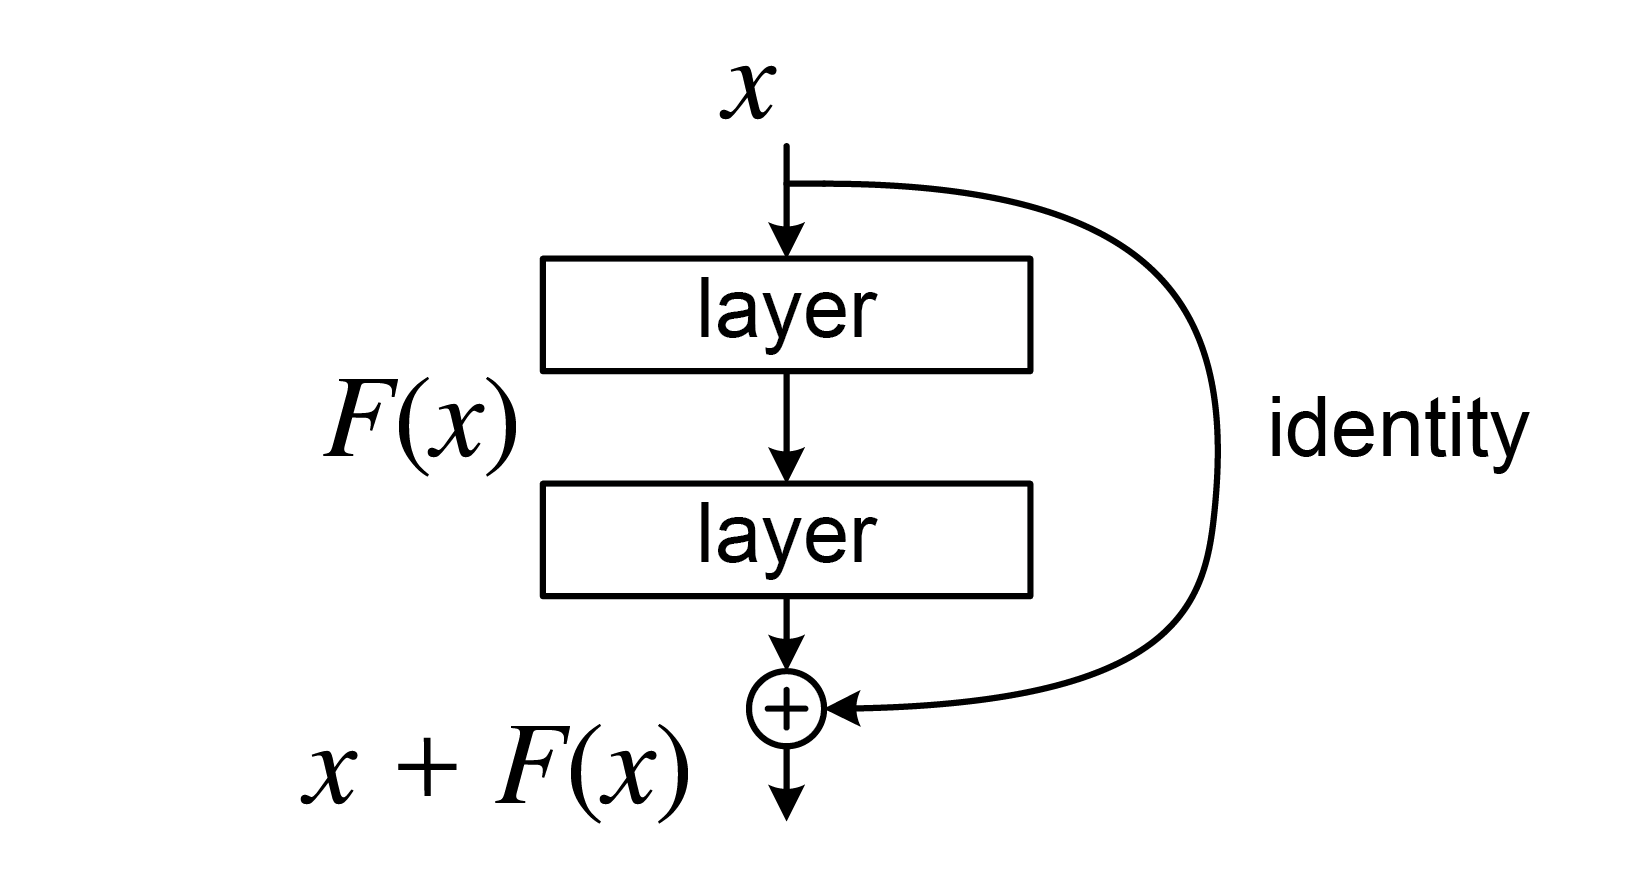



*   **Structure Générale du Modèle ResNet-Like :**
    1.  **Couche d'Entrée :** Accepte les images redimensionnées (`image_h`, `image_w`, 3 canaux).
    2.  **Augmentation de Données :** Applique les transformations aléatoires (`data_augmentation`) uniquement pendant l'entraînement.
    3.  **Tronc Initial (Stem) :** Une couche `Conv2D` avec un grand noyau (7x7) et un `stride` de 2, suivie d'une `BatchNormalization`, d'une activation `ReLU` et d'un `MaxPooling2D`. Ce bloc réduit rapidement les dimensions spatiales et extrait les caractéristiques de bas niveau.
    4.  **Corps Principal (Blocs ResNet) :** Une séquence de `build_resnet_style_block` organisés en "stages". Chaque bloc implémente la connexion résiduelle.
        *   **Bloc `build_resnet_style_block` :** Utilise une architecture de type "bottleneck" avec pré-activation (BN -> ReLU -> Conv) :
            *   `Conv2D` (1x1) : Réduit le nombre de filtres (réduction de la dimensionnalité).
            *   `Conv2D` (3x3) : Couche convolutive principale pour l'extraction de caractéristiques.
            *   `Conv2D` (1x1) : Augmente à nouveau le nombre de filtres (expansion).
            *   `SpatialDropout2D` : Appliqué après le bloc pour la régularisation (voir ci-dessous).
            *   `Shortcut` : L'entrée est ajoutée à la sortie du bloc (avec une projection `Conv2D` 1x1 sur le shortcut si les dimensions ou le nombre de filtres changent entre l'entrée et la sortie du bloc).
        *   Les `strides=(2,2)` sont utilisés dans le premier bloc de certains stages (3, 4, 5) pour réduire davantage les dimensions spatiales.
        *   Le nombre de filtres augmente progressivement à travers les stages (64 -> 128 -> 256 -> 512).
    5.  **Tête de Classification :**
        *   `GlobalAveragePooling2D` : Réduit chaque carte de caractéristiques finale en une seule valeur moyenne, produisant un vecteur de caractéristiques indépendant de la taille spatiale et plus robuste que `Flatten`.
        *   Couches `Dense` (256 neurones) avec activation `ReLU`, `BatchNormalization` et `Dropout` élevé (0.5) pour la classification finale et la régularisation.
        *   Couche de Sortie `Dense(1, activation='sigmoid')` : Produit la probabilité binaire finale (entre 0 et 1) pour la classe 'Photo'.


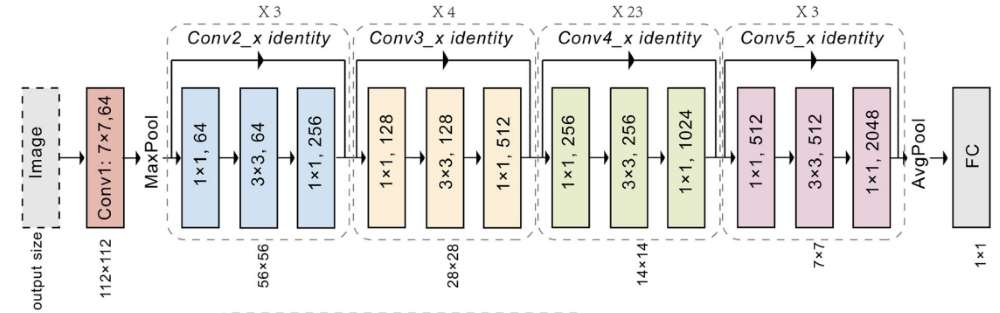


#### 2. Paramètres du Réseau

*   **Objectif Principal :** Quantifier l'erreur du modèle sur une tâche de classification binaire (deux classes, comme 'Photo' vs 'Non-Photo'). La sortie de notre modèle pour chaque image est une probabilité (entre 0 et 1, grâce à la fonction `sigmoid`) indiquant la confiance du modèle que l'image est une 'Photo'. La fonction de perte mesure à quel point cette probabilité prédite est éloignée de la vérité (qui est soit 0 pour 'Non-Photo', soit 1 pour 'Photo'). Le but de l'entraînement est de rendre cette valeur de perte aussi petite que possible.

*   **Comment elle Fonctionne (Intuitivement) :**
    L'entropie croisée binaire pénalise fortement le modèle lorsqu'il est très confiant mais se trompe :
    1.  **Cas 1 : La vraie image est une 'Photo' (étiquette = 1).**
        *   Si le modèle prédit une probabilité élevée (ex: 0.95, il est confiant et correct), la perte est très faible.
        *   Si le modèle prédit une probabilité faible (ex: 0.05, il est confiant mais incorrect), la perte est très élevée.
    2.  **Cas 2 : La vraie image est une 'Non-Photo' (étiquette = 0).**
        *   Si le modèle prédit une probabilité faible pour 'Photo' (ex: 0.05, il est confiant et correct), la perte est très faible.
        *   Si le modèle prédit une probabilité élevée pour 'Photo' (ex: 0.95, il est confiant mais incorrect), la perte est très élevée.
    Essentiellement, la fonction `log` dans sa définition mathématique (non montrée ici) assure que plus le modèle est sûr de lui dans la mauvaise direction, plus la "punition" (la perte) augmente rapidement.

*   **Pourquoi ce Choix ?** C'est la fonction de perte standard et la plus adaptée mathématiquement lorsque la sortie du réseau de neurone est une probabilité pour une classification binaire. Elle fournit un signal d'erreur clair et efficace pour guider l'optimiseur.

*   **Utilisation dans Keras :** `tf.keras.losses.BinaryCrossentropy()` implémente ce calcul. On l'utilise avec les paramètres par défaut car notre dernière couche a déjà une activation `sigmoid` qui transforme la sortie brute du réseau en une probabilité interprétable.

#### 4. Algorithme d'Optimisation (Optimizer)

*   **Objectif Principal :** Mettre à jour les poids (paramètres) du réseau de neurones de manière itérative pour minimiser la fonction de perte. Après que le réseau a fait une prédiction et que la perte a été calculée, l'optimiseur décide comment ajuster chaque poids pour que la prochaine prédiction soit meilleure.

*   **Au-delà de la Simple Descente de Gradient :** Les optimiseurs simples (comme la Descente de Gradient Stochastique - SGD) ajustent les poids en se basant uniquement sur l'erreur (gradient) calculée sur le lot de données actuel. Adam est plus sophistiqué.

*   **Les particularités d'Adam (Adaptive Moment Estimation) :**
    1.  **Adaptation par Paramètre :** Adam maintient un taux d'apprentissage *adaptatif* pour chaque poids individuel du réseau. Il ne traite pas tous les poids de la même manière. Les poids qui nécessitent de grands ajustements peuvent apprendre plus vite au début, tandis que ceux qui sont plus stables ou qui causent de grandes erreurs peuvent voir leur taux d'apprentissage réduit pour ne pas "dépasser" la bonne valeur. Pour ce faire, il garde une trace de la "moyenne" de l'amplitude des gradients passés pour chaque poids.
    2.  **Momentum (Effet Boule de Neige) :** Adam utilise également le concept de *momentum*. Il ne se base pas uniquement sur le gradient actuel, mais aussi sur une moyenne des gradients précédents. Cela aide cette algorithme à naviguer plus efficacement dans la "surface de perte" (le paysage des erreurs possibles), à traverser des zones plates et à éviter de rester coincé dans de mauvais minima locaux.

*   **Pourquoi ce Choix ?** Adam combine ces deux idées (taux adaptatifs et momentum), ce qui le rend souvent très efficace en pratique. Il converge généralement plus vite que SGD et est moins sensible au choix exact du taux d'apprentissage initial. C'est un excellent choix par défaut pour de nombreux problèmes de deep learning.

*   **Le Taux d'Apprentissage (`learning_rate=1e-4`) et `ReduceLROnPlateau` :**
    *   Le `learning_rate=1e-4` (soit 0.0001) que nous avons fourni à Adam est le taux d'apprentissage *initial* et *global*. Adam l'utilise comme point de départ, mais l'ajuste ensuite dynamiquement pour chaque poids comme décrit ci-dessus. Choisir une valeur initiale relativement faible comme 1e-4 est souvent une bonne stratégie pour les réseaux profonds comme ResNet, car cela favorise une convergence plus stable au début de l'entraînement.
    *   Le callback `ReduceLROnPlateau` surveille la performance sur les données de validation. Si la performance stagne (la perte de validation ne diminue plus), ce callback *réduit le taux d'apprentissage global* utilisé par Adam (par exemple, il passe de 1e-4 à 2e-5). Cela permet à Adam de faire des ajustements encore plus fins et plus précis des poids lorsqu'il s'approche de la meilleure solution possible.

#### 5. Gestion du Compromis Biais-Variance via Régularisation et Contrôle de l'Entraînement

L'objectif central de l'entraînement n'est pas seulement de minimiser l'erreur sur les données vues (entraînement), mais surtout de **maximiser la capacité du modèle à généraliser** à de nouvelles données invisibles (test). Ceci implique de trouver un équilibre de **compromis biais-variance** :

*   **Biais Élevé (Sous-apprentissage / Underfitting) :** Le modèle est trop simple, il ne capture pas les relations complexes dans les données. L'erreur est élevée à la fois sur l'entraînement et le test.
*   **Variance Élevée (Sur-apprentissage / Overfitting) :** Le modèle est trop complexe ou a "mémorisé" les données d'entraînement, y compris le bruit. L'erreur est très faible sur l'entraînement mais élevée sur le test.

Le succès du modèle ResNet-Like repose en grande partie sur l'utilisation combinée de plusieurs techniques visant à trouver le "juste milieu", principalement en contrôlant la variance (lutte contre le sur-apprentissage) tout en permettant au modèle d'avoir une capacité suffisante pour réduire le biais (apprendre les motifs) :

*   **Augmentation de Données (`data_augmentation`) :** Appliquée en début de modèle (uniquement pendant l'entraînement), elle génère des variations aléatoires des images (retournements, rotations, zooms, contrastes). Cela augmente artificiellement la taille et la diversité du jeu de données d'entraînement. *Impact :* Force le modèle à apprendre des caractéristiques plus générales et moins dépendantes des exemples spécifiques, réduisant ainsi sa capacité à simplement mémoriser (réduction de la variance).

*   **Dropout (`layers.Dropout` et `layers.SpatialDropout2D`) :**
    *   Le `Dropout` standard (appliqué aux couches `Dense`) et le `SpatialDropout2D` (appliqué dans les blocs ResNet) désactivent aléatoirement des neurones ou des cartes de caractéristiques entières pendant l'entraînement. *Impact :* Empêche le réseau de devenir trop dépendant d'un petit sous-ensemble de neurones ou de caractéristiques. Cela favorise l'apprentissage de représentations plus robustes et distribuées, réduisant la variance et améliorant la généralisation. Les taux de dropout ont été choisis (0.1 à 0.5) pour appliquer une régularisation plus forte vers la fin du réseau.

*   **Régularisation L2 (`kernel_regularizer=regularizers.l2(0.001)`) :** Appliquée aux poids des couches `Dense`, elle ajoute une pénalité à la fonction de perte qui est proportionnelle à la somme des carrés des valeurs des poids. *Impact :* Encourage le modèle à utiliser des poids de faible magnitude, ce qui correspond souvent à des modèles plus simples et moins enclins au sur-apprentissage (réduction de la variance).

*   **Batch Normalization (`layers.BatchNormalization`) :** Bien que son rôle principal soit de stabiliser et d'accélérer l'entraînement en normalisant les activations, elle introduit également une légère forme de bruit (car les statistiques de normalisation sont calculées sur chaque mini-lot). *Impact :* Cet effet de bruit peut agir comme une forme subtile de régularisation, contribuant légèrement à la réduction de la variance.

*   **Arrêt Anticipé (`EarlyStopping`) :** C'est un outil crucial pour gérer directement le compromis. Il surveille la performance (ici, `val_auc`) sur un ensemble de *validation* distinct pendant l'entraînement. *Impact :* L'entraînement est stoppé dès que la performance sur la validation cesse de s'améliorer (`patience=7` époques), idéalement au point où le modèle généralise le mieux, avant que la variance n'augmente trop (c'est-à-dire avant que le modèle ne commence à sur-apprendre les données d'entraînement au détriment de la performance de validation). L'option `restore_best_weights=True` assure que l'on récupère les poids du modèle correspondant à ce pic de performance de validation.

*   **Réduction du Taux d'Apprentissage (`ReduceLROnPlateau`) :** En réduisant le taux d'apprentissage lorsque la perte de validation stagne (`patience=3`), on permet au modèle de converger plus finement vers un bon minimum local, sans "osciller" autour de manière excessive. *Impact :* Bien que moins directement lié à la régularisation, cela aide à atteindre un meilleur point d'équilibre final en affinant la recherche de l'optimiseur, contribuant ainsi à obtenir un modèle avec un bon compromis biais-variance.

*   **Pondération des Classes (`class_weight`) :** Bien que son objectif principal soit de gérer le déséquilibre de classes, elle influence également l'apprentissage. *Impact :* En forçant le modèle à prêter plus attention à la classe minoritaire, elle peut l'aider à apprendre des caractéristiques discriminantes plus subtiles qu'il aurait pu ignorer autrement, potentiellement réduisant légèrement le biais pour cette classe.

En conclusion, la performance robuste du ResNet-Like ne vient pas seulement de son architecture intrinsèque (connexions résiduelles), mais aussi de l'application synergique de ces différentes stratégies qui visent à contrôler la complexité effective du modèle et à arrêter l'entraînement au moment optimal pour maximiser sa capacité de généralisation aux données non vues.


## Conclusion Globale

Ce projet visait à développer une ou plusieurs architectures de réseaux de neurones convolutifs pour une tâche de classification binaire exigeante : **distinguer les photographies des autres types d'images (peintures, dessins, illustrations, etc.), collectivement appelées 'Non-Photos'**. La difficulté principale résidait dans la subtilité des caractéristiques visuelles permettant cette distinction, les peintures réalistes ou les photographies stylisées pouvant présenter des similarités trompeuses pour un modèle.

Après avoir mis en place un pipeline de traitement incluant le nettoyage des données (bien que des avertissements sur des JPEG corrompus persistent et nécessitent une investigation plus poussée), l'augmentation de données pour améliorer la généralisation, et une stratégie d'entraînement contrôlée par des callbacks (arrêt anticipé basé sur l'AUC de validation, réduction du taux d'apprentissage), quatre architectures (EfficientNet-Like, GoogLeNet-Like, ResNet-Like, DenseNet-Like) ont été entraînées et évaluées de manière comparative.

L'analyse des performances finales sur un ensemble de test non vu pendant l'entraînement a clairement désigné le modèle **ResNet-Like comme étant le plus performant globalement**. Il a excellé sur la majorité des métriques clés, notamment l'AUC (0.9827), le Recall (0.9088) et le F1-Score (0.8852), indiquant une excellente capacité à discriminer les classes et à identifier correctement les photos tout en maintenant un bon équilibre avec la précision de ses prédictions.

L'**analyse post-hoc**, concentrée sur les erreurs du meilleur modèle (ResNet-Like), a permis d'examiner spécifiquement les **Faux Positifs** – les images 'Non-Photo' classées à tort comme 'Photo'. Les exemples visualisés confirment la nature du défi : **le modèle éprouve principalement des difficultés avec les peintures et les dessins très réalistes ou présentant des textures similaires à celles des photographies**. Ces cas limites, où la frontière artistique entre représentation fidèle et capture photographique est ténue, constituent les erreurs les plus fréquentes. Cela suggère que si une amélioration de la précision (réduction des Faux Positifs) est souhaitée, des ajustements pourraient être nécessaires, potentiellement via une augmentation de données plus ciblée sur les textures et les styles artistiques, ou par l'entraînement sur un jeu de données encore plus large et diversifié incluant davantage de ces cas ambigus.

En conclusion, malgré la difficulté inhérente à la tâche, le modèle ResNet-Like a démontré une capacité robuste à effectuer la classification désirée. Les prochaines étapes pour améliorer encore les résultats devraient prioritairement s'attaquer à la **finalisation du nettoyage des données** pour éliminer toute source d'instabilité, puis potentiellement explorer une **optimisation fine des hyperparamètres** et des **stratégies d'augmentation spécifiques** pour mieux gérer les cas limites identifiés lors de l'analyse post-hoc.